# Q-Learning vs SARSA — Random GridWorld
What we will learn from this notebook:

- How to generate a simple grid environment? What components we need to define for the environment?
- Q-learning and SARSA implementations
- The effect of reward shaping and having terminal non-goal states (lava)
- The effect of randomizing the initial state
- Comparing off-policy on-policy methods
- The effect of temperature


In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0) # for reproducibility


# How to generate a simple grid environment? What components we need to define for the environment?

In [2]:
class GridWorld:
    def __init__(self, width=8, height=6, wall_prob=0.15, lava_prob=0.05,
                 random_seed=None, per_step_penalty=0.0, lava_terminal=True, random_initial=True):
        # Initialize environment parameters
        self.width = width
        self.height = height
        self.rng = np.random.RandomState(random_seed)   # random generator for reproducibility
        self.wall_prob = wall_prob      # probability a cell is a wall
        self.lava_prob = lava_prob      # probability a cell is lava
        self.per_step_penalty = per_step_penalty  # small penalty applied to all moves
        self.lava_terminal = lava_terminal        # if True, stepping into lava ends the episode
        self.random_initial = random_initial      # if True, start position is random (not fixed)
        self.reset_grid()                         # generate initial grid

    def reset_grid(self):
        # Initialize grid with zeros (free space)
        self.grid = np.zeros((self.height, self.width), dtype=int)
        # Fill the grid with walls or lava according to probabilities
        for r in range(self.height):
            for c in range(self.width):
                if self.rng.rand() < self.wall_prob:
                    self.grid[r, c] = 1  # wall
                elif self.rng.rand() < self.lava_prob:
                    self.grid[r, c] = 2  # lava
        # Find free cells (0)
        free = list(zip(*np.where(self.grid==0)))
        # Ensure there are enough free cells (at least 2 for start and goal)
        if len(free) < 2:
            self.grid[:] = 0
            free = list(zip(*np.where(self.grid==0)))
        self.free_forstart = free
        # Select start position randomly
        self.start = free[self.rng.randint(len(free))]
        # Select goal position randomly (different from start)
        while True:
            g = free[self.rng.randint(len(free))]
            if g != self.start:
                self.goal = g
                break
        # Mark start and goal in grid
        self.grid[self.start] = 3
        self.grid[self.goal] = 4
        # Agent starts at start position
        self.agent_pos = self.start
        # Action space: right, down, left, up
        self.actions = [(0,1),(1,0),(0,-1),(-1,0)]
        self.action_names = ['R','D','L','U']

    def in_bounds(self, pos):
        # Check if a position is within the grid boundaries
        r,c = pos
        return 0 <= r < self.height and 0 <= c < self.width

    def step(self, action):
        # Apply action to move agent
        dr,dc = self.actions[action]
        nr, nc = self.agent_pos[0]+dr, self.agent_pos[1]+dc
        # Case 1: Move outside bounds
        if not self.in_bounds((nr,nc)):
            reward = -1.0 + self.per_step_penalty
            done = False
            return self.agent_pos, reward, done, {}
        # Check what is in the target cell
        cell = self.grid[nr, nc]
        # Case 2: Hit a wall
        if cell == 1:
            reward = -2.0 + self.per_step_penalty
            done = False
            return self.agent_pos, reward, done, {}
        # Otherwise, update agent position
        self.agent_pos = (nr,nc)
        # Case 3: Lava
        if cell == 2:
            reward = -10.0 + self.per_step_penalty
            done = self.lava_terminal
            return self.agent_pos, reward, done, {}
        # Case 4: Goal
        if cell == 4:
            reward = 10.0
            done = True
            return self.agent_pos, reward, done, {}
        # Case 5: Normal move
        reward = -0.1 + self.per_step_penalty
        done = False
        return self.agent_pos, reward, done, {}

    def reset(self):
        # Reset agent position either randomly or to fixed start
        if self.random_initial:
            self.agent_pos = self.free_forstart[self.rng.randint(len(self.free_forstart))]
        else:
            self.agent_pos = self.start
        return self.agent_pos

    def render(self):
        # Render the grid world as characters
        disp = np.array(self.grid, dtype=object)
        for r in range(self.height):
            for c in range(self.width):
                if disp[r,c] == 0:
                    disp[r,c] = '.'   # free space
                elif disp[r,c] == 1:
                    disp[r,c] = '#'   # wall
                elif disp[r,c] == 2:
                    disp[r,c] = 'L'   # lava
                elif disp[r,c] == 3:
                    disp[r,c] = 'S'   # start
                elif disp[r,c] == 4:
                    disp[r,c] = 'G'   # goal
        # Place agent on grid
        ar,ac = self.agent_pos
        disp[ar,ac] = 'A'
        # Print row by row
        for row in disp:
            print(' '.join(row))

    def state_to_idx(self, pos):
        # Convert (row, col) into a single integer index
        return pos[0]*self.width + pos[1]


# Q-learning and SARSA implementations

In [3]:
def make_epsilon_greedy_policy(Q, nA, epsilon):
    # Returns a policy function that selects actions according to epsilon-greedy strategy
    def policy_fn(state):
        # --- Current approach: return a probability distribution ---
        A = np.ones(nA, dtype=float) * epsilon / nA
        best = np.argmax(Q[state])
        A[best] += (1.0 - epsilon)
        return A
    
        # --- Alternative way (if-based epsilon greedy) ---
        # if np.random.rand() < epsilon:
        #     action = np.random.randint(nA)      # choose random action
        # else:
        #     action = np.argmax(Q[state])        # choose best action
        # return action
        #
        # Why prefer this:
        # - Simpler: directly returns an action, no need for probability array
        # - Faster: avoids building distribution + sampling each step
        # - Clearer: explicitly shows "explore vs exploit" logic
        #
        # Downside:
        # - Less flexible if you later want to log probabilities
        #   (needed in policy gradient methods or entropy regularization)
    
    return policy_fn


def q_learning(env, num_episodes=500, alpha=0.5, gamma=0.99, epsilon=0.1, max_steps=200):
    # Q-learning algorithm (off-policy TD control)
    nS = env.width*env.height   # number of states
    nA = 4                      # number of actions (fixed for GridWorld)
    Q = np.zeros((nS, nA))      # initialize Q-table
    policy = make_epsilon_greedy_policy(Q, nA, epsilon)  # policy function
    rewards_history = []        # track total reward per episode
    
    for i_episode in range(num_episodes):
        state_pos = env.reset()                 # reset environment
        s = env.state_to_idx(state_pos)         # get state index
        total_reward = 0.0
        
        for t in range(max_steps):
            probs = policy(s)                   # action probabilities
            a = np.random.choice(np.arange(nA), p=probs)  # sample action
            next_pos, r, done, _ = env.step(a)  # take step
            s2 = env.state_to_idx(next_pos)     # next state index
            best_next = np.max(Q[s2])           # best Q value for next state
            # Q-learning update (off-policy target)
            Q[s,a] += alpha*(r + gamma*best_next - Q[s,a])
            total_reward += r
            s = s2
            if done:
                break
        rewards_history.append(total_reward)
    return Q, rewards_history


def sarsa(env, num_episodes=500, alpha=0.5, gamma=0.99, epsilon=0.1, max_steps=200):
    # SARSA algorithm (on-policy TD control)
    nS = env.width*env.height
    nA = 4
    Q = np.zeros((nS, nA))
    policy = make_epsilon_greedy_policy(Q, nA, epsilon)
    rewards_history = []
    
    for i_episode in range(num_episodes):
        state_pos = env.reset()
        s = env.state_to_idx(state_pos)
        probs = policy(s)
        a = np.random.choice(np.arange(nA), p=probs)   # initial action
        total_reward = 0.0
        
        for t in range(max_steps):
            next_pos, r, done, _ = env.step(a)         # take action
            s2 = env.state_to_idx(next_pos)
            probs2 = policy(s2)
            a2 = np.random.choice(np.arange(nA), p=probs2)   # next action (on-policy)
            # SARSA update (uses actual action chosen in next state)
            Q[s,a] += alpha*(r + gamma*Q[s2,a2] - Q[s,a])
            total_reward += r
            s, a = s2, a2
            if done:
                break
        rewards_history.append(total_reward)
    return Q, rewards_history

# Training loop, evaluating policy, and plotting the learning dynamics

In [4]:
def evaluate_policy(env, Q, episodes=50, max_steps=200):
    # Evaluates a learned Q-table on the environment.
    # Why: Lets you measure how good your policy is after training (success rate, reward).
    success = 0
    total_rewards = []
    for _ in range(episodes):
        s_pos = env.reset()  # Reset environment at start of each episode
        s = env.state_to_idx(s_pos)  # Convert position to state index
        total = 0.0
        for _ in range(max_steps):
            a = int(np.argmax(Q[s]))  # Always take greedy action (evaluation phase, no exploration)
            next_pos, r, done, _ = env.step(a)  # Apply action in env
            total += r  # Track total reward
            s = env.state_to_idx(next_pos)  # Update state
            if done:  # Stop episode if terminal
                if next_pos == env.goal:  # Check if reached goal
                    success += 1
                break
        total_rewards.append(total)  # Record reward for episode
    # Returns success rate, mean reward, and all rewards
    return success/episodes, np.mean(total_rewards), total_rewards


def plot_rewards(hist_q, hist_s, title='Training rewards'):
    # Plots training rewards for Q-learning vs SARSA.
    # Why: Visualization makes it easy to see which algorithm learns faster or more stably.
    plt.figure(figsize=(10,4))
    # Smoothed curve (moving average with window size=10) -> helps see trend clearly
    plt.plot(np.convolve(hist_q, np.ones(10)/10, mode='valid'), label='Q-learning (smoothed)')
    plt.plot(np.convolve(hist_s, np.ones(10)/10, mode='valid'), label='SARSA (smoothed)')
    plt.xlabel('Episode (smoothed window)')
    plt.ylabel('Total reward per episode')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()


def run_experiment(seed=0, width=8, height=6, wall_prob=0.15, lava_prob=0.05,
                   per_step_penalty=0.0, lava_terminal=True, episodes=500, random_initial=True, epsilon=0.1):
    # Main driver function: sets up environment, trains Q-learning and SARSA, evaluates, and plots.
    # Why: Automates comparison between algorithms under same conditions.

    env = GridWorld(width=width, height=height, wall_prob=wall_prob, lava_prob=lava_prob,
                    random_seed=seed, per_step_penalty=per_step_penalty, lava_terminal=lava_terminal, random_initial=random_initial)
    
    print('Grid (A=Agent, G=goal, #=wall, L=lava):')
    env.render()  # Shows initial grid -> good for debugging/understanding env layout
    
    # Train Q-learning agent
    # Why prefer: Often converges to optimal policy in the limit, can be more "greedy" effective.
    Q_q, hist_q = q_learning(env, num_episodes=episodes, alpha=0.6, gamma=0.99, epsilon=epsilon)
    
    env.reset()
    # Train SARSA agent
    # Why prefer: On-policy, tends to be safer in risky environments (like lava), less aggressive.
    Q_s, hist_s = sarsa(env, num_episodes=episodes, alpha=0.6, gamma=0.99, epsilon=epsilon)
    
    env.reset()
    # Evaluate both policies (no exploration during evaluation)
    succ_q, mean_r_q, _ = evaluate_policy(env, Q_q, episodes=200)
    env.reset()
    succ_s, mean_r_s, _ = evaluate_policy(env, Q_s, episodes=200)
    
    # Print comparison results
    print(f'Q-learning success rate: {succ_q:.2f}, avg reward: {mean_r_q:.2f}')
    print(f'SARSA       success rate: {succ_s:.2f}, avg reward: {mean_r_s:.2f}')
    
    # Plot learning curves for visual comparison
    plot_rewards(hist_q, hist_s, title=f'Learning curves | lava_prob={lava_prob} | per_step_penalty={per_step_penalty}')
    
    # Return everything for further analysis
    return env, Q_q, Q_s, hist_q, hist_s


# Plotting heatmaps for Q values and plotting the optimal policies

In [5]:
# Q-value plotting utilities
def plot_q_heatmaps(Q, env, title_prefix='Q-values'):
    # Visualizes Q-values for each action in a cross layout + state-values in the center.
    # Why prefer: Helps you see *how each action is valued in each state*, not just the greedy policy.
    
    nA = Q.shape[1]  # Number of actions
    grids = [Q[:,a].reshape(env.height, env.width) for a in range(nA)]  # Reshape Q-values into grid layout
    vmax = max(np.max(g) for g in grids)  # For consistent color scaling across actions
    vmin = min(np.min(g) for g in grids)
    
    # Create a 3x3 grid layout for cross arrangement
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    action_names = env.action_names
    
    # Define positions for each action plot in cross pattern
    # Center: state-values; Surrounding: Q-values for each action
    # Why prefer this layout: Mirrors agent’s perspective — central state value, directional actions around it.
    positions = [(1, 2),(2, 1),(1, 0),(0, 1)]  # left, right, up, down
    
    # Hide all axes initially
    for i in range(3):
        for j in range(3):
            axes[i, j].set_visible(False)
    
    # Plot action-specific Q-values around the center
    for i in range(min(nA, 4)):  # Limit to 4 actions for cross layout
        row, col = positions[i]
        ax = axes[row, col]
        ax.set_visible(True)
        
        im = ax.imshow(grids[i], origin='upper', vmin=vmin, vmax=vmax)  # Heatmap of Q-values
        ax.set_title(f'{title_prefix} — action {action_names[i]}')
        
        # Add grid annotations (walls, lava, start, goal)
        for r in range(env.height):
            for c in range(env.width):
                cell = env.grid[r,c]
                if cell == 1:
                    ax.text(c, r, '#', ha='center', va='center', fontsize=12, color='white')  # Wall
                elif cell == 2:
                    ax.text(c, r, 'L', ha='center', va='center', fontsize=12, color='white')  # Lava
                elif cell == 3:
                    ax.text(c, r, 'S', ha='center', va='center', fontsize=12, color='white')  # Start
                elif cell == 4:
                    ax.text(c, r, 'G', ha='center', va='center', fontsize=12, color='white')  # Goal
        
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Color scale for each action heatmap
    
    # Plot state-value (max Q) in the center
    # Why prefer: Summarizes the "best" expected return from each state — global view of learned policy.
    state_vals = np.max(Q, axis=1).reshape(env.height, env.width)
    center_ax = axes[1, 1]
    center_ax.set_visible(True)
    
    im = center_ax.imshow(state_vals, origin='upper')
    center_ax.set_title(f'{title_prefix} — state-value (max Q)')
    
    # Add grid annotations for center plot
    for r in range(env.height):
        for c in range(env.width):
            cell = env.grid[r,c]
            if cell == 1:
                center_ax.text(c, r, '#', ha='center', va='center', fontsize=12, color='white')
            elif cell == 2:
                center_ax.text(c, r, 'L', ha='center', va='center', fontsize=12, color='white')
            elif cell == 3:
                center_ax.text(c, r, 'S', ha='center', va='center', fontsize=12, color='white')
            elif cell == 4:
                center_ax.text(c, r, 'G', ha='center', va='center', fontsize=12, color='white')
    
    fig.colorbar(im, ax=center_ax, fraction=0.046, pad=0.04)  # Color scale for state-values
    
    plt.tight_layout()
    plt.show()


def plot_greedy_policy(Q, env, title='Greedy policy (from Q)'):
    # Visualizes the greedy policy (best action per state) as arrows on the grid.
    # Why prefer: Simple and intuitive way to check what the agent would *actually do* in each state.
    
    best = np.argmax(Q, axis=1).reshape(env.height, env.width)  # Best action index per state
    plt.figure(figsize=(env.width, env.height/1.5))
    for r in range(env.height):
        for c in range(env.width):
            a = best[r,c]  # Greedy action at this state
            cell = env.grid[r,c]
            if cell == 1:
                plt.text(c, r, '#', ha='center', va='center', fontsize=12)  # Wall
            elif cell == 2:
                plt.text(c, r, 'L', ha='center', va='center', fontsize=12)  # Lava
            elif cell == 4:
                plt.text(c, r, 'G', ha='center', va='center', fontsize=12)  # Goal
            elif cell == 3:
                plt.text(c, r, 'S', ha='center', va='center', fontsize=12)  # Start
            else:
                # Draw arrow for greedy action
                dx, dy = 0,0
                if a==0: dx=0.3; dy=0   # Right
                if a==1: dx=0; dy=0.3   # Down
                if a==2: dx=-0.3; dy=0  # Left
                if a==3: dx=0; dy=-0.3  # Up
                plt.arrow(c, r, dx, dy, head_width=0.12, head_length=0.12)
    
    # Formatting the grid display
    plt.xlim(-0.5, env.width-0.5)
    plt.ylim(env.height-0.5, -0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.axis('off')
    plt.show()


# The effect of reward shaping and having terminal non-goal states (lava)

Grid (A=Agent, G=goal, #=wall, L=lava):
. . . . . . # .
. . . # . . . G
. . # . . A . .
. . . # . . . .
. . # . . . . .
# . . . . . . .
Q-learning success rate: 1.00, avg reward: 9.80
SARSA       success rate: 1.00, avg reward: 9.80


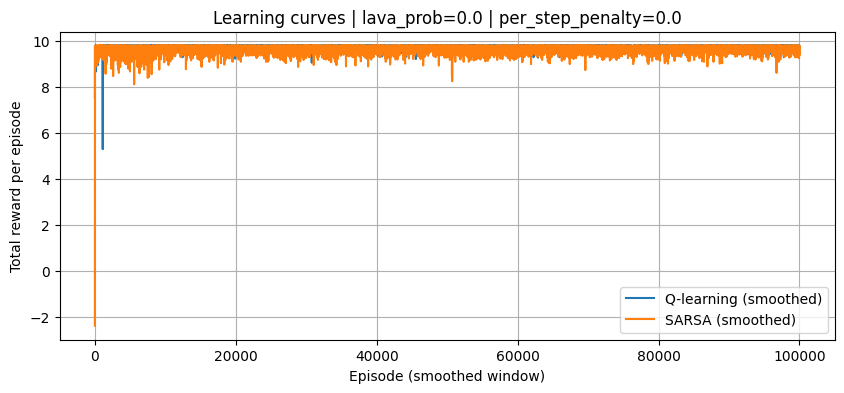

Grid (A=Agent, G=goal, #=wall, L=lava):
. . . . . . # .
. . . # . . . G
. . # . . A . .
. . . # . . . .
. . # . . . . .
# . . . . . . .
Q-learning success rate: 1.00, avg reward: 8.80
SARSA       success rate: 1.00, avg reward: 8.80


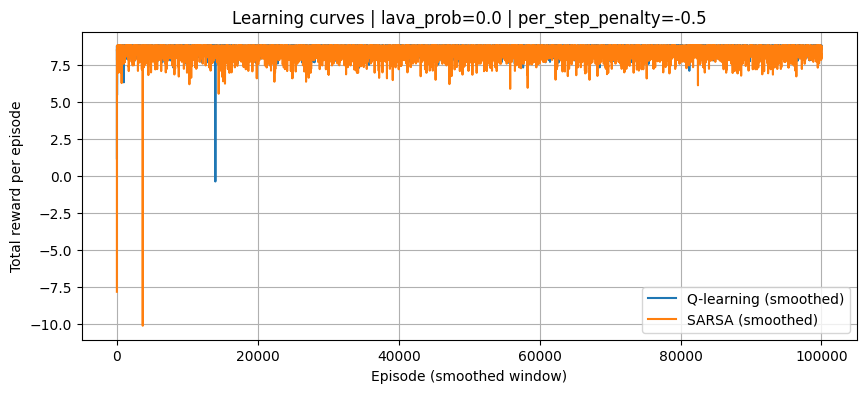

Grid (A=Agent, G=goal, #=wall, L=lava):
. . . A G # L .
. L . . L # . #
. # . . # . . .
. . . # . # # .
. . L . # . . .
# . . # . . . .
Q-learning success rate: 1.00, avg reward: 10.00
SARSA       success rate: 1.00, avg reward: 10.00


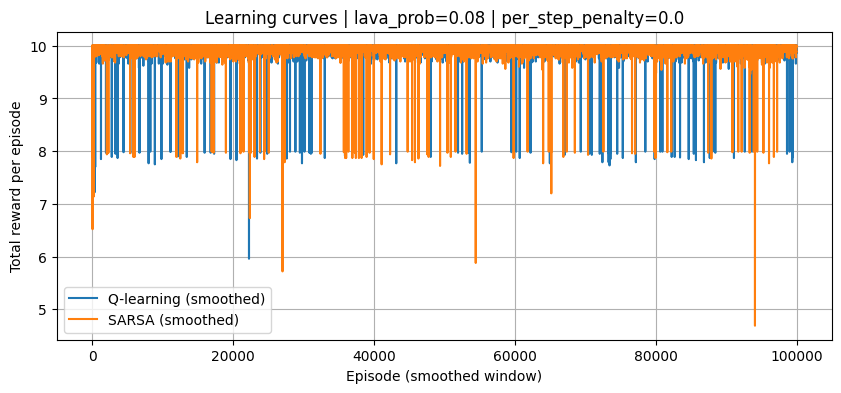

Grid (A=Agent, G=goal, #=wall, L=lava):
. . . A G # L .
. L . . L # . #
. # . . # . . .
. . . # . # # .
. . L . # . . .
# . . # . . . .
Q-learning success rate: 1.00, avg reward: 10.00
SARSA       success rate: 1.00, avg reward: 10.00


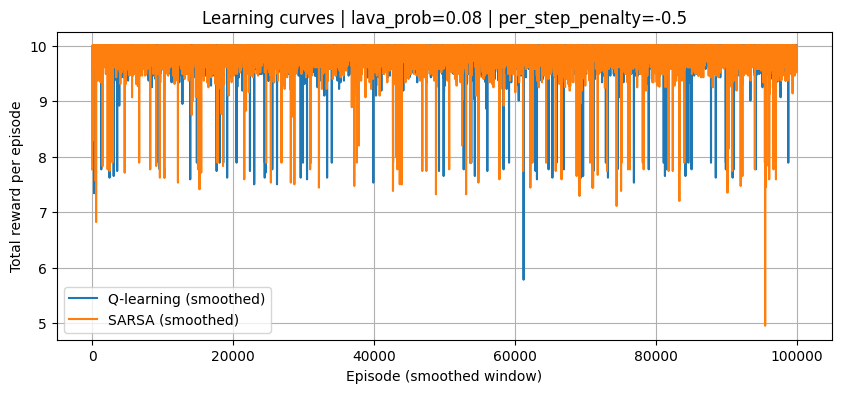

In [6]:
random_initial = False
# Demo runs - modify parameters or call run_experiment yourself
env_a, Qqa, Qsa, hqa, hsa = run_experiment(seed=10, lava_prob=0.0, per_step_penalty=0.0, episodes=100000, random_initial=random_initial)
env_b, Qqb, Qsb, hqb, hsb = run_experiment(seed=10, lava_prob=0.0, per_step_penalty=-0.5, lava_terminal=True, episodes=100000, random_initial=random_initial)
env_c, Qqc, Qsc, hqc, hsc = run_experiment(seed=13, lava_prob=0.08, per_step_penalty=0.0, lava_terminal=True, episodes=100000, random_initial=random_initial)
env_d, Qqd, Qsd, hqd, hsd = run_experiment(seed=13, lava_prob=0.08, per_step_penalty=-0.5, lava_terminal=True, episodes=100000, random_initial=random_initial)

## Q-value visualization utilities
This section adds plotting utilities to visualize the learned Q-values:
- `plot_q_heatmaps(Q, env, title_prefix='')` — value heatmap (max Q) + per-action heatmaps
- `plot_policy_with_values(Q, env, title='')` — overlays best-action arrows on a value (V) heatmap

A demo cell at the bottom will try to use any already-trained Q variables (e.g. `Qqa`, `Qqb`, `Qqc`) or run a short training if none are found.

No Lava-No Penalty, Q Learning
. . . . . . # .
. . . # . . . G
. . # . . A . .
. . . # . . . .
. . # . . . . .
# . . . . . . .


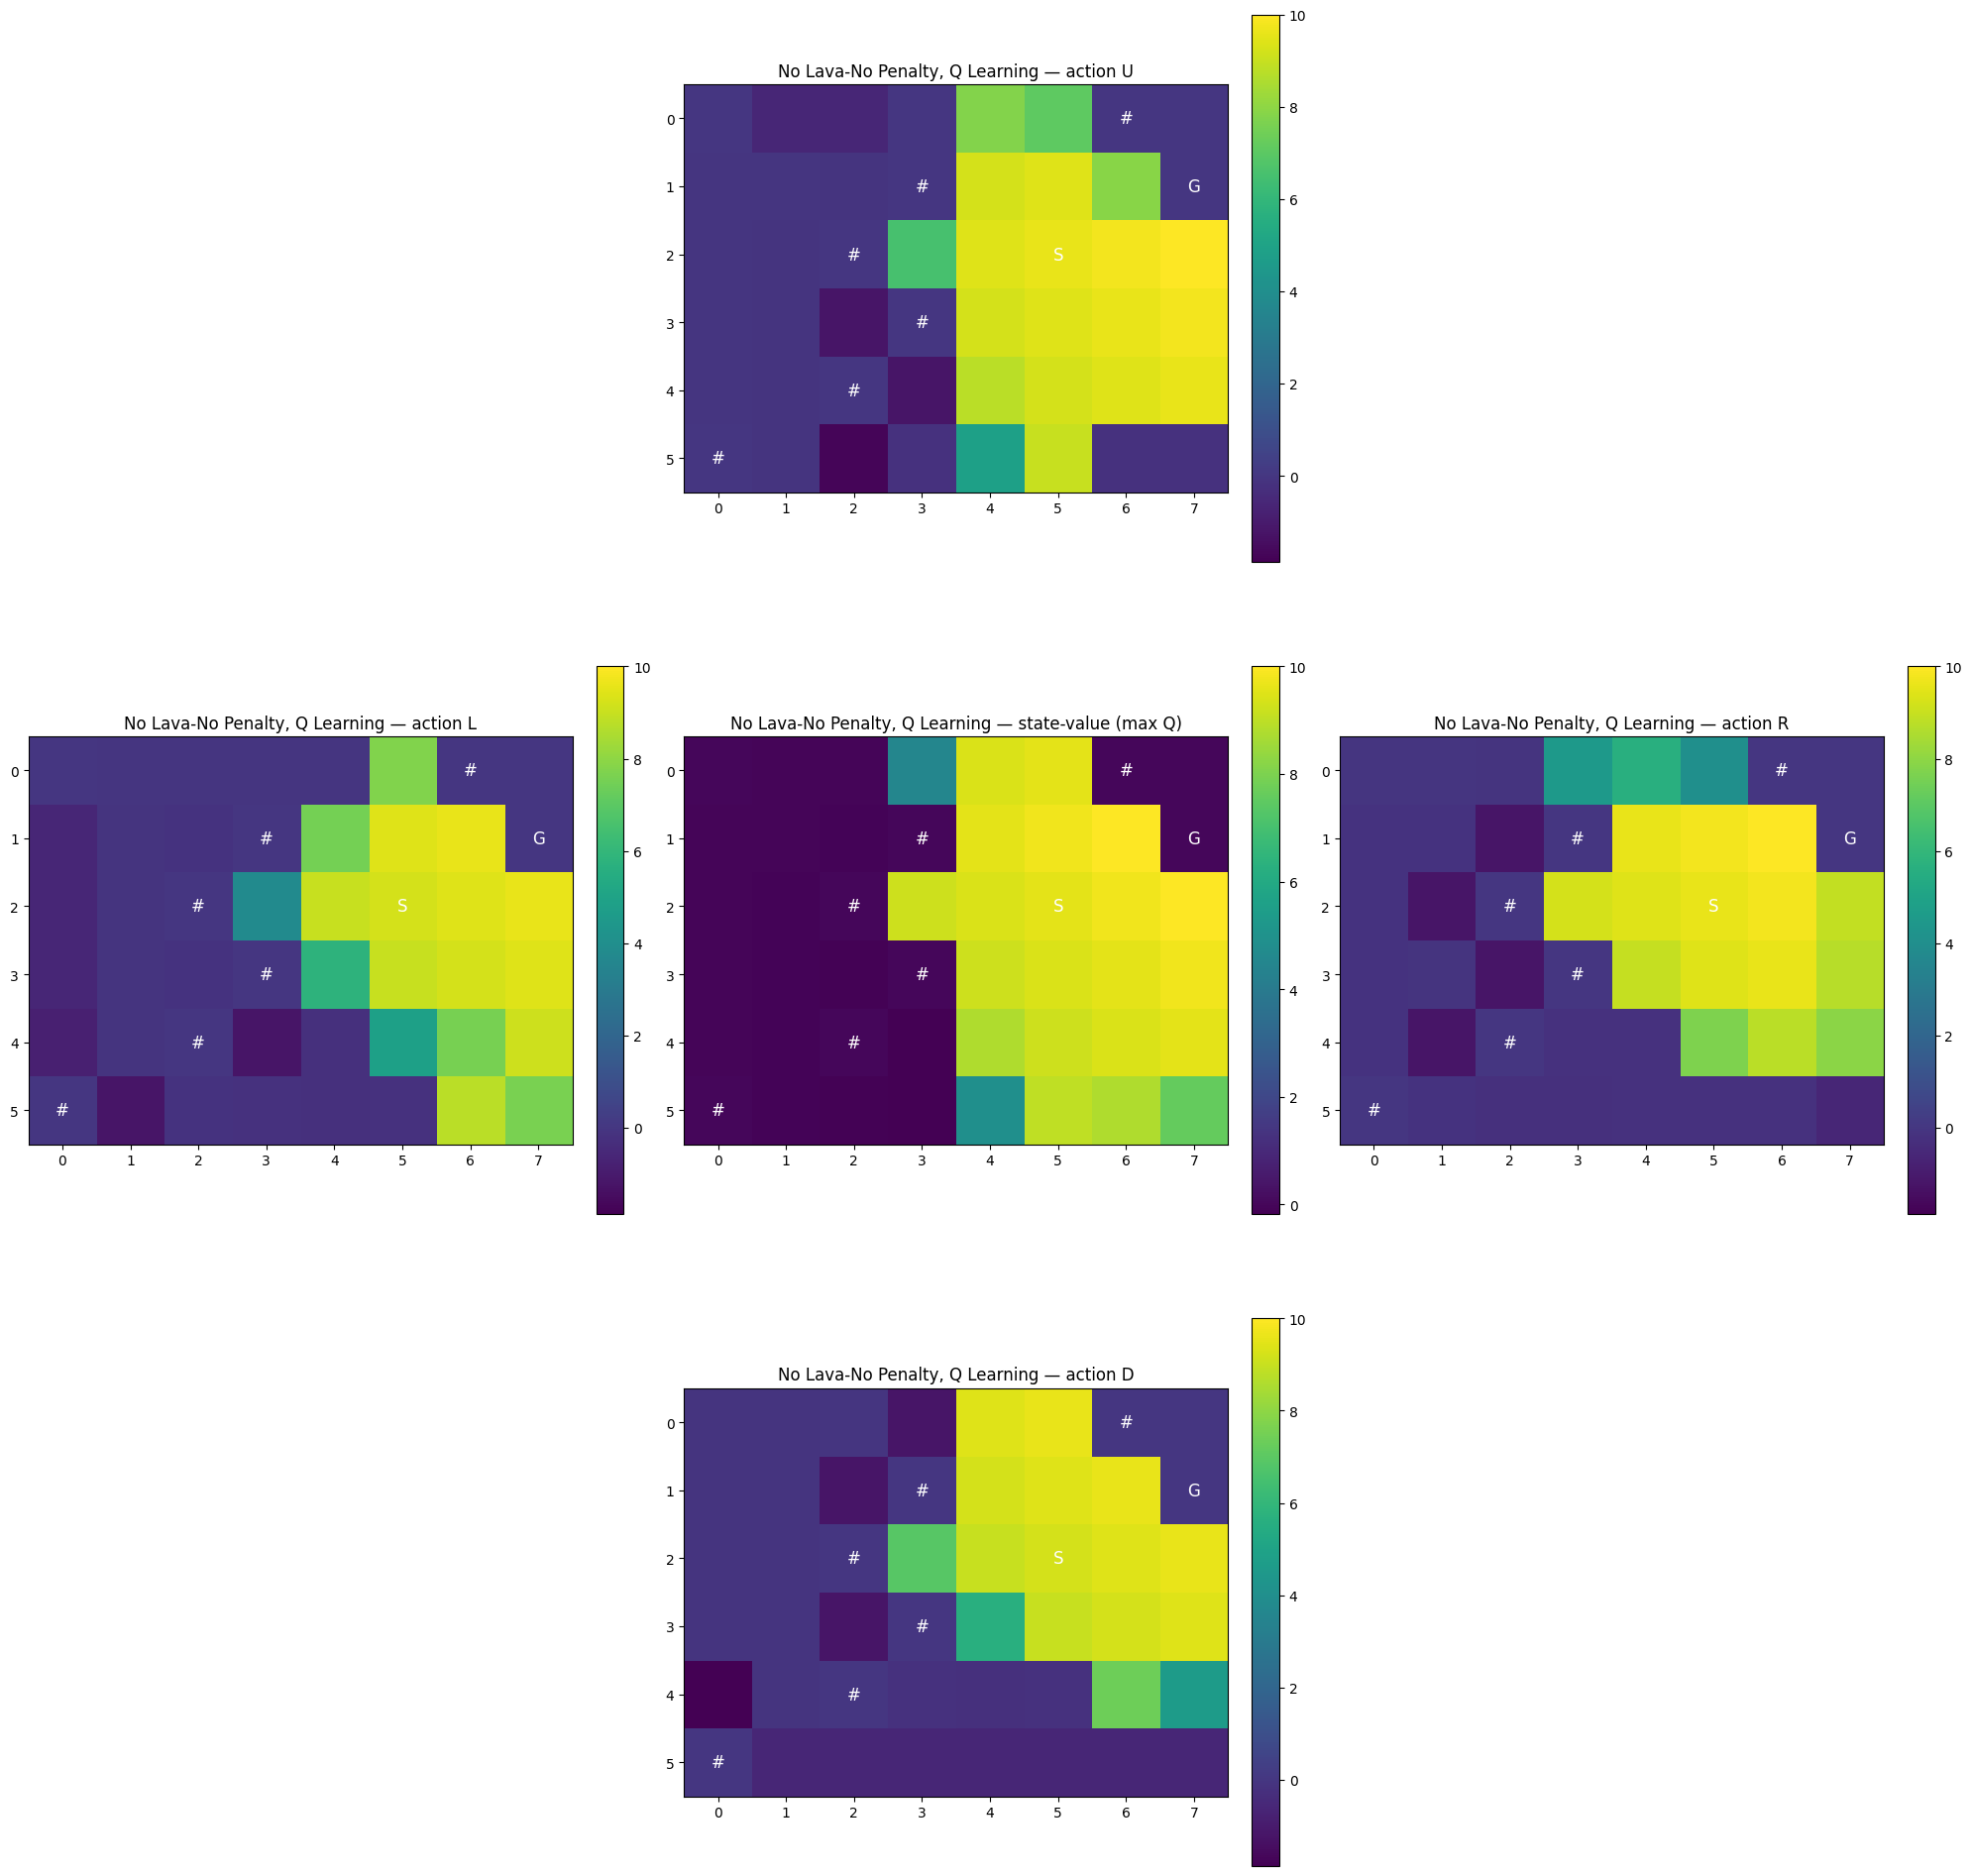

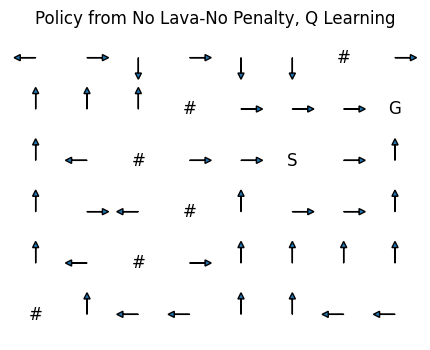

No Lava-No Penalty, SARSA
. . . . . . # .
. . . # . . . G
. . # . . A . .
. . . # . . . .
. . # . . . . .
# . . . . . . .


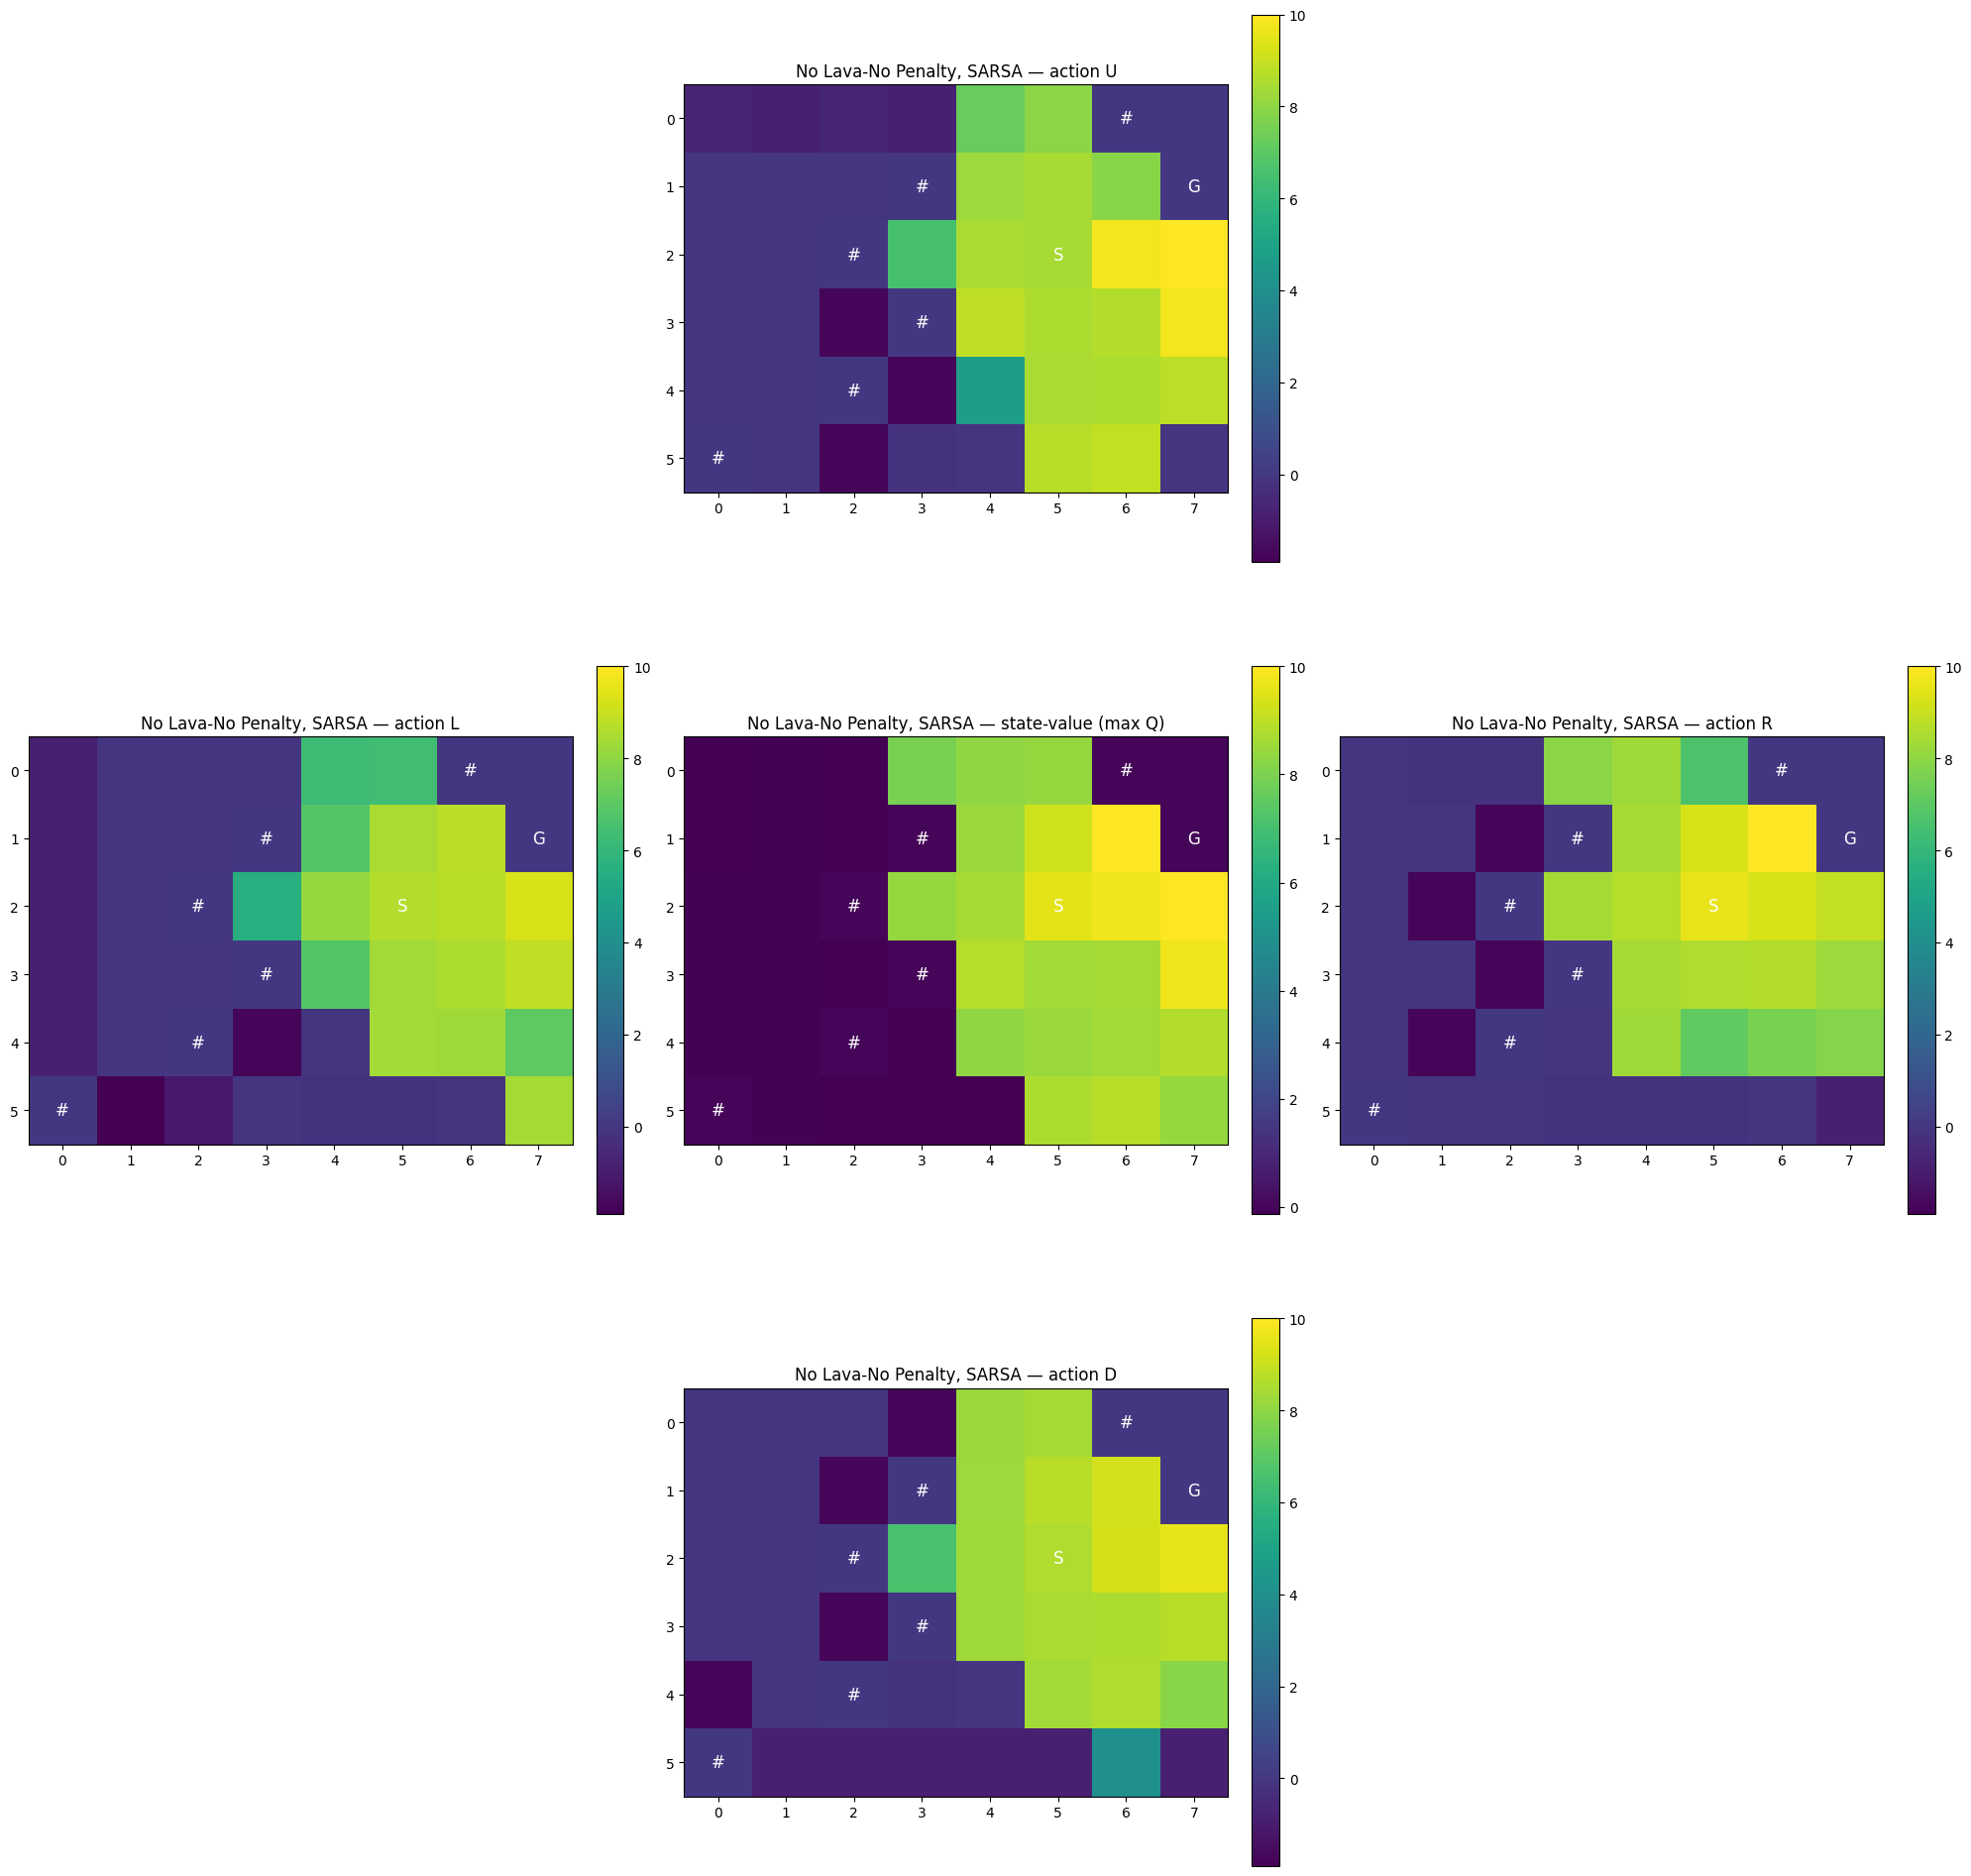

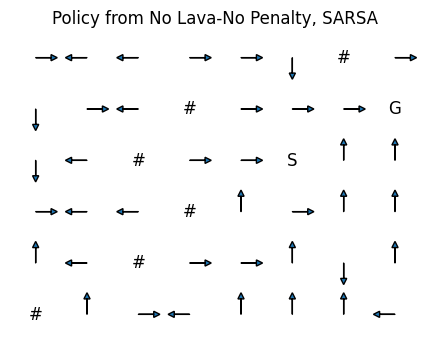

No Lava-With Penalty, Q Learning
. . . . . . # .
. . . # . . . G
. . # . . A . .
. . . # . . . .
. . # . . . . .
# . . . . . . .


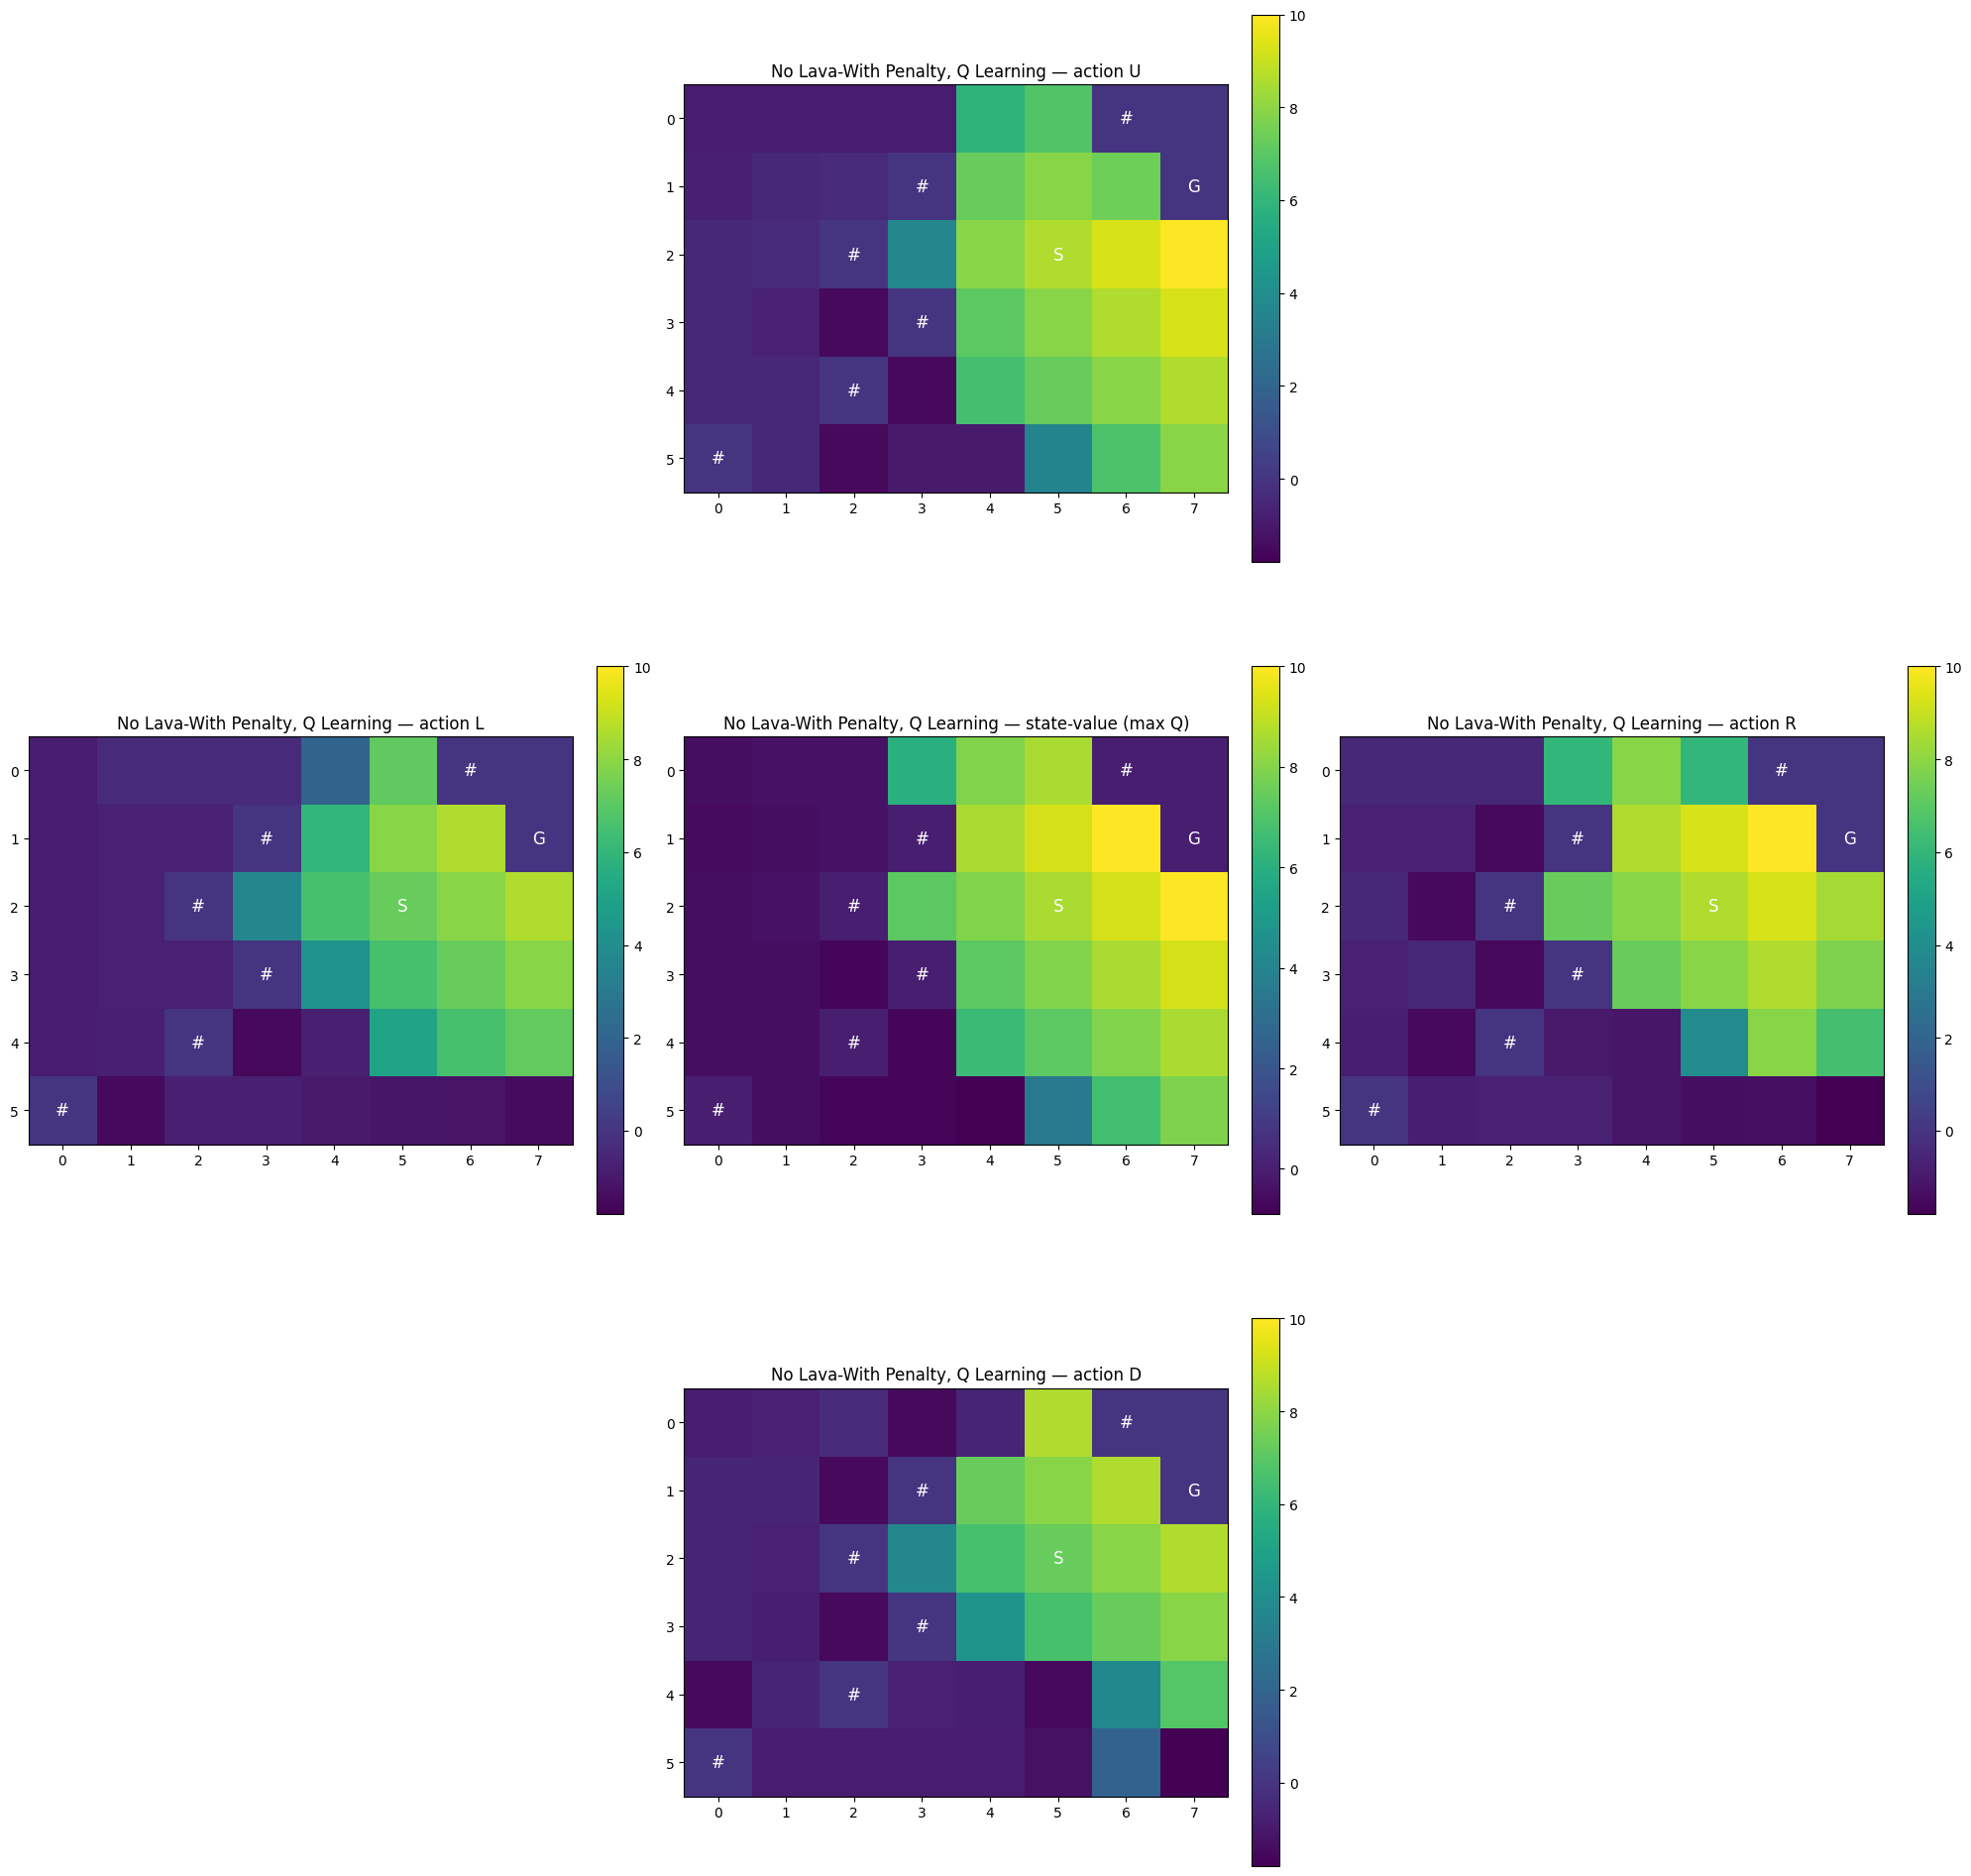

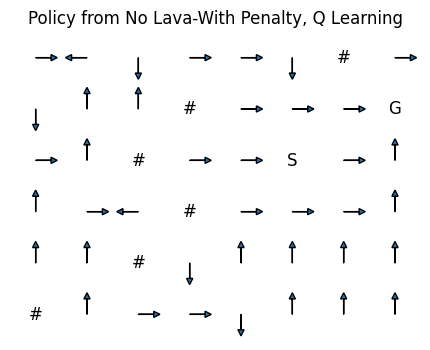

No Lava-With Penalty, SARSA
. . . . . . # .
. . . # . . . G
. . # . . A . .
. . . # . . . .
. . # . . . . .
# . . . . . . .


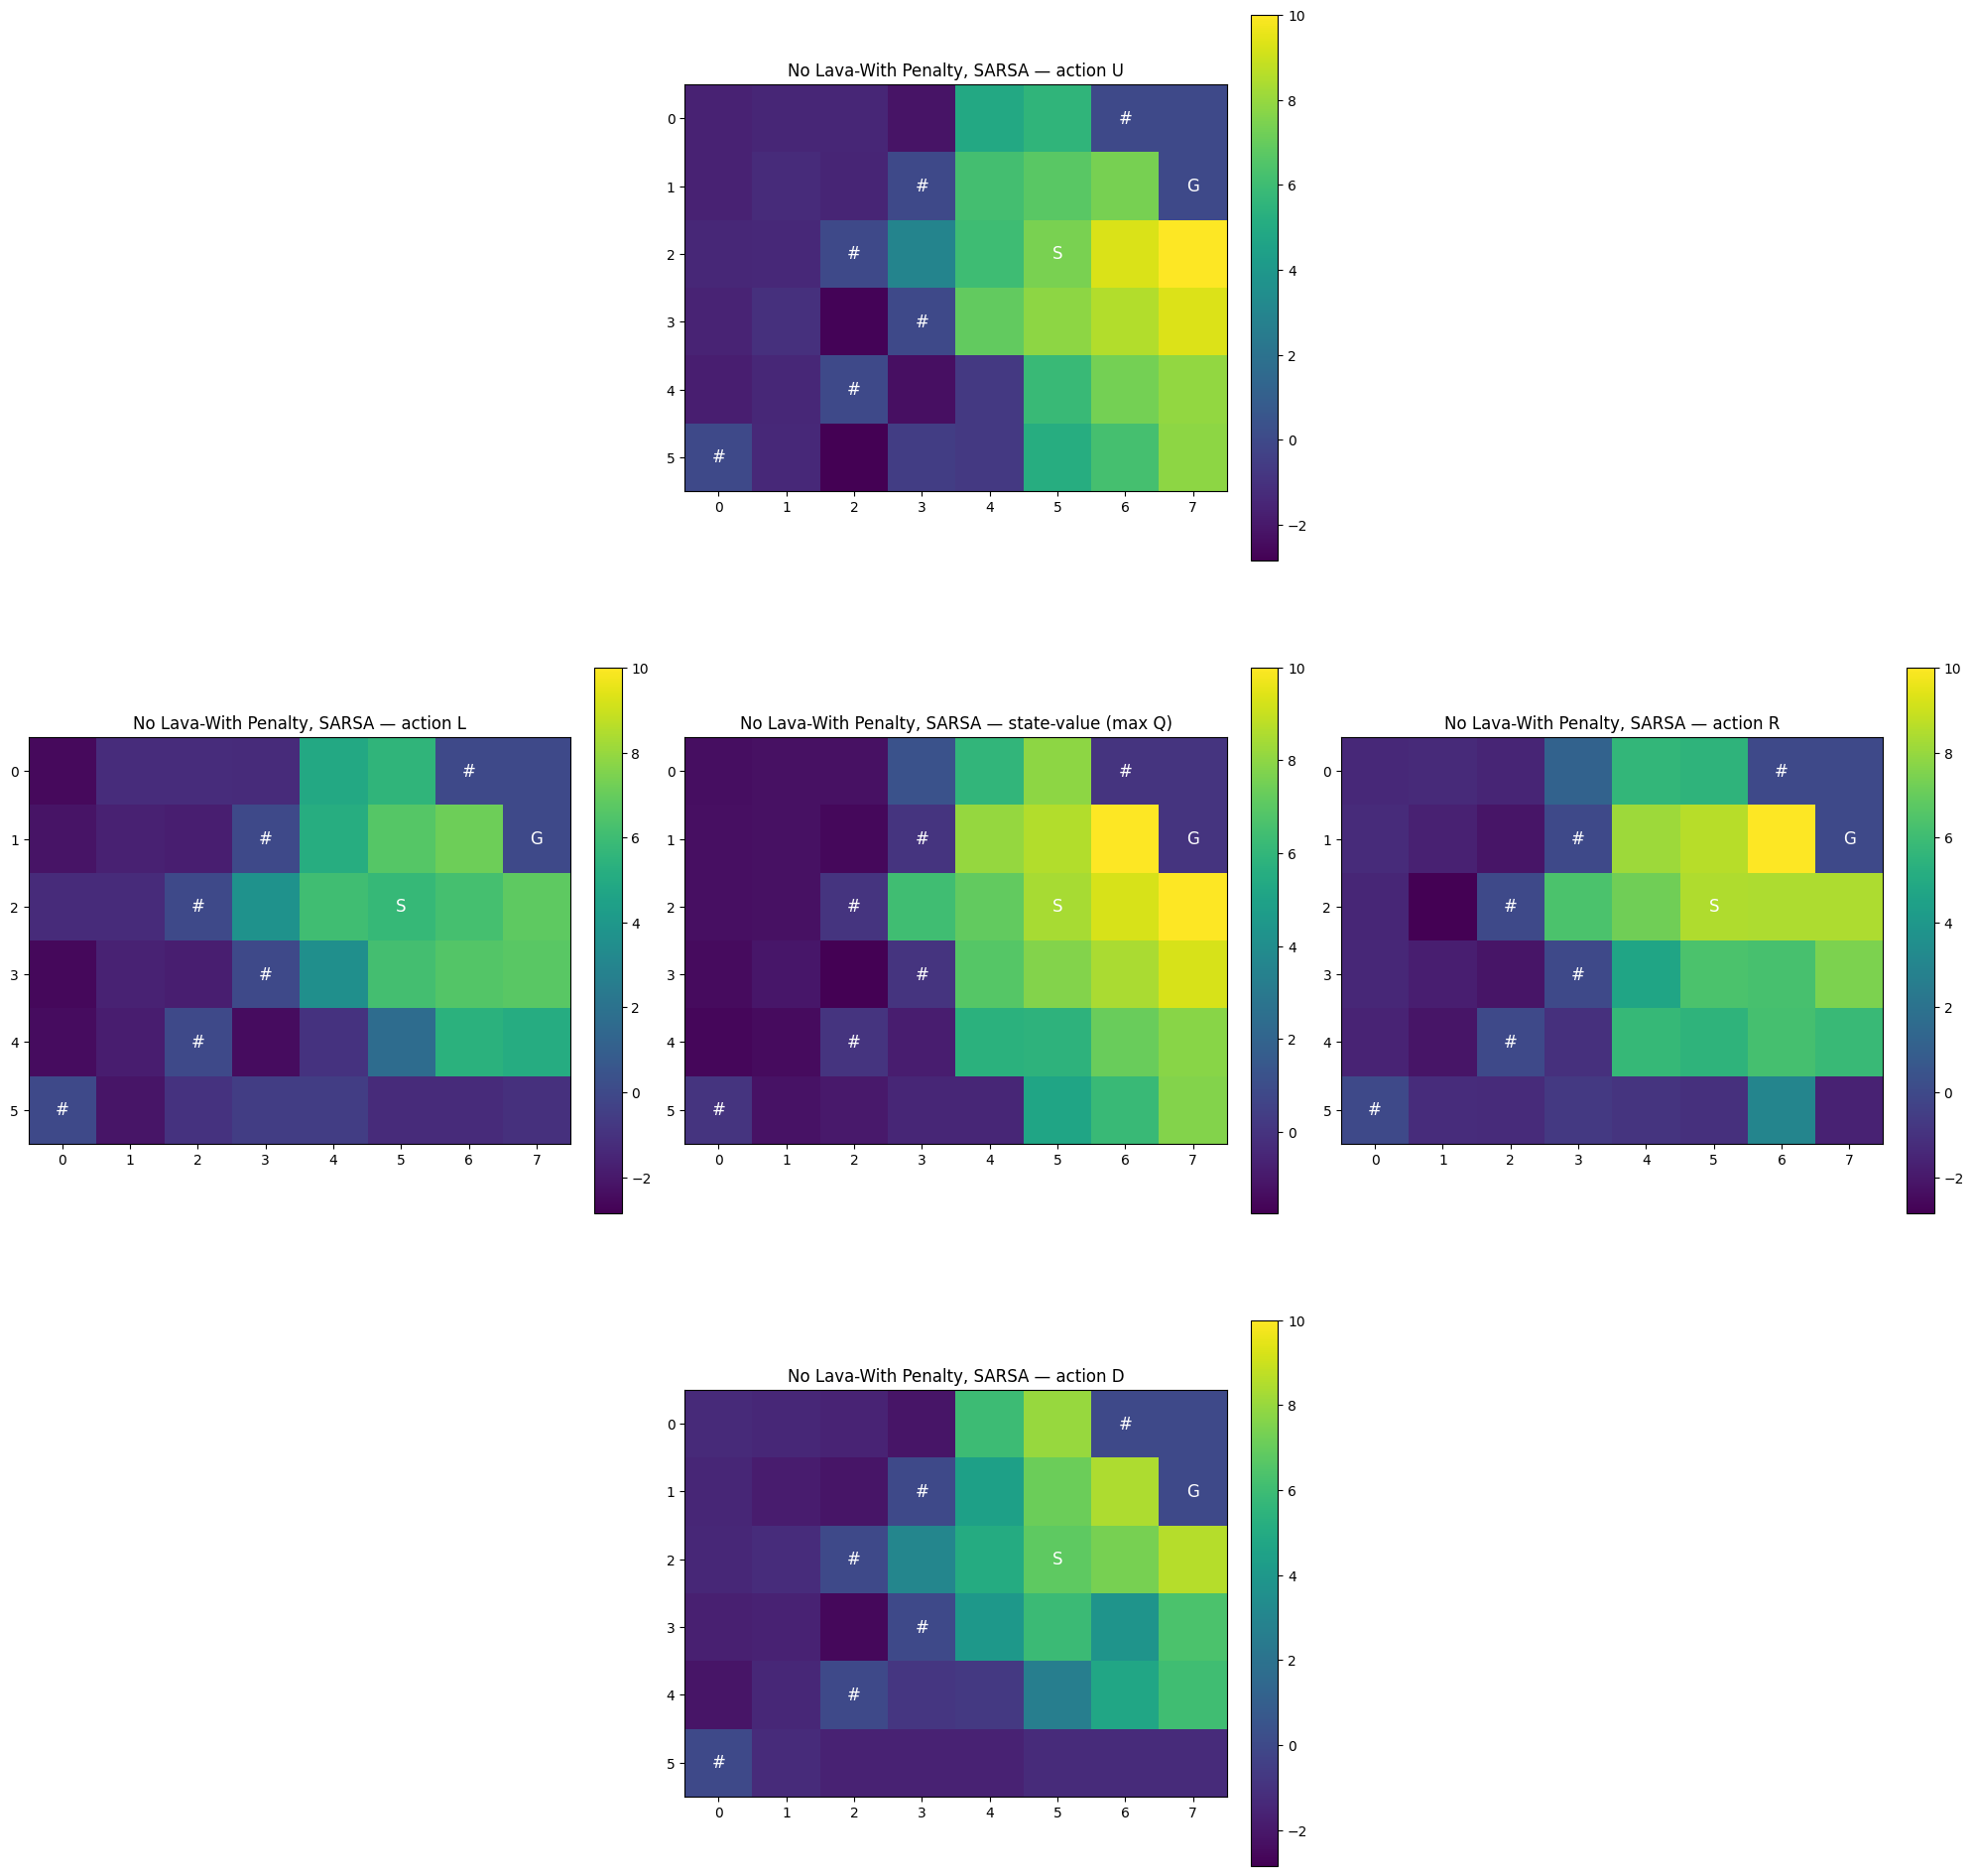

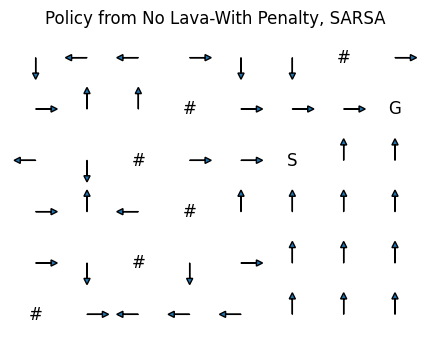

With Lava-No Penalty, Q Learning
. . . A G # L .
. L . . L # . #
. # . . # . . .
. . . # . # # .
. . L . # . . .
# . . # . . . .


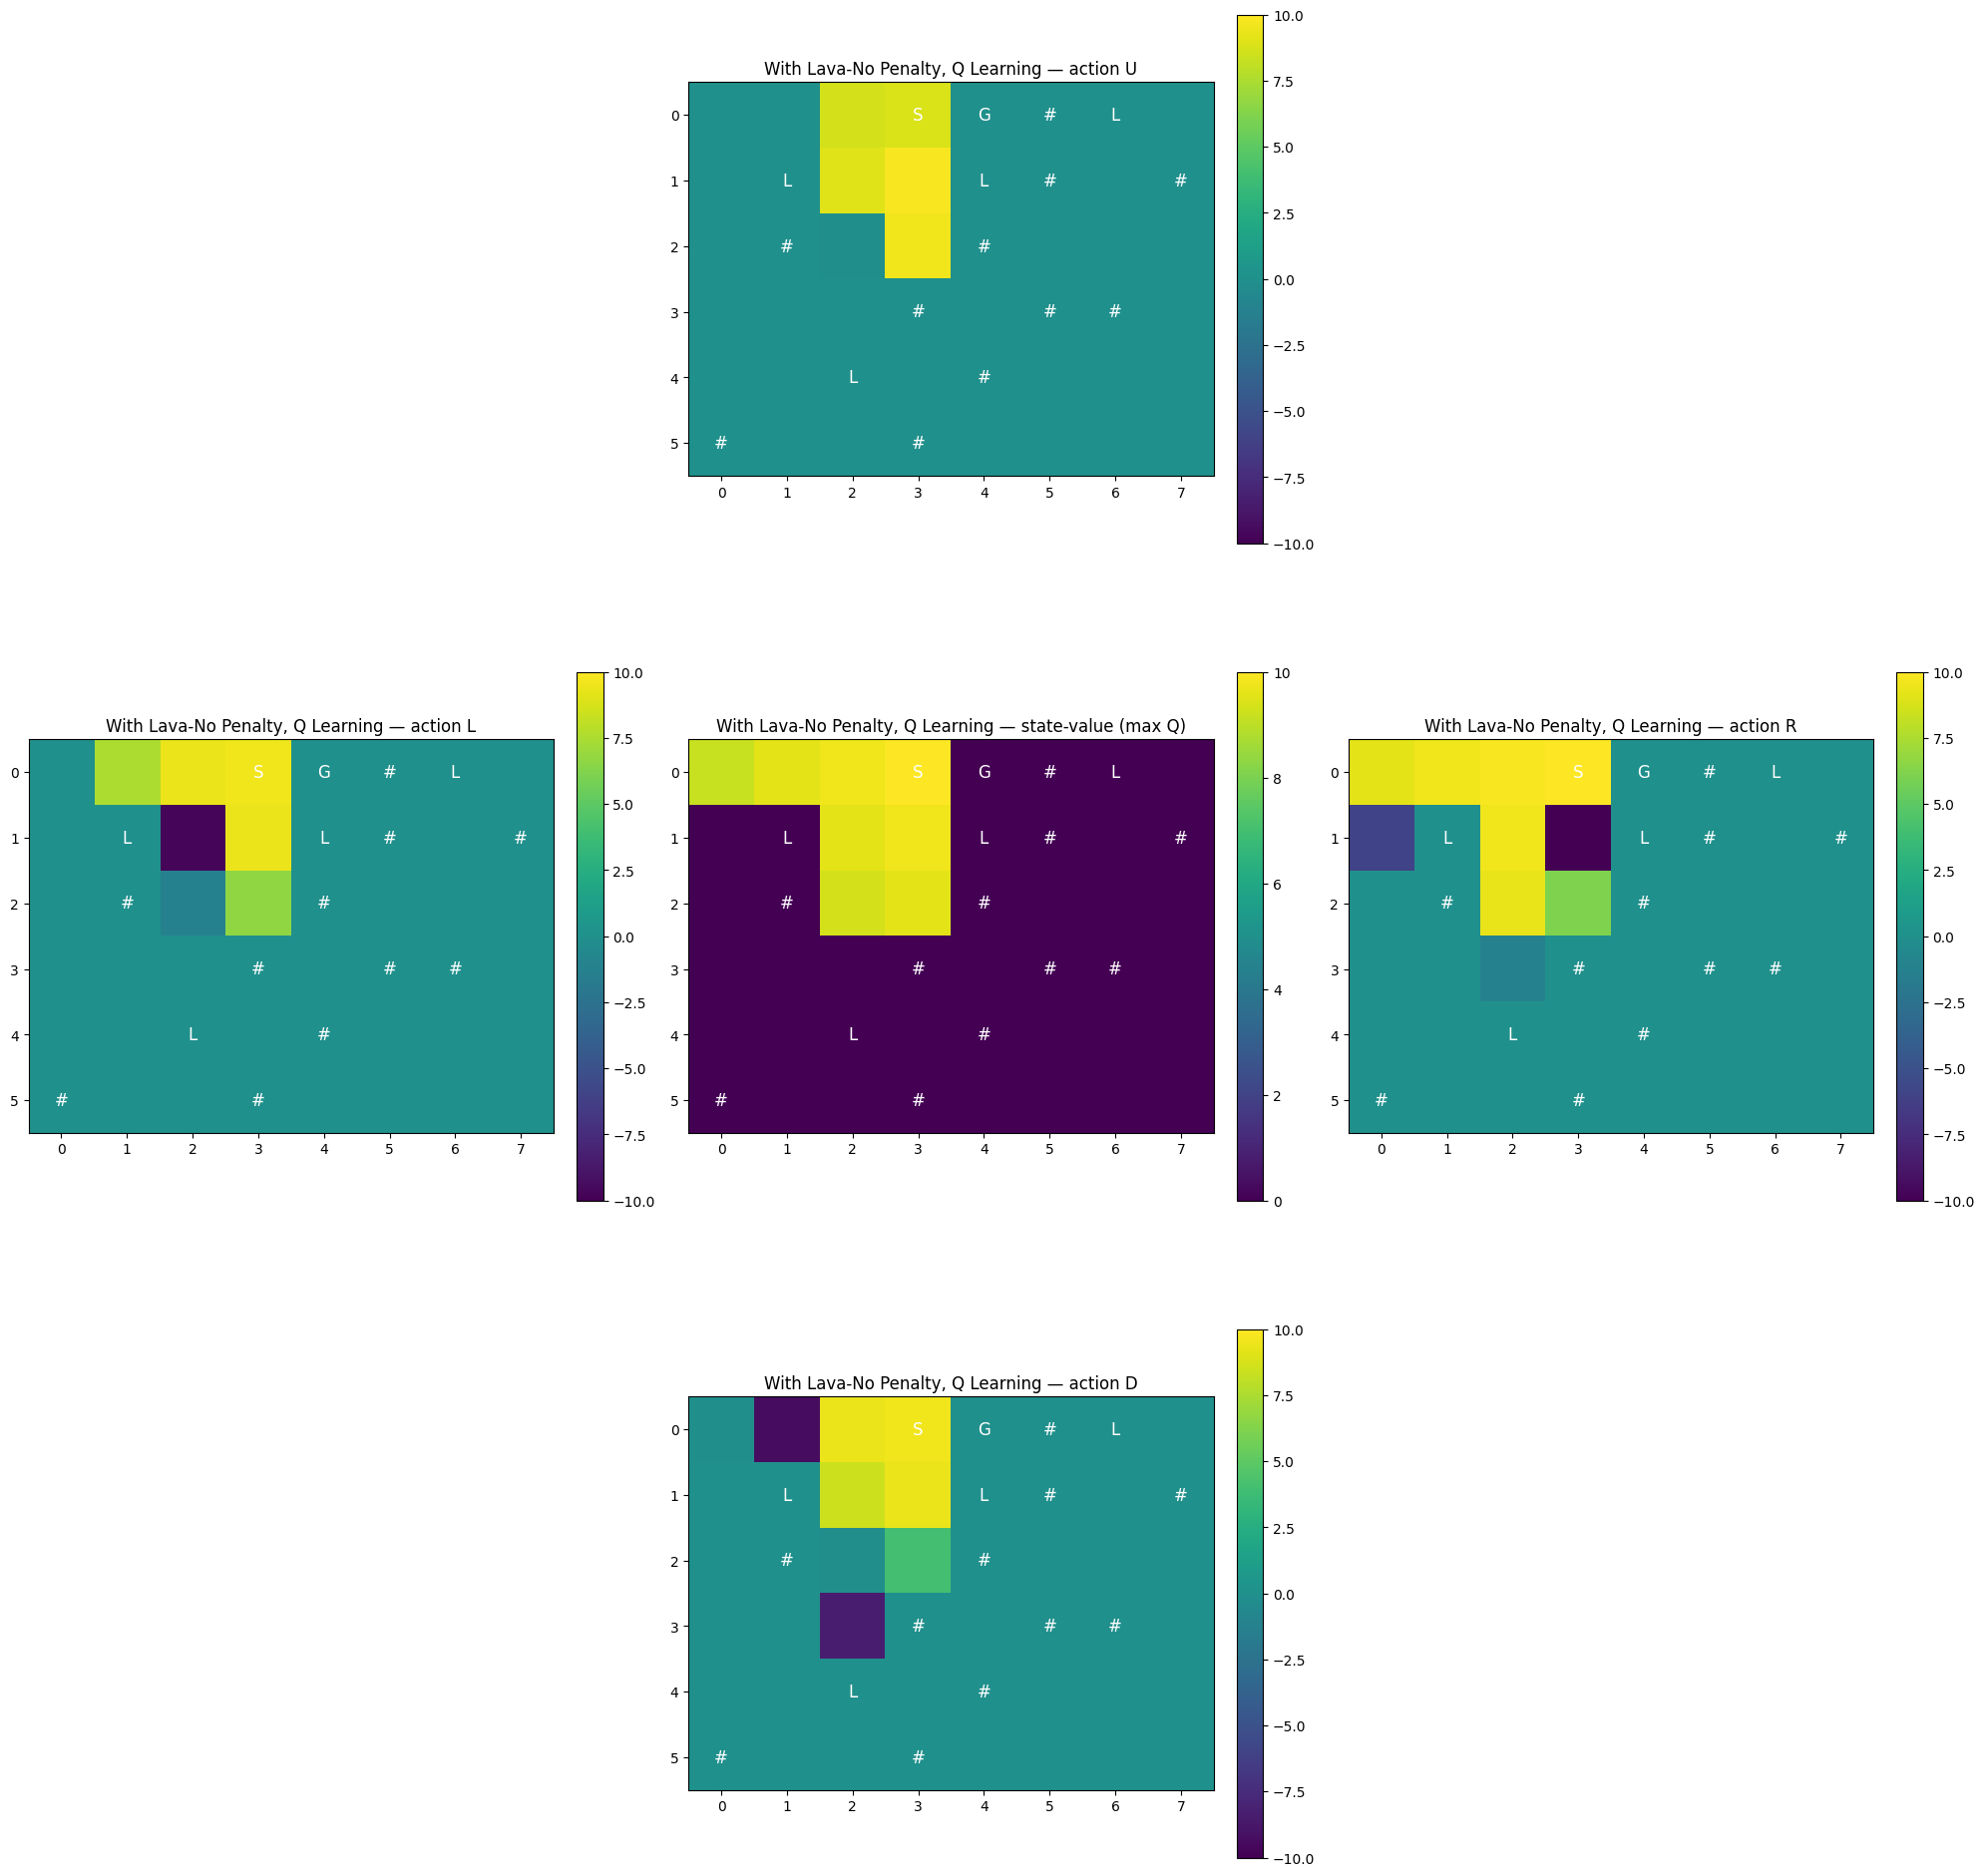

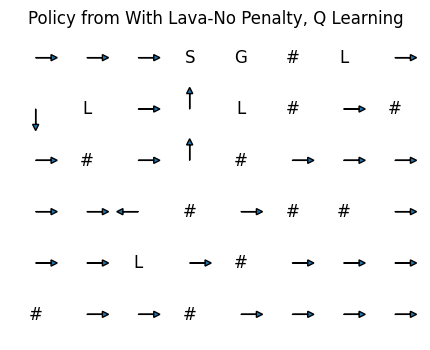

With Lava-No Penalty, SARSA
. . . A G # L .
. L . . L # . #
. # . . # . . .
. . . # . # # .
. . L . # . . .
# . . # . . . .


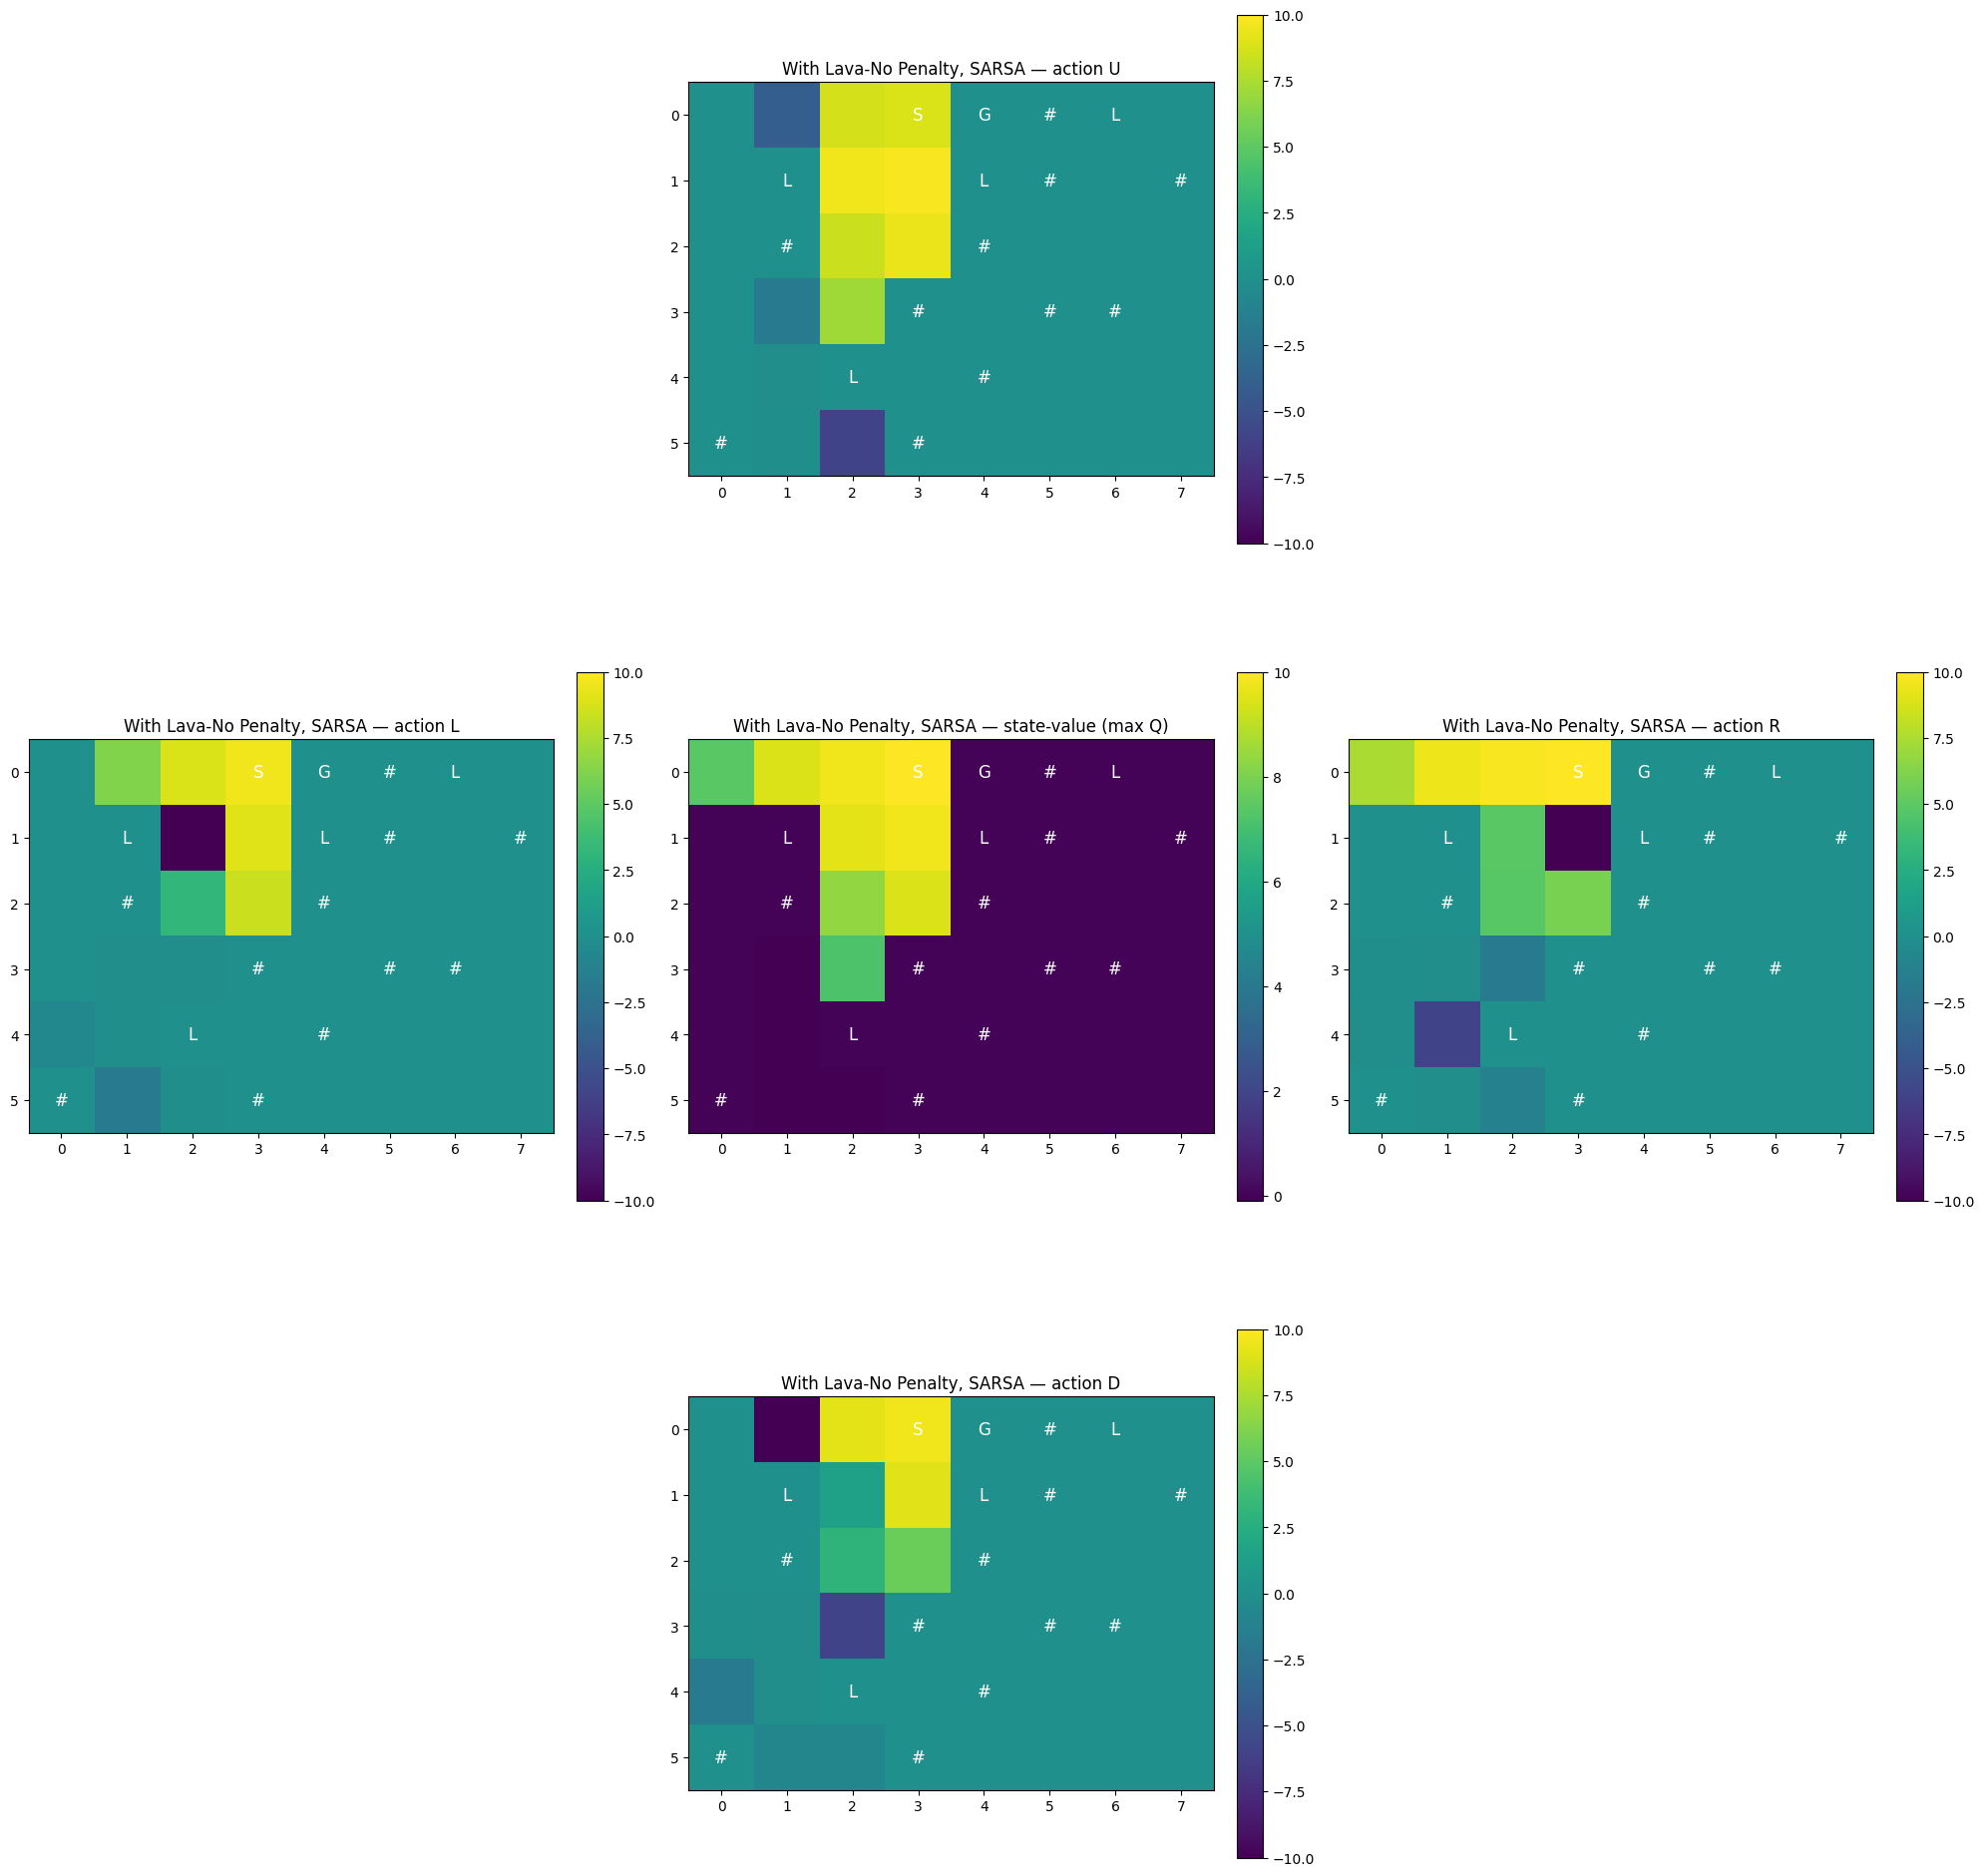

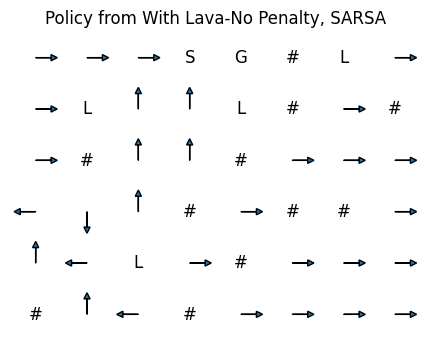

With Lava-No Penalty, Q Learning
. . . A G # L .
. L . . L # . #
. # . . # . . .
. . . # . # # .
. . L . # . . .
# . . # . . . .


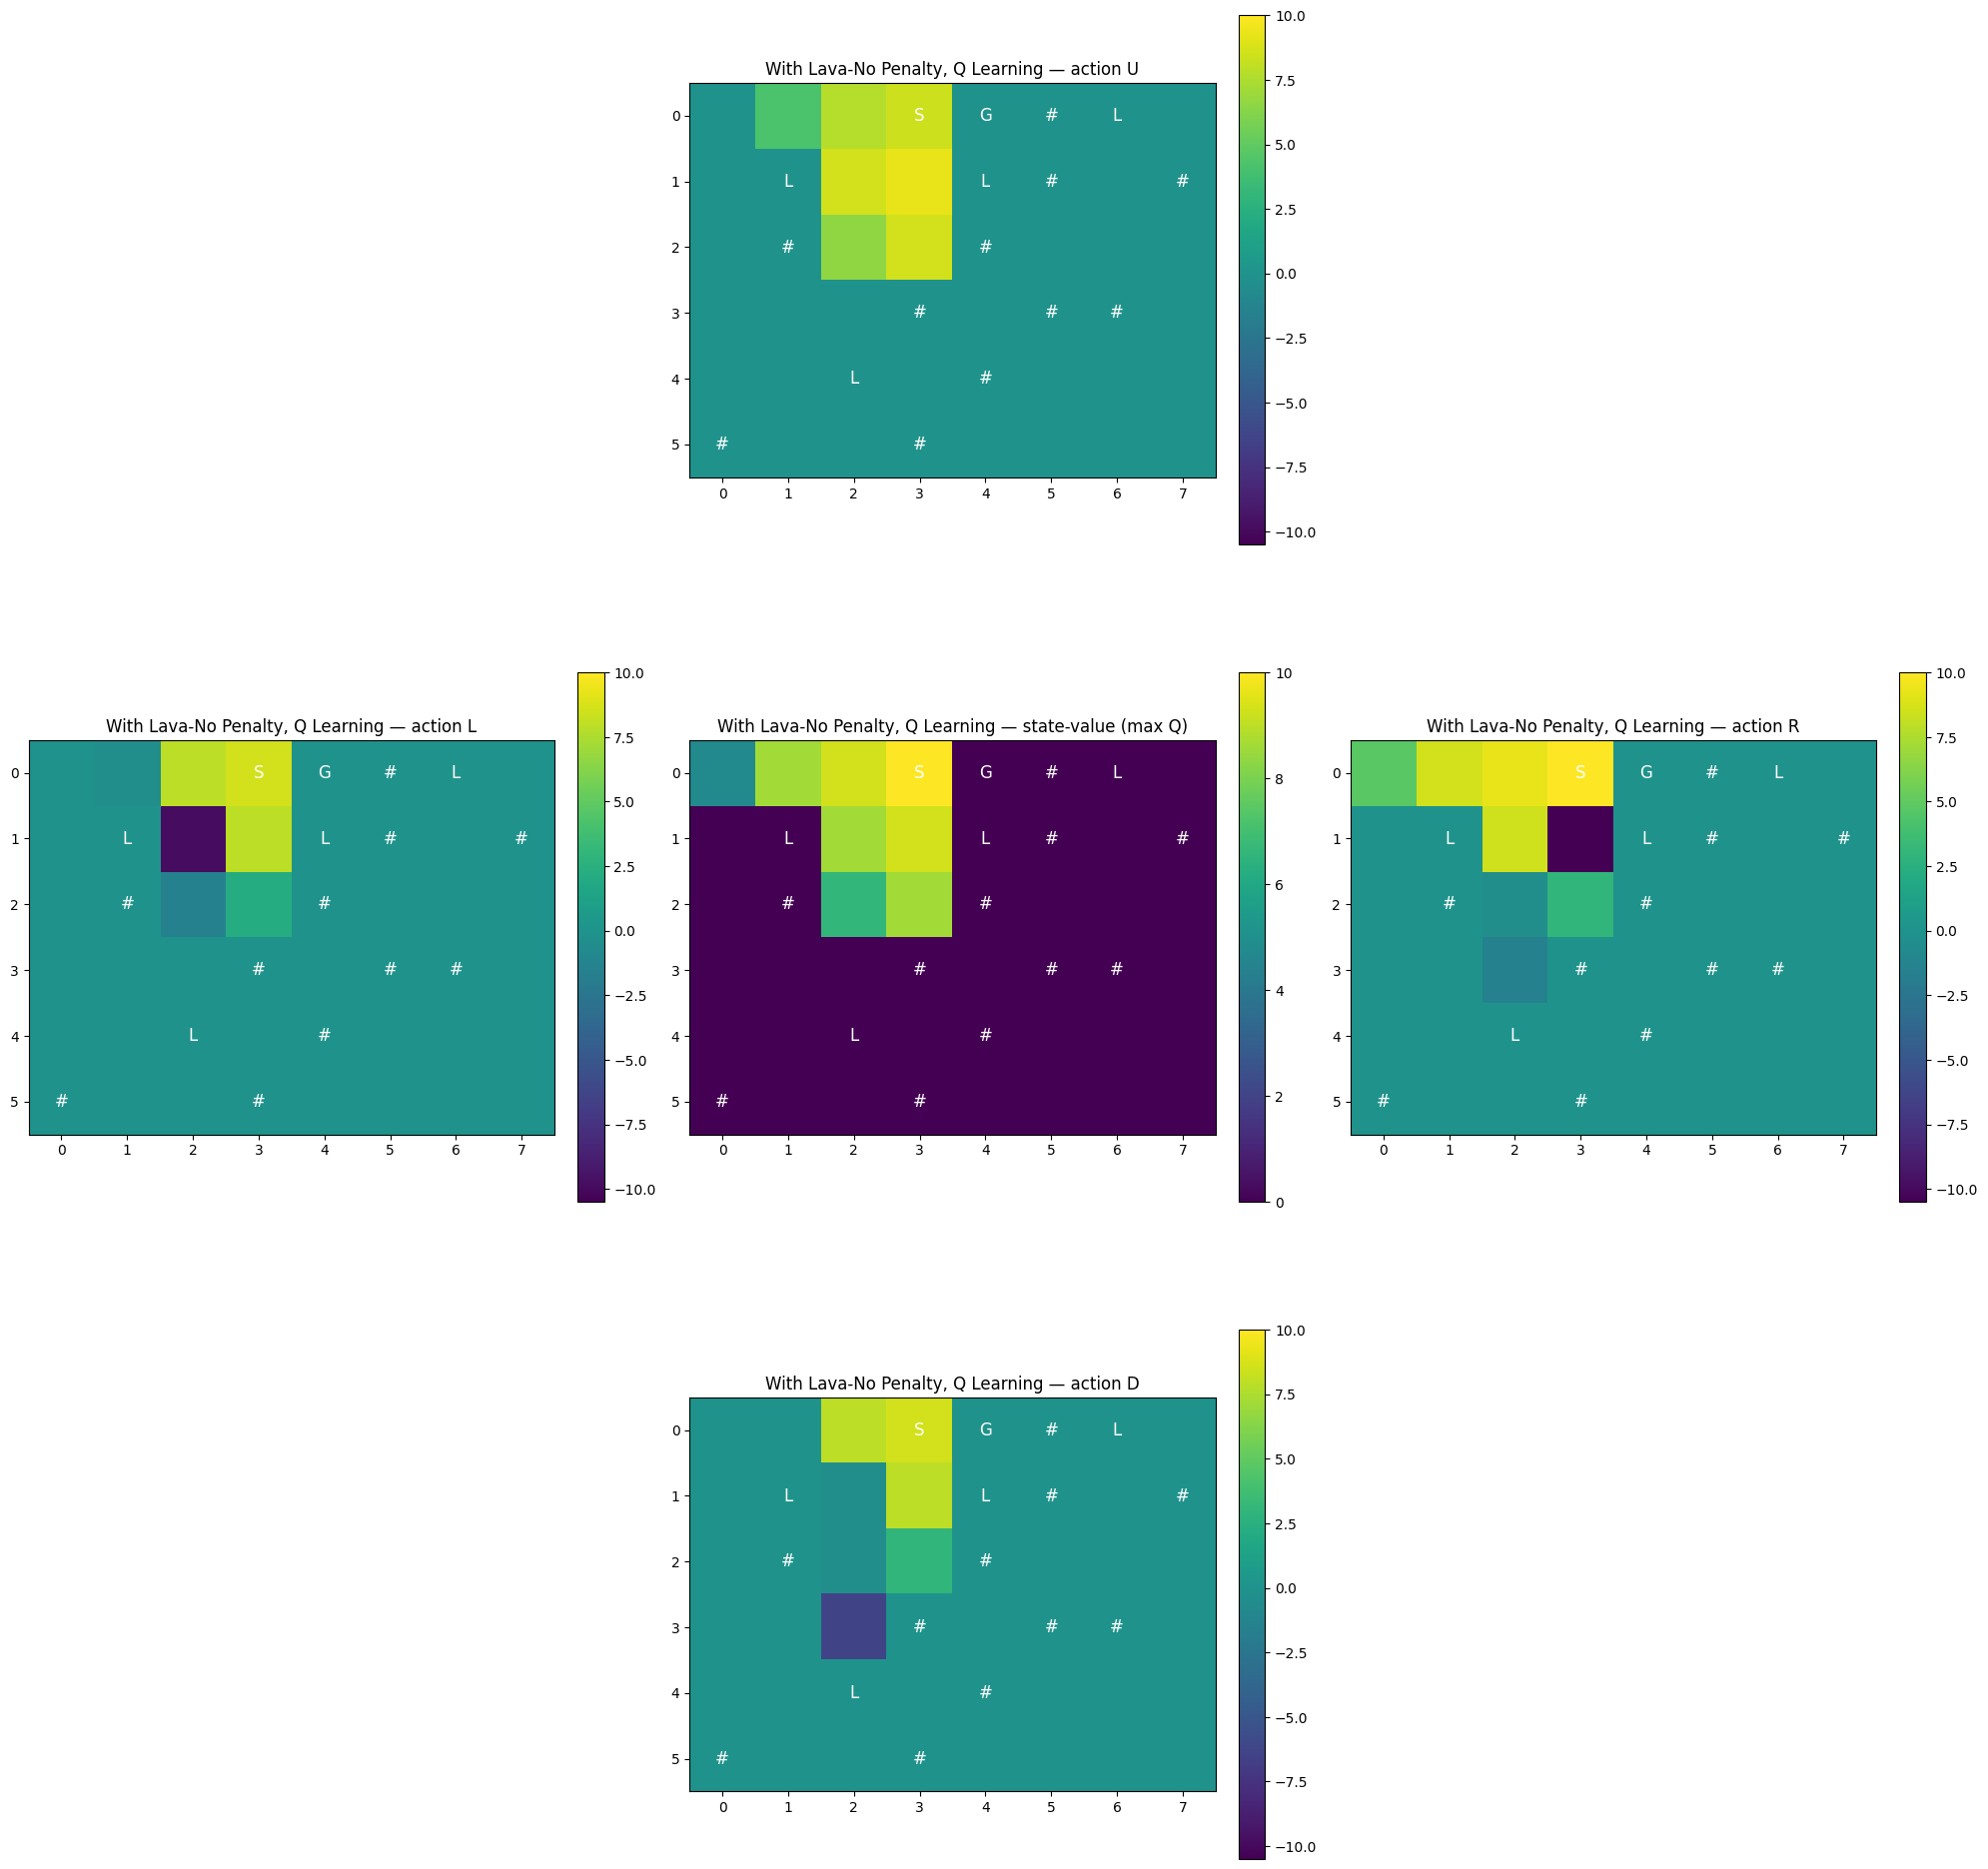

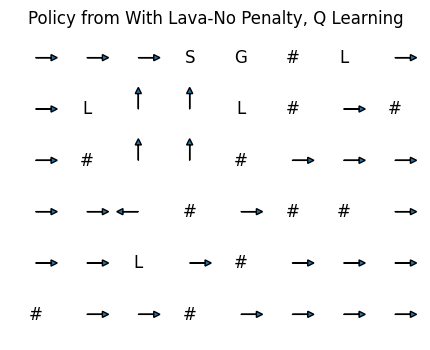

With Lava-With Penalty, SARSA
. . . A G # L .
. L . . L # . #
. # . . # . . .
. . . # . # # .
. . L . # . . .
# . . # . . . .


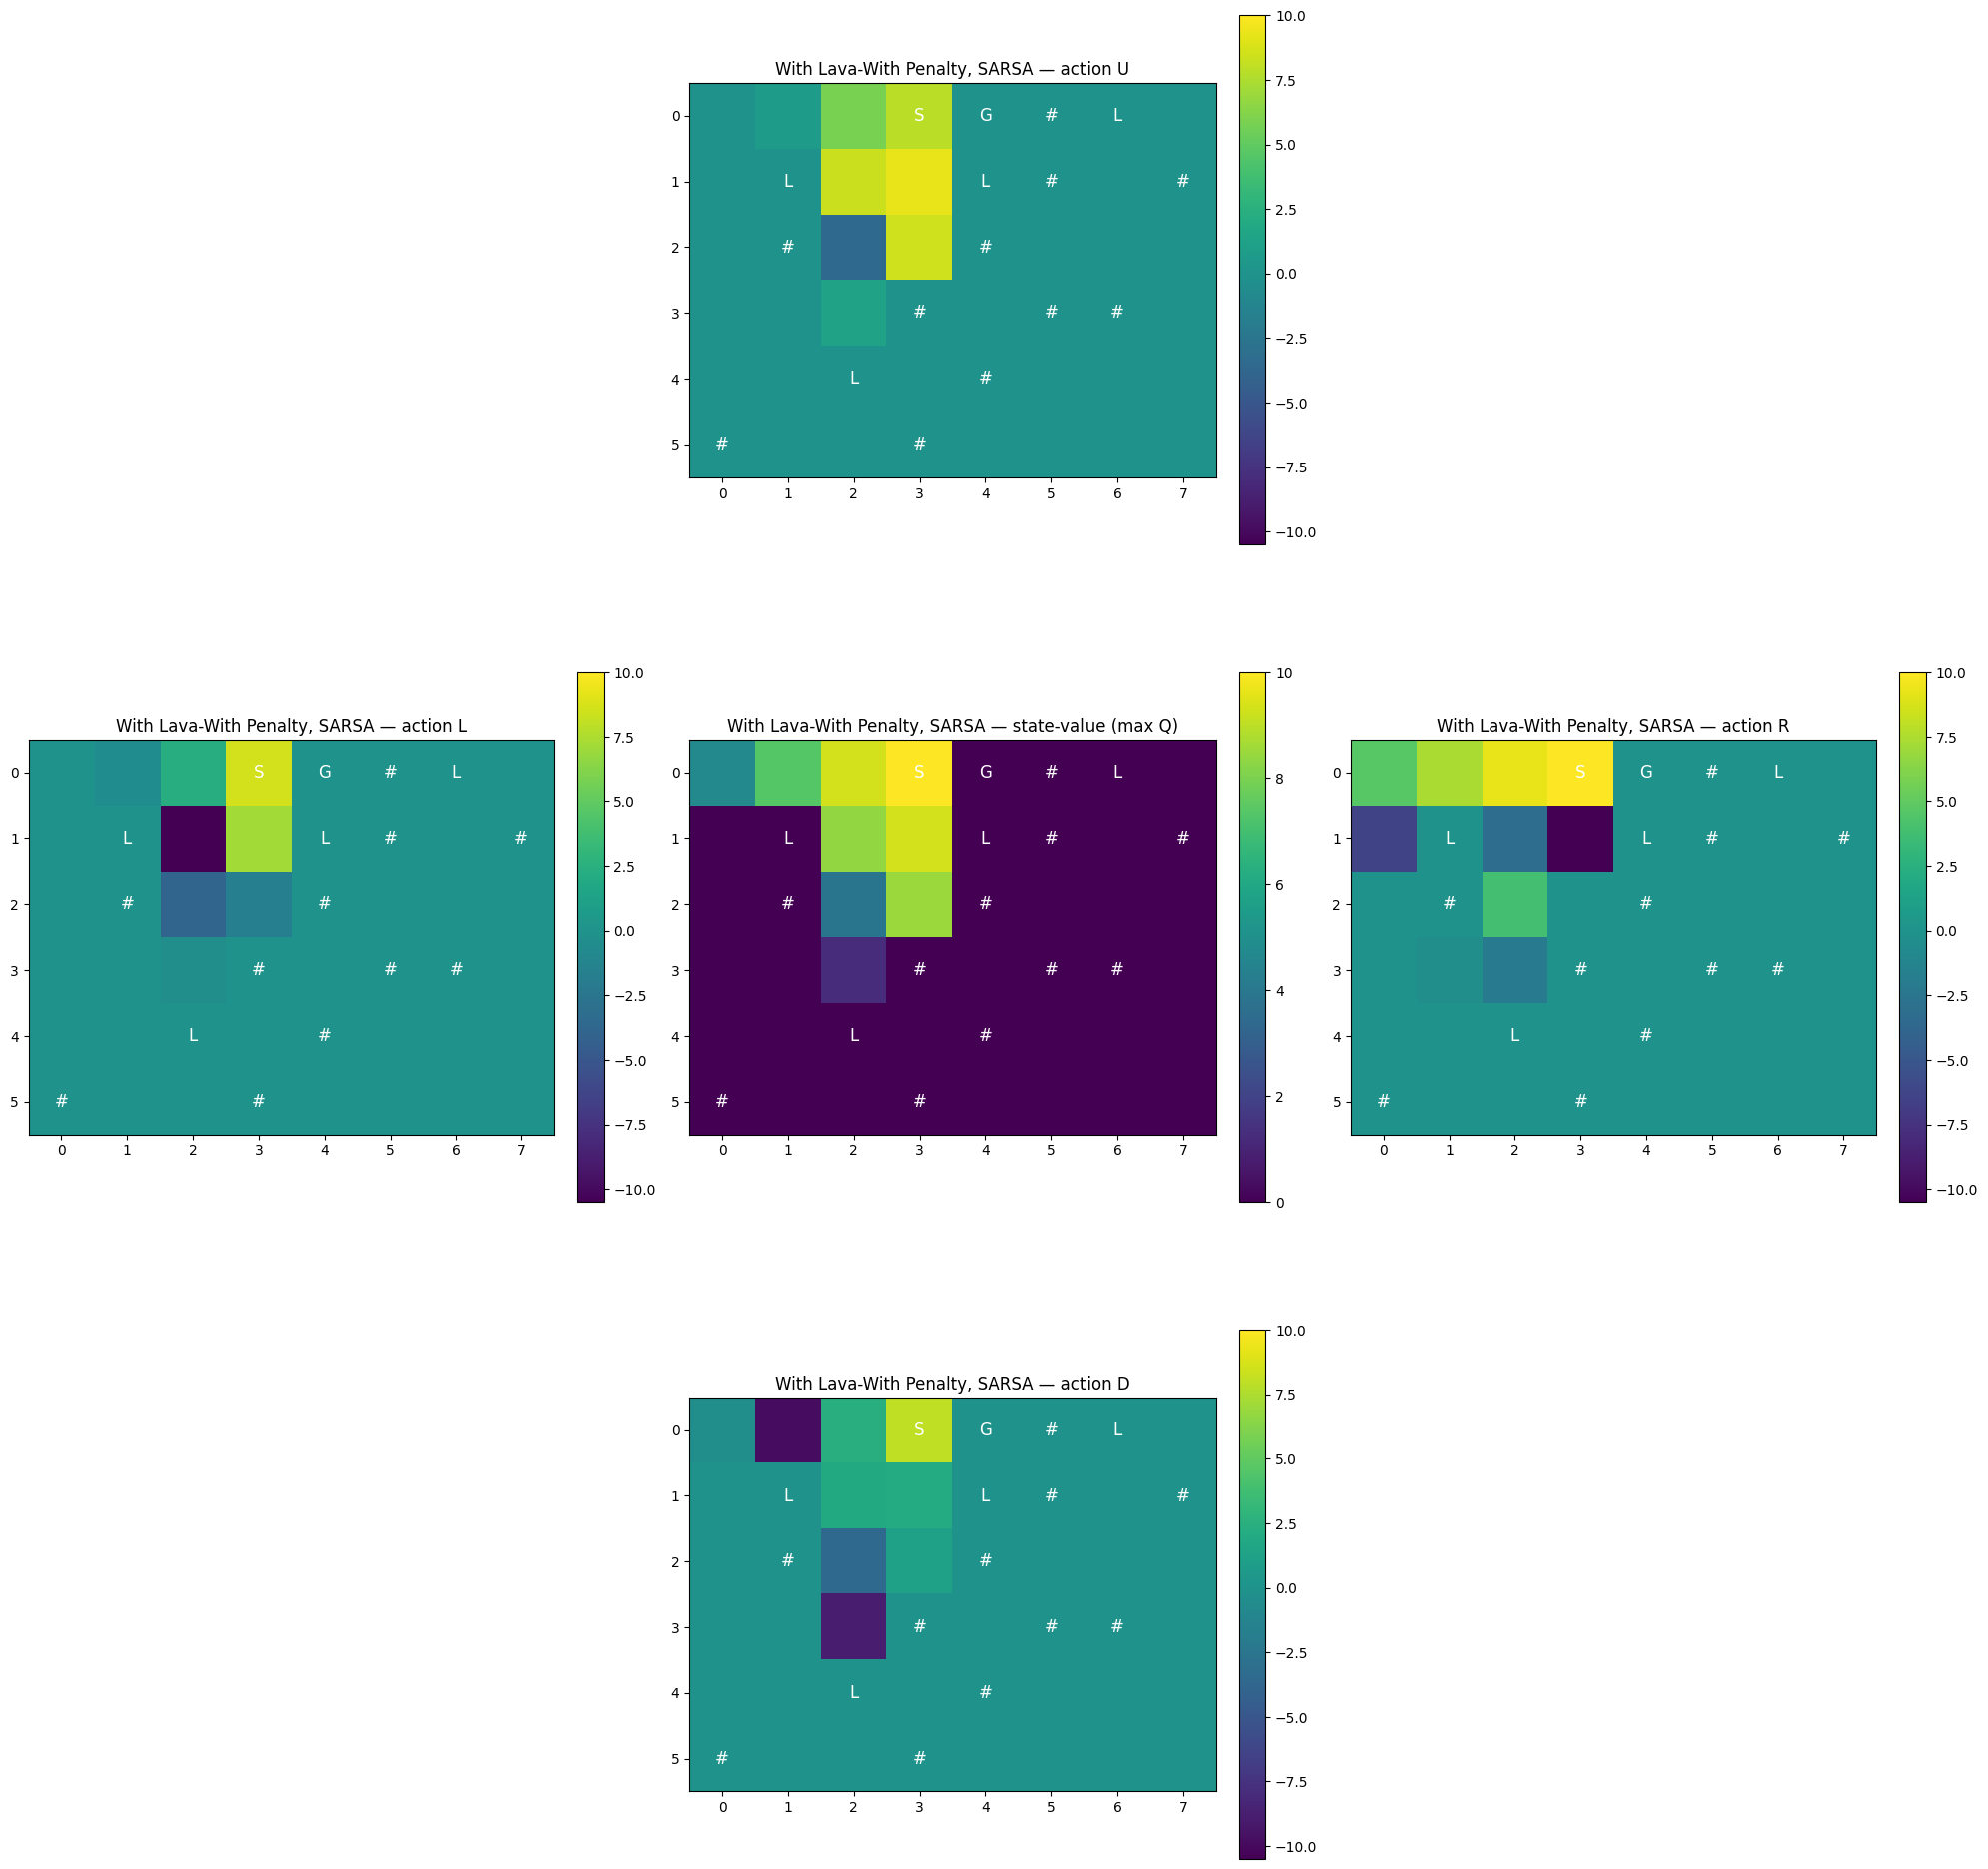

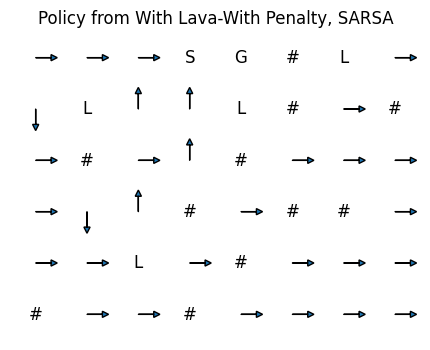

In [7]:
# Demo: try to find an existing trained Q (common names used in this notebook are Qqa, Qqb, Qqc, Q_q, Q_s, etc.)
runs = [(env_a,Qqa,'No Lava-No Penalty, Q Learning'), (env_a,Qsa, 'No Lava-No Penalty, SARSA'), (env_b,Qqb, 'No Lava-With Penalty, Q Learning'),
(env_b,Qsb, 'No Lava-With Penalty, SARSA'), (env_c,Qqc, 'With Lava-No Penalty, Q Learning'), (env_c,Qsc, 'With Lava-No Penalty, SARSA'),
(env_d,Qqd, 'With Lava-No Penalty, Q Learning'), (env_d,Qsd, 'With Lava-With Penalty, SARSA')]

found = None
for run in runs:
    
    env_var = run[0]
    print(run[2])
    env_var.reset()
    env_var.render()
    Q = run[1]
    plot_q_heatmaps(Q, env_var, title_prefix=f'{run[2]}')
    plot_greedy_policy(Q, env_var, title=f'Policy from {run[2]}')


# The effect of randomizing the initial state, and comapring off-policy on-policy algorithms

Grid (A=Agent, G=goal, #=wall, L=lava):
. . . . . . # .
. . . # . . . G
. . # . . A . .
. . . # . . . .
. . # . . . . .
# . . . . . . .
Q-learning success rate: 1.00, avg reward: 9.51
SARSA       success rate: 1.00, avg reward: 9.48


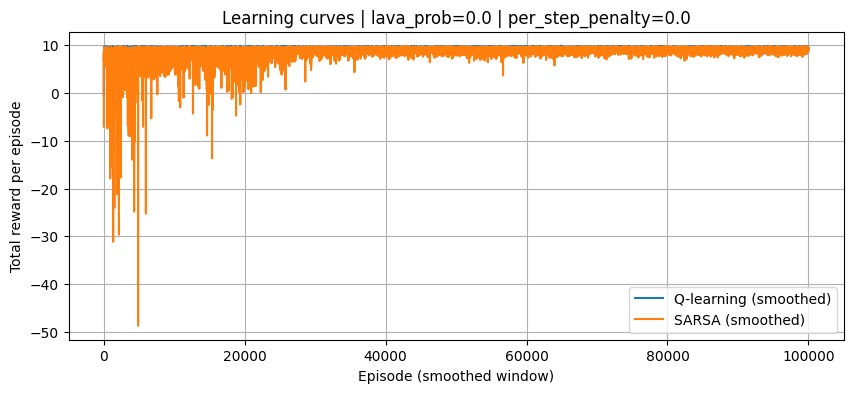

Grid (A=Agent, G=goal, #=wall, L=lava):
. . . . . . # .
. . . # . . . G
. . # . . A . .
. . . # . . . .
. . # . . . . .
# . . . . . . .
Q-learning success rate: 1.00, avg reward: 7.04
SARSA       success rate: 1.00, avg reward: 6.85


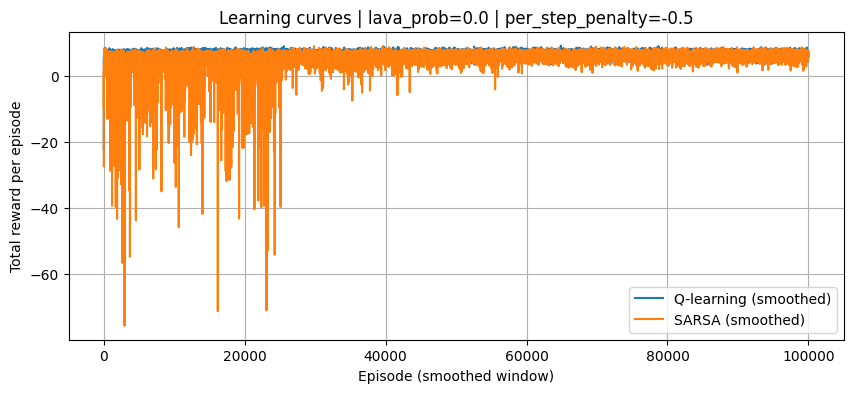

Grid (A=Agent, G=goal, #=wall, L=lava):
. . . A G # L .
. L . . L # . #
. # . . # . . .
. . . # . # # .
. . L . # . . .
# . . # . . . .
Q-learning success rate: 0.47, avg reward: -16.87
SARSA       success rate: 0.27, avg reward: -73.83


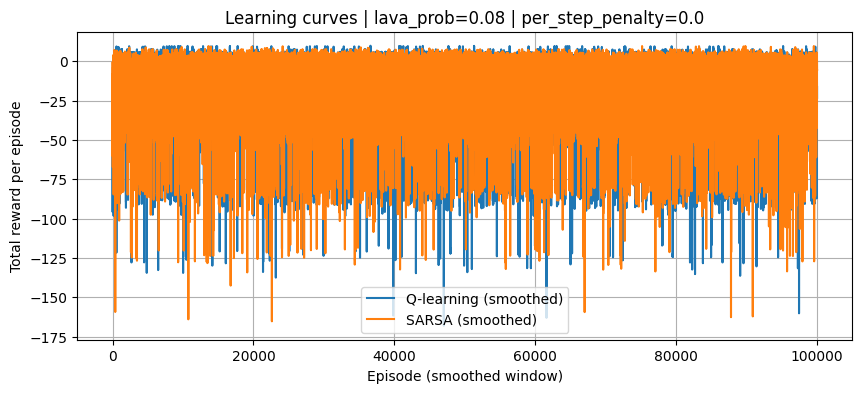

Grid (A=Agent, G=goal, #=wall, L=lava):
. . . A G # L .
. L . . L # . #
. # . . # . . .
. . . # . # # .
. . L . # . . .
# . . # . . . .
Q-learning success rate: 0.47, avg reward: -17.62
SARSA       success rate: 0.55, avg reward: -23.52


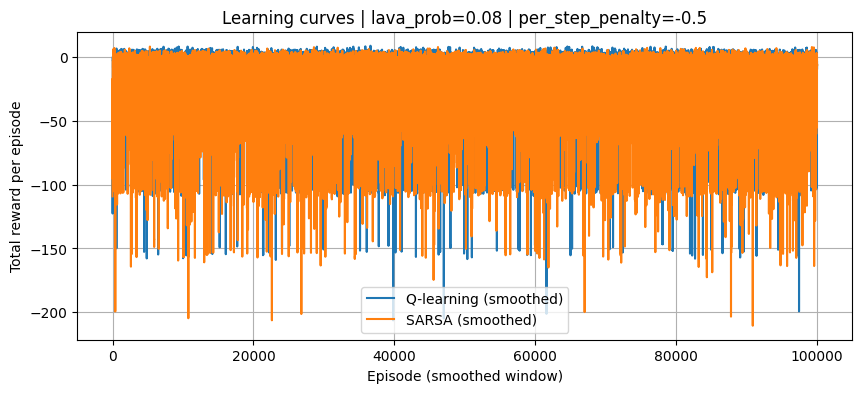

No Lava-No Penalty, Q Learning
. . . . . . # .
A . . # . . . G
. . # . . S . .
. . . # . . . .
. . # . . . . .
# . . . . . . .


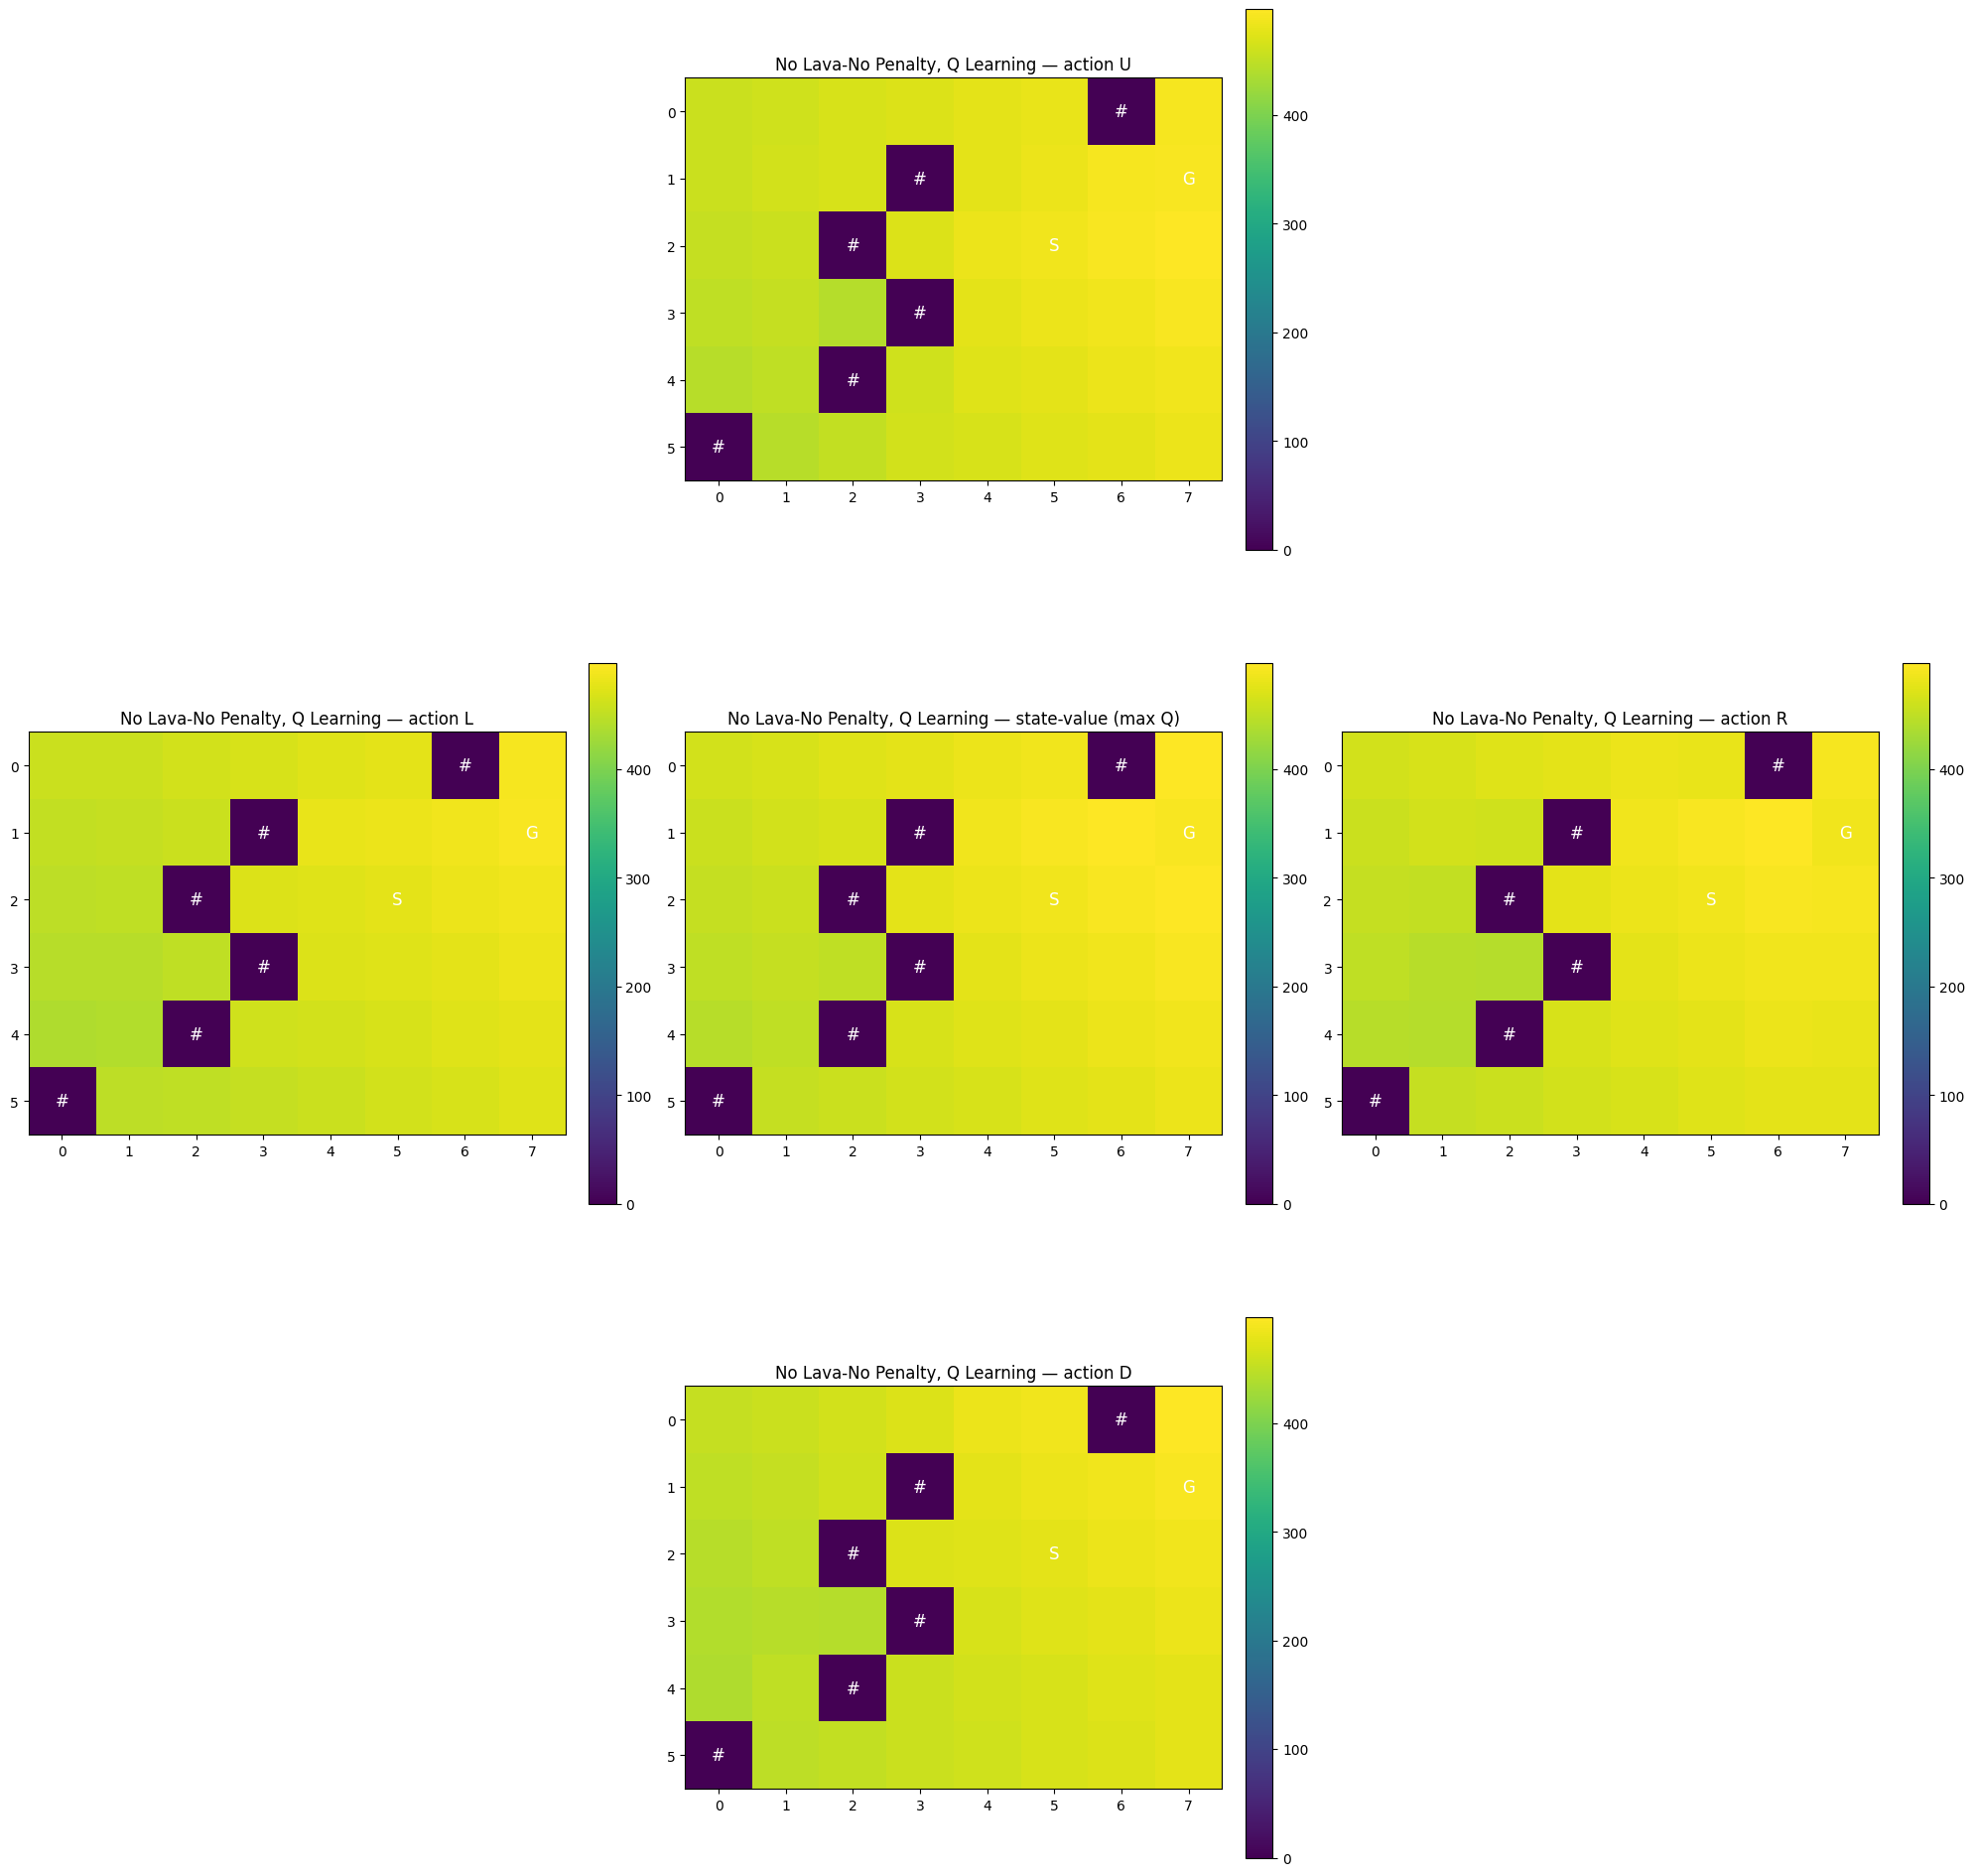

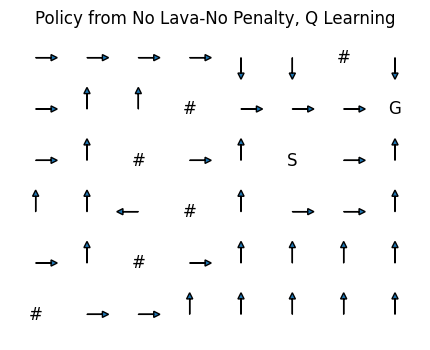

No Lava-No Penalty, SARSA
. . . . . . # .
. . . # . . . G
. . # . . S . .
. . . # A . . .
. . # . . . . .
# . . . . . . .


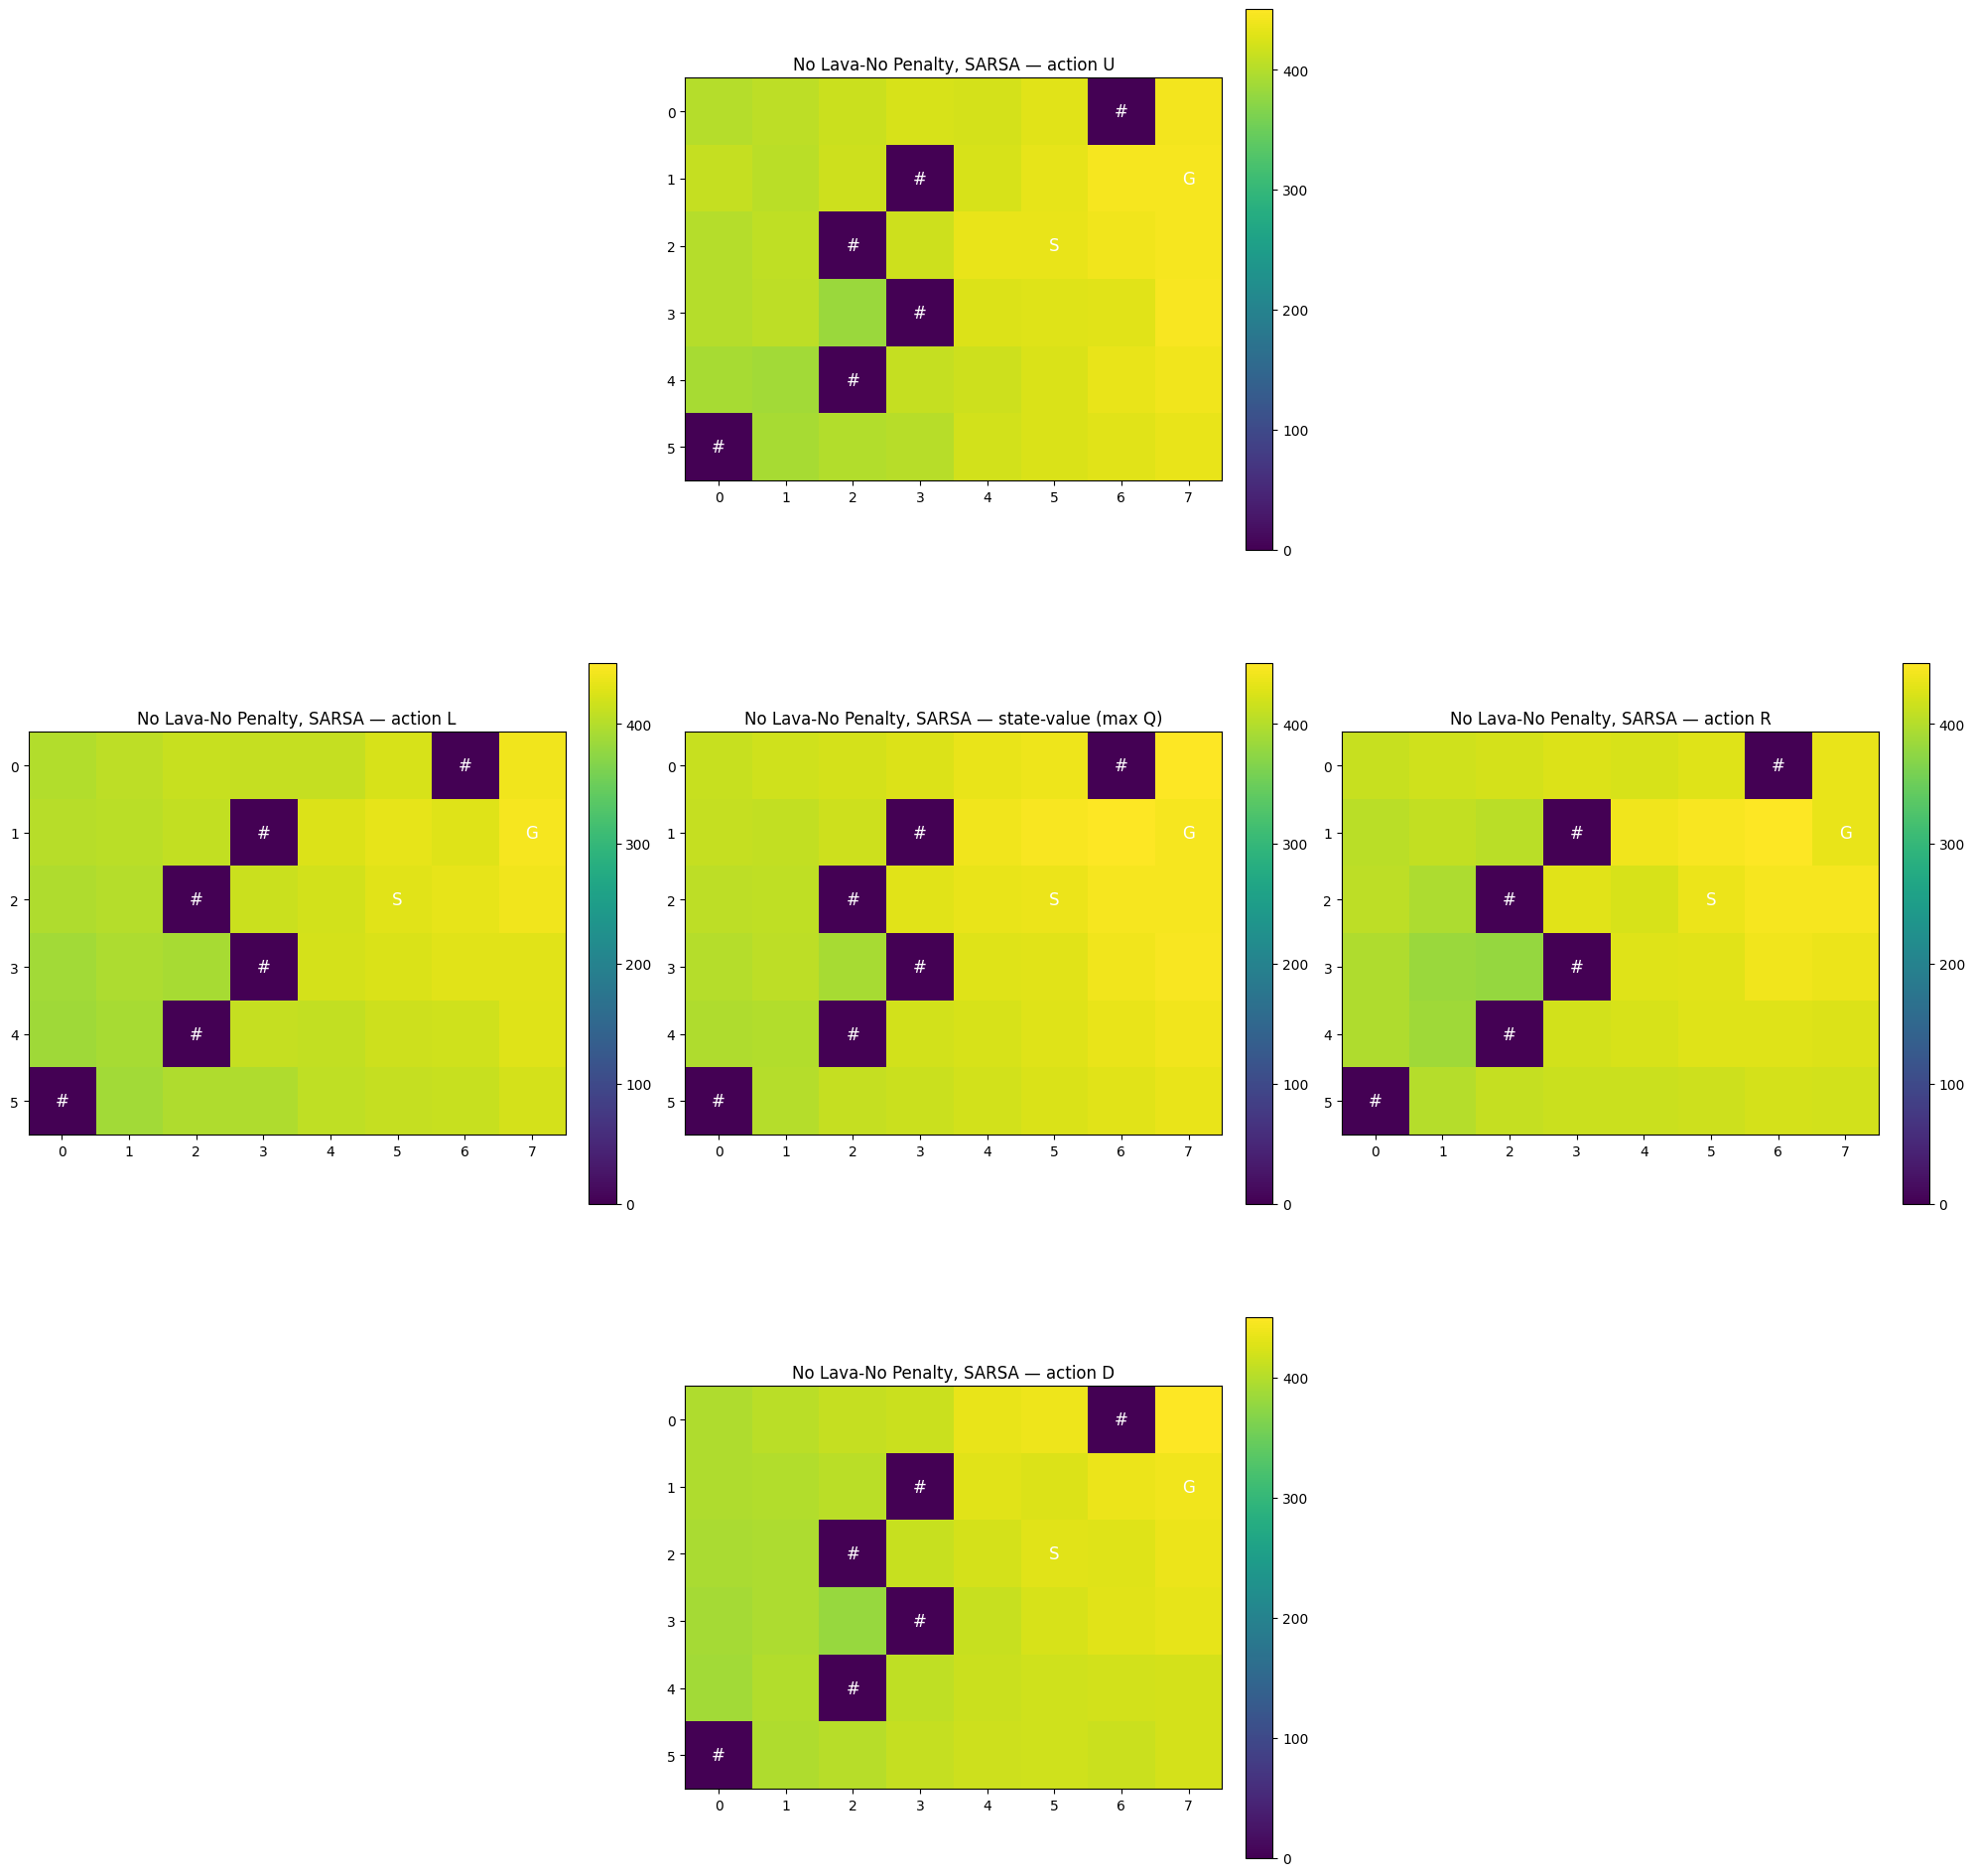

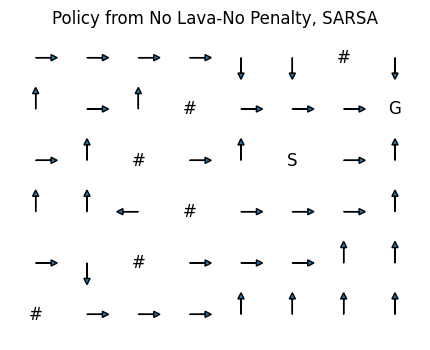

No Lava-With Penalty, Q Learning
. . . . . . # .
A . . # . . . G
. . # . . S . .
. . . # . . . .
. . # . . . . .
# . . . . . . .


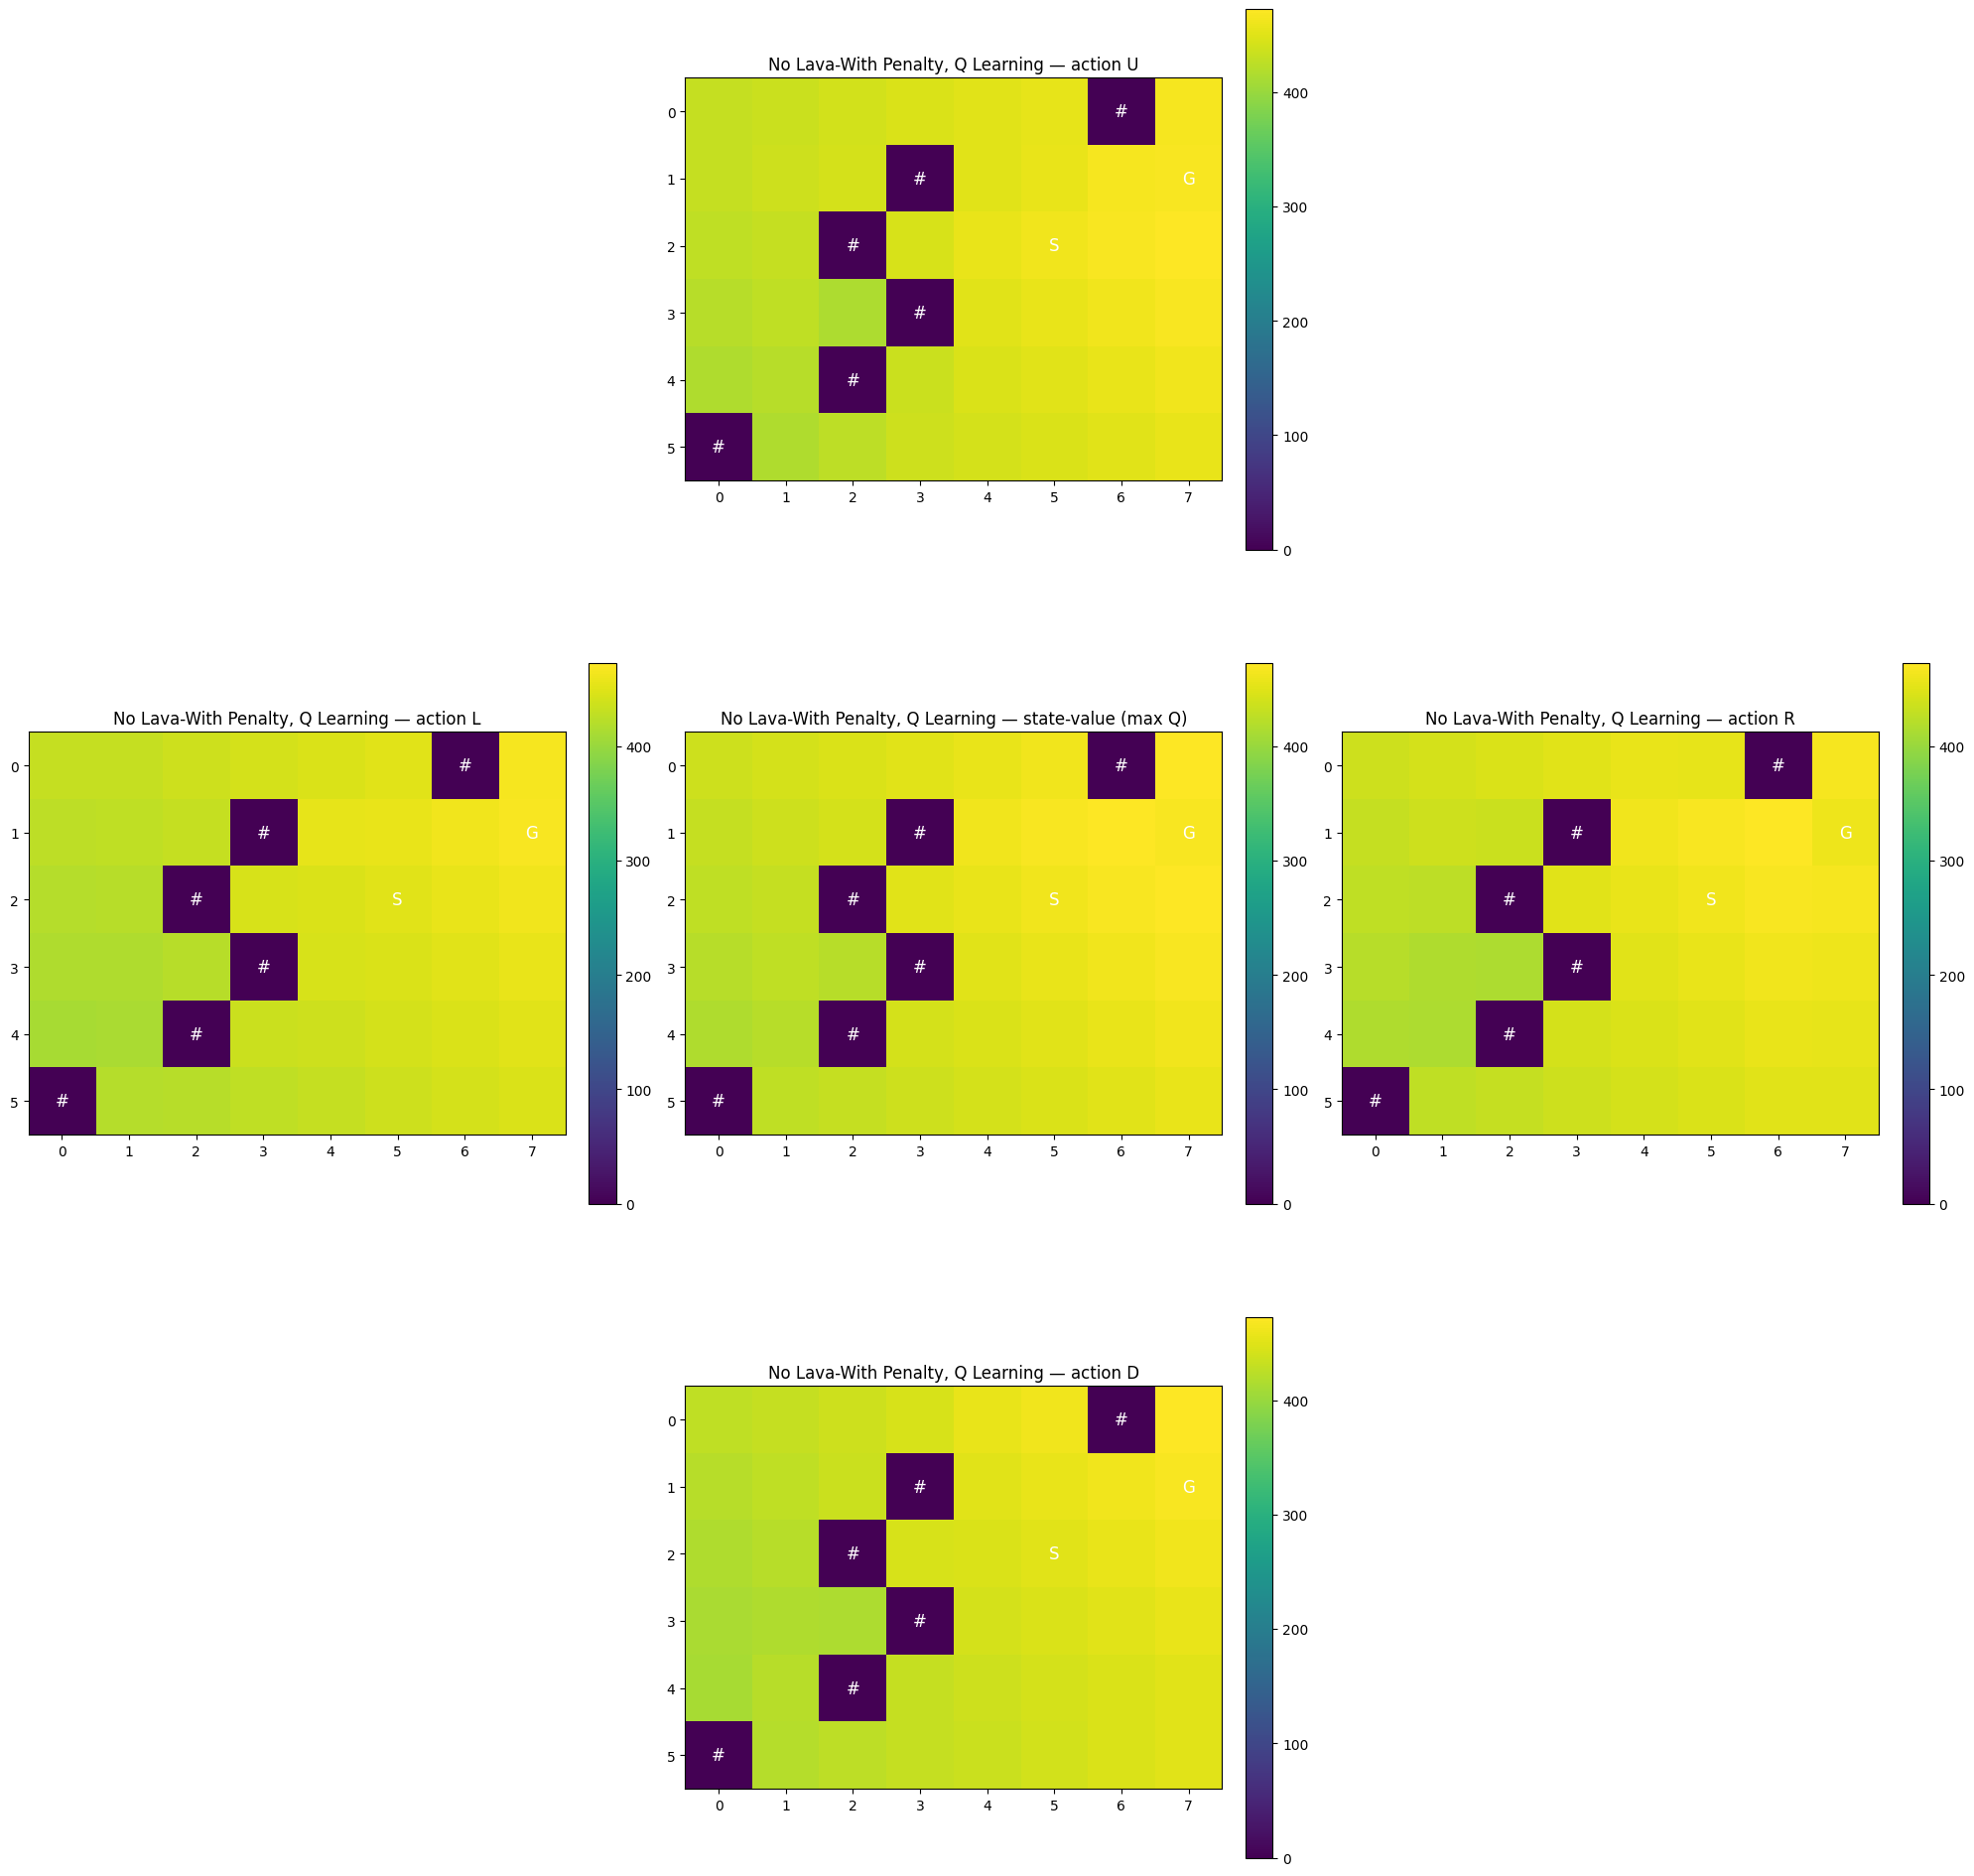

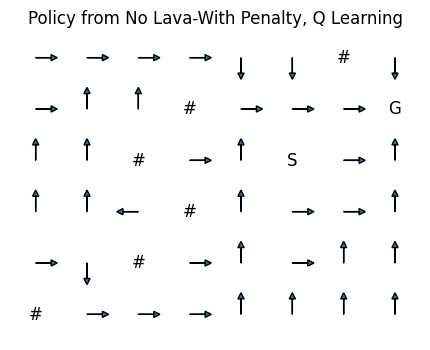

No Lava-With Penalty, SARSA
. . . . . . # .
. . . # . . . G
. . # . . S . .
. . . # A . . .
. . # . . . . .
# . . . . . . .


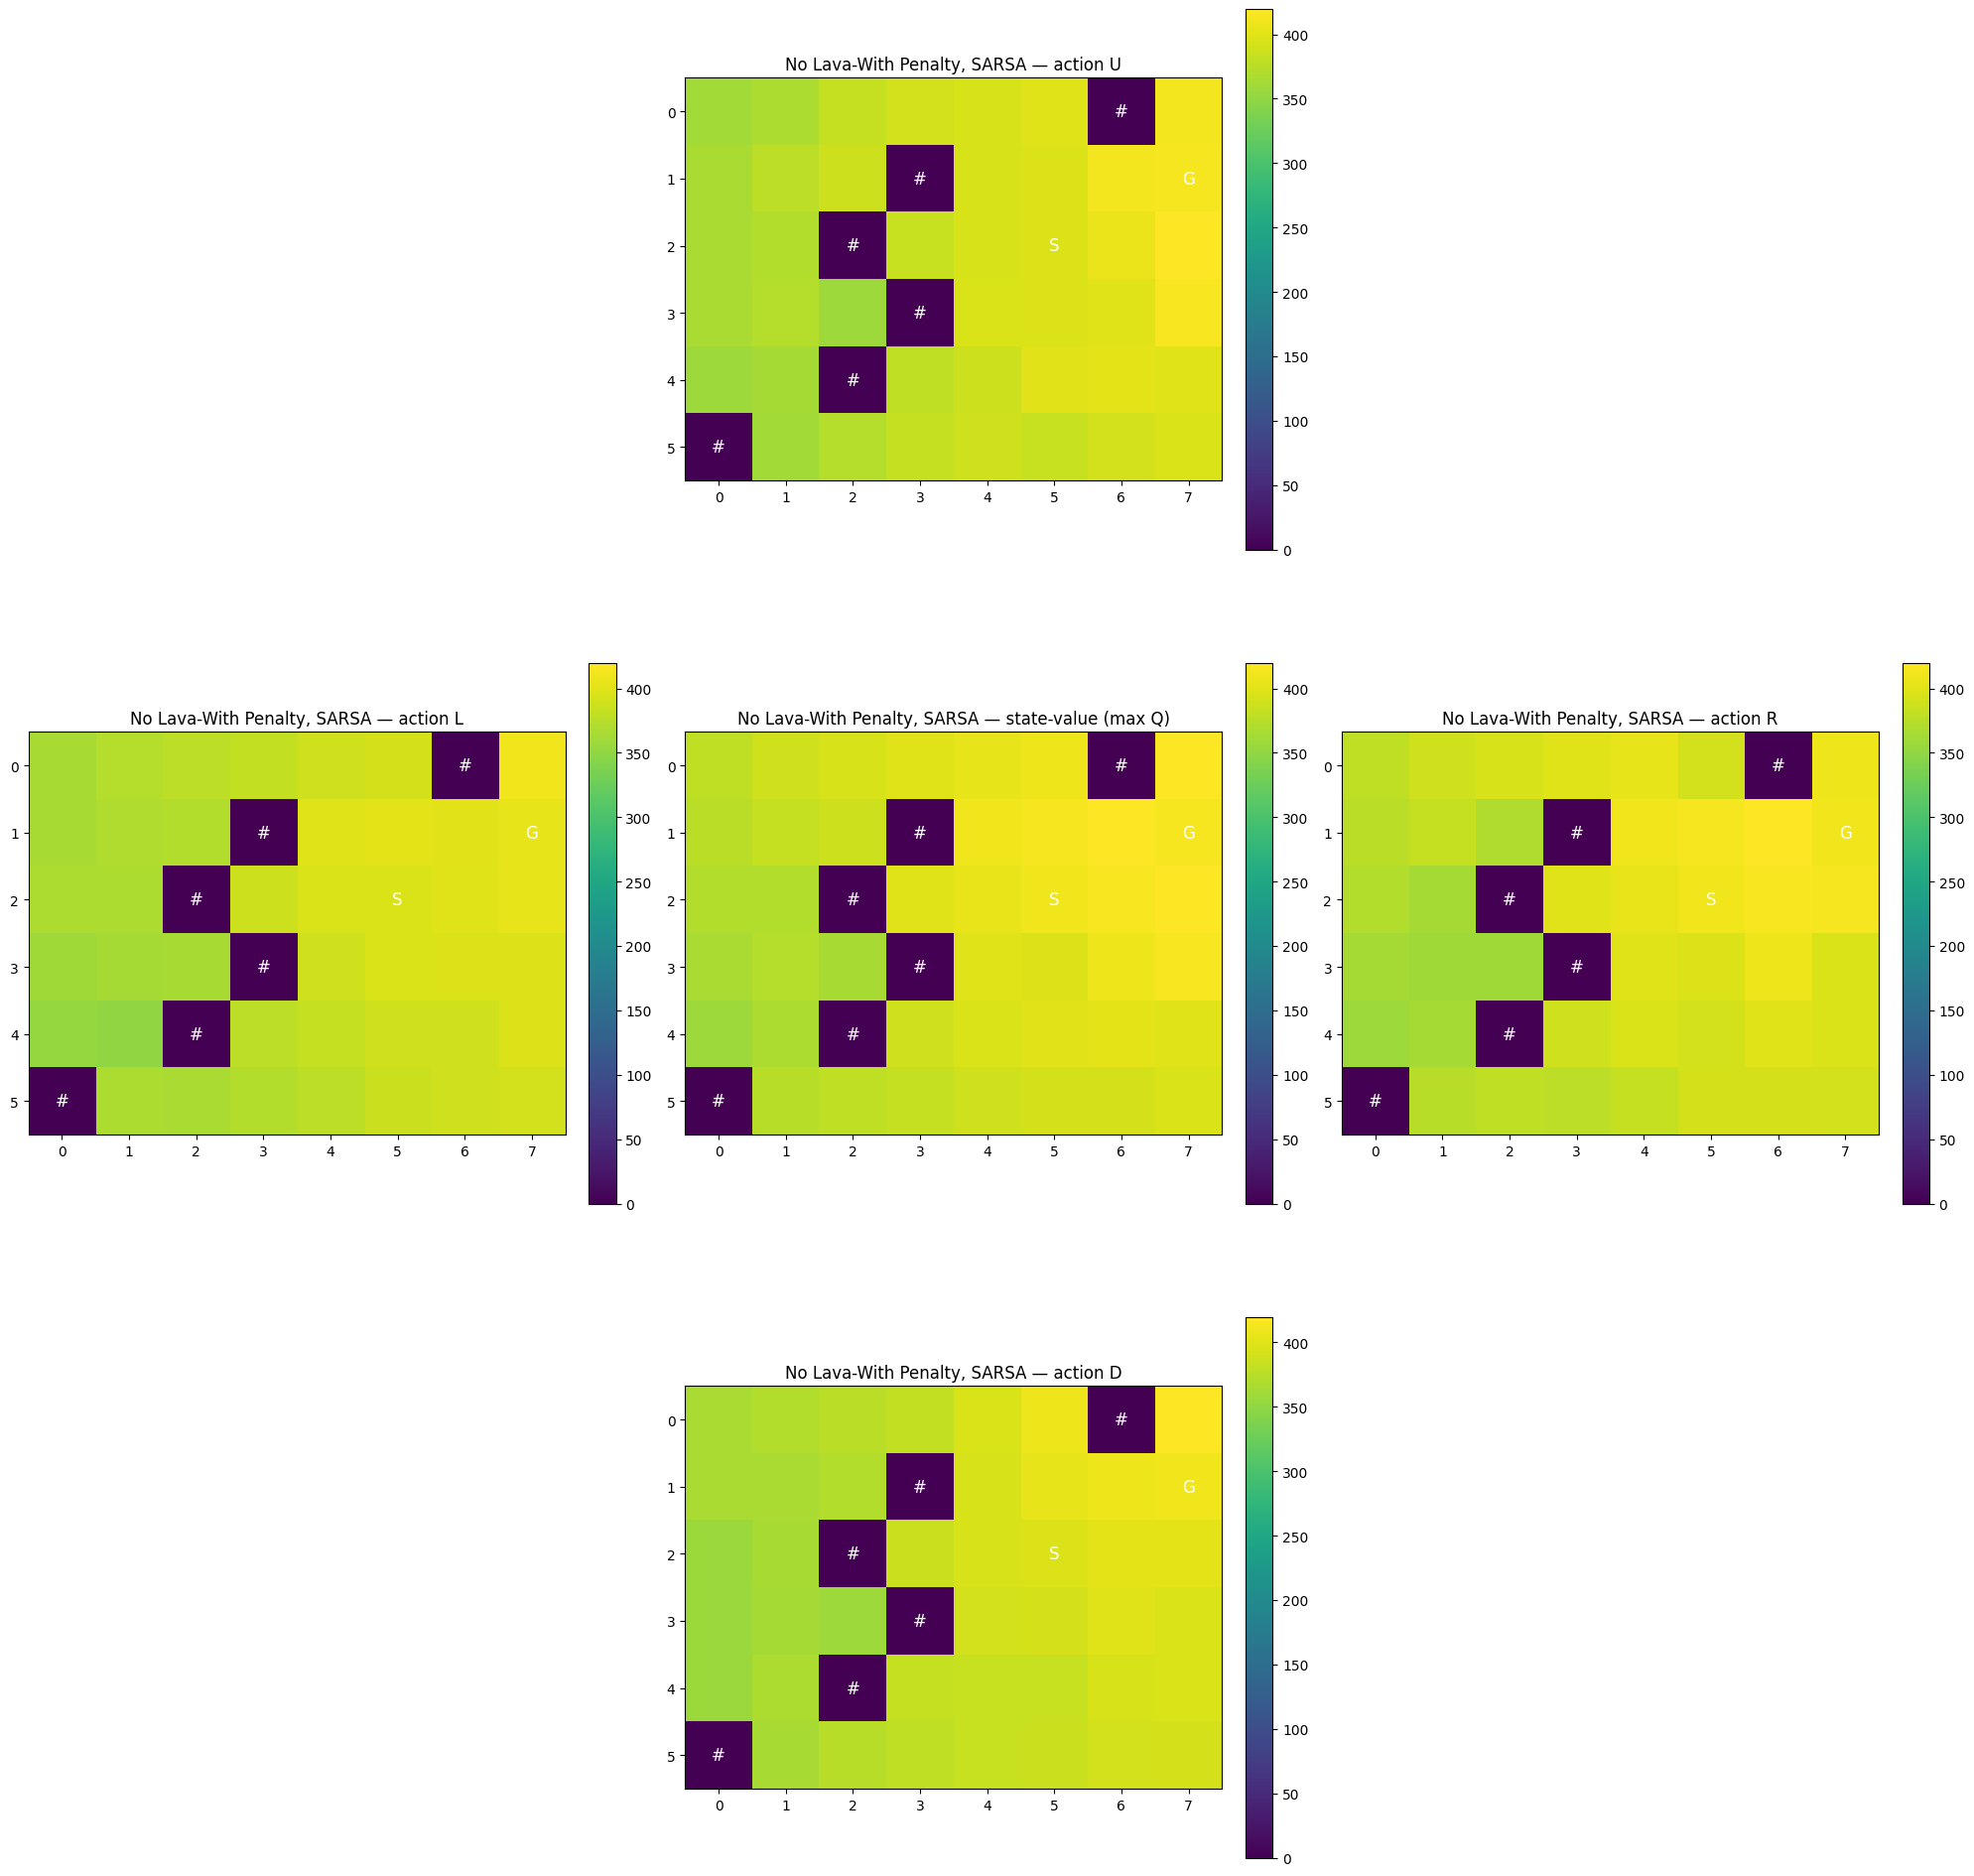

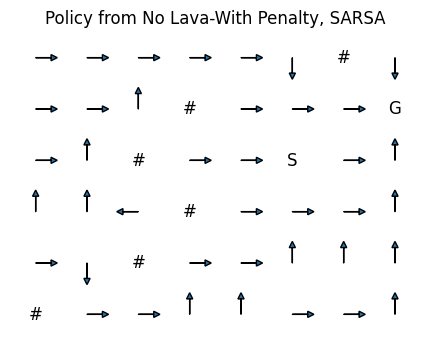

With Lava-No Penalty, Q Learning
A . . S G # L .
. L . . L # . #
. # . . # . . .
. . . # . # # .
. . L . # . . .
# . . # . . . .


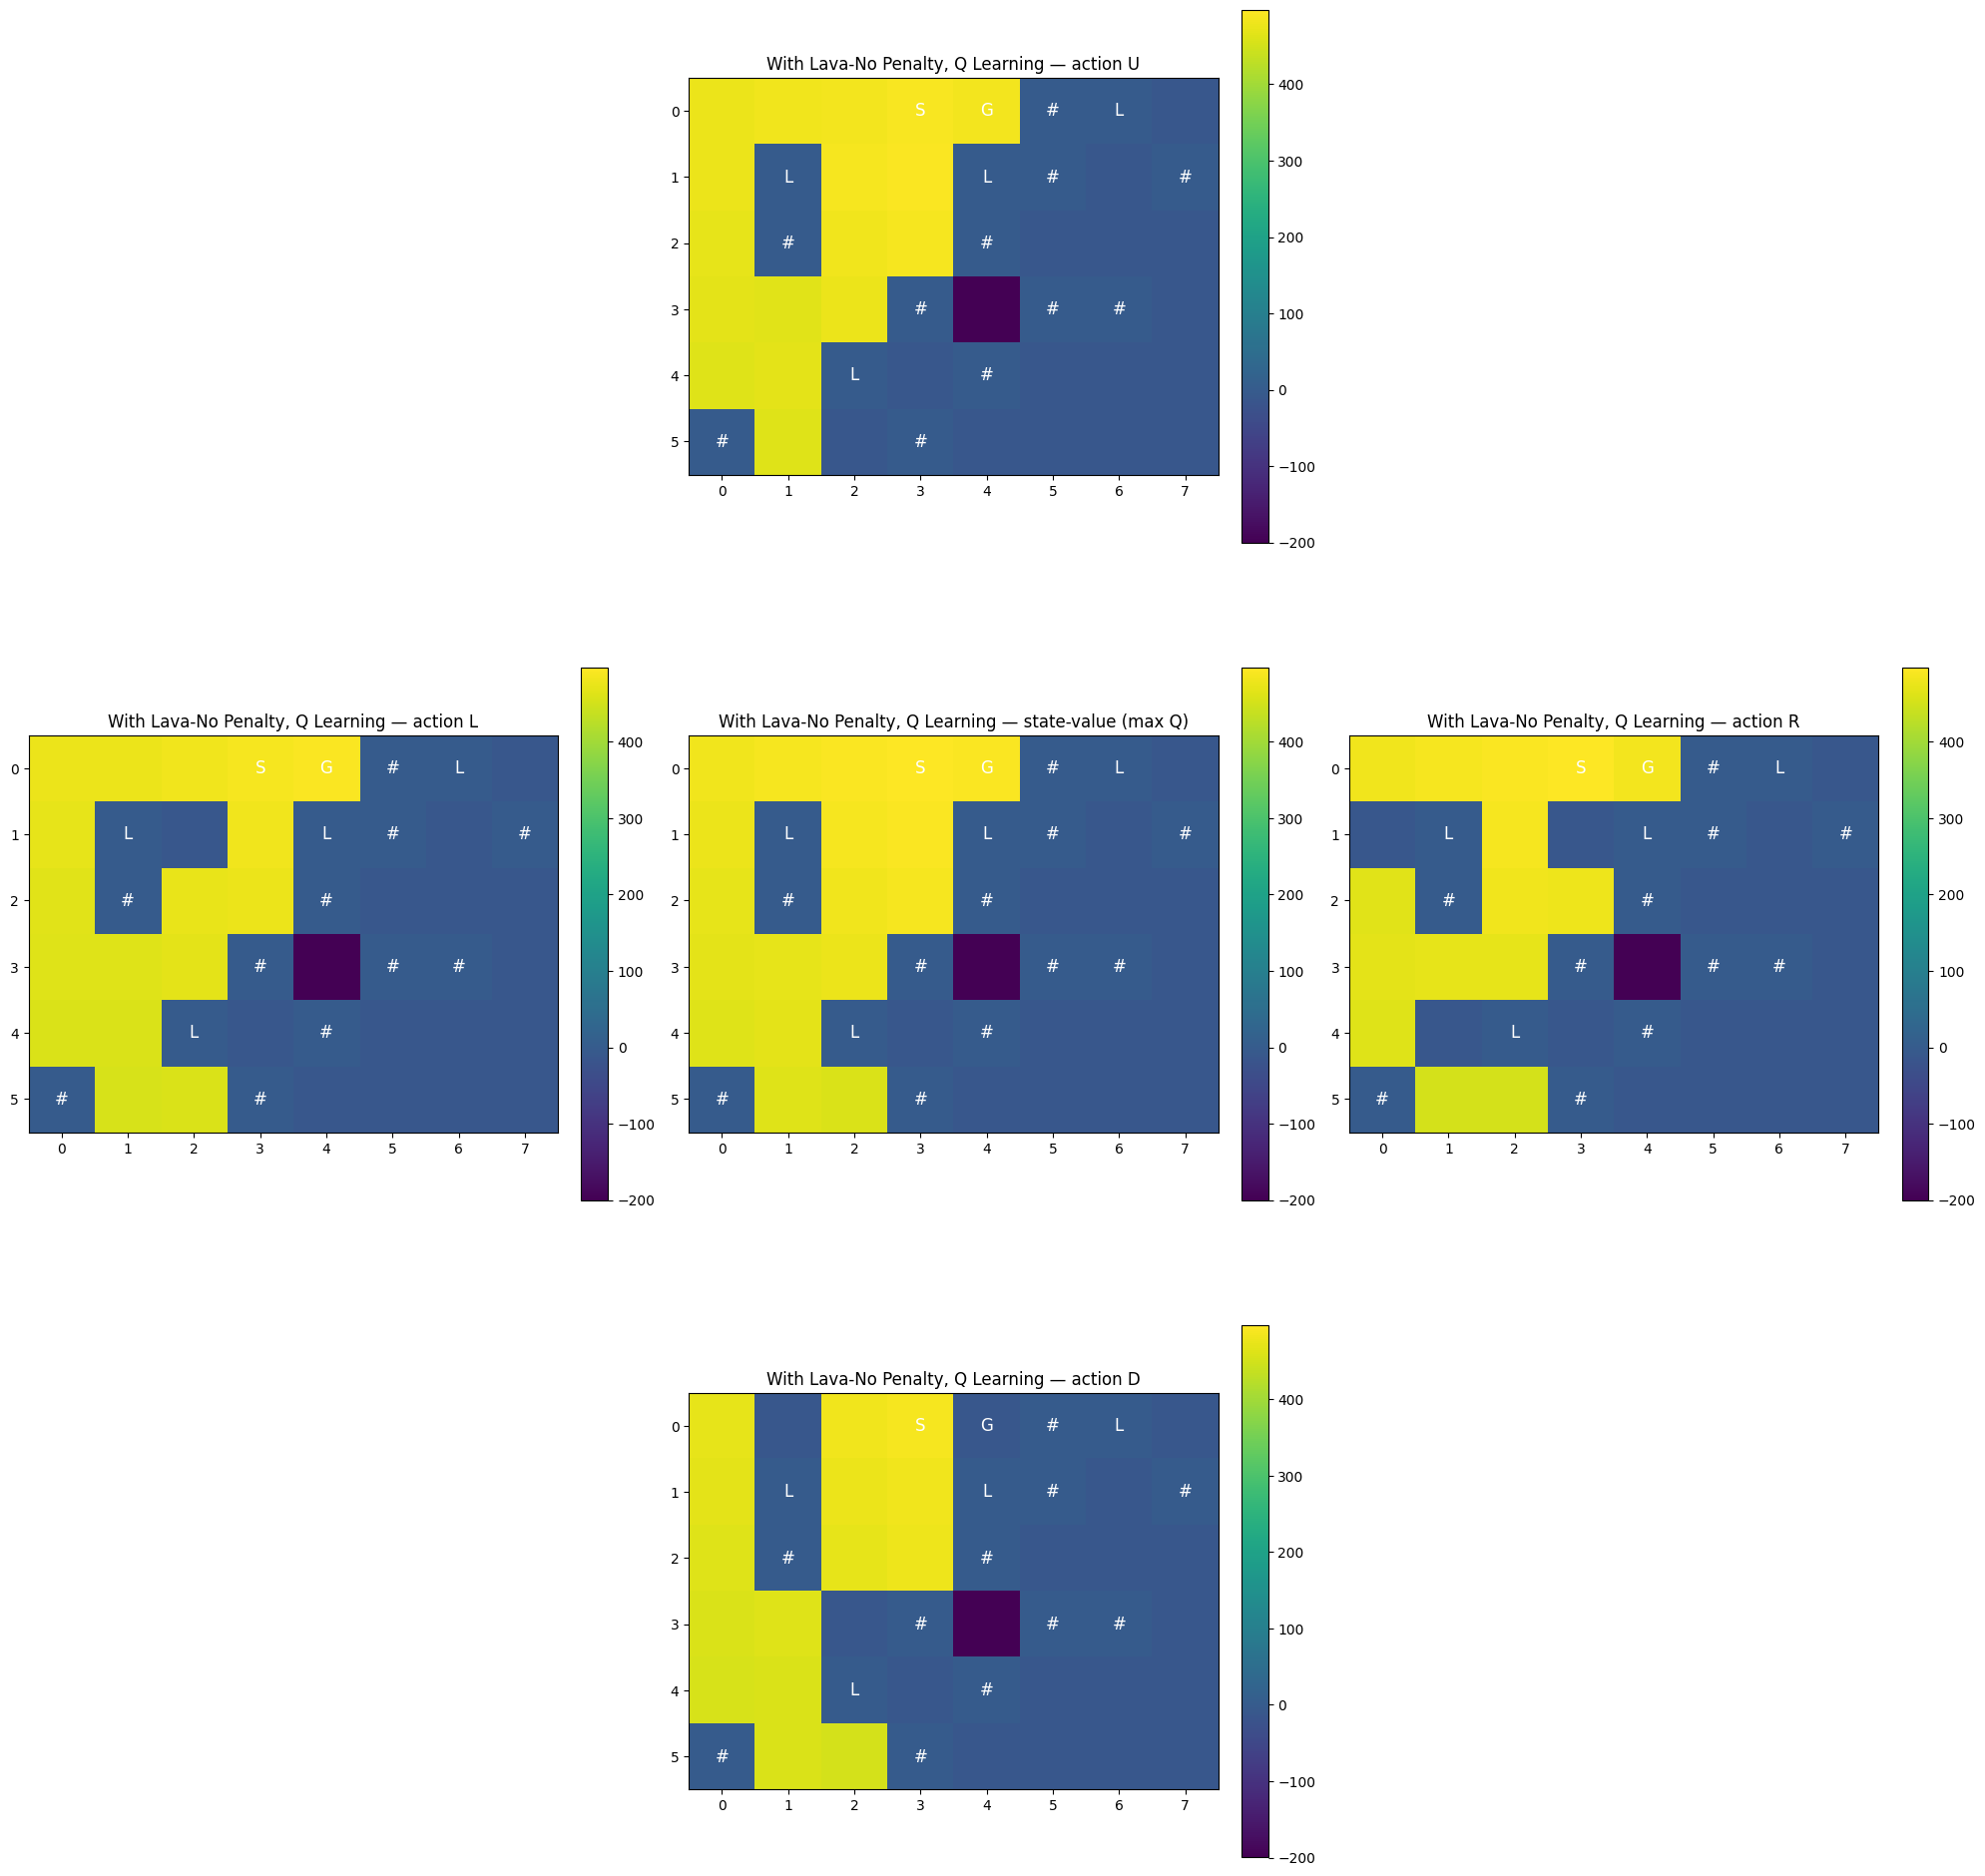

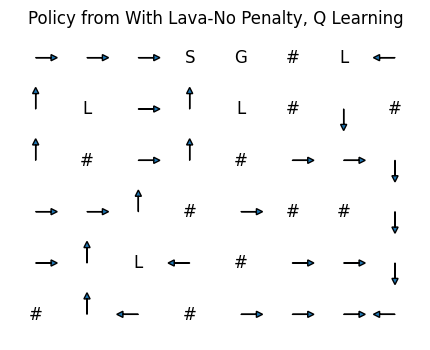

With Lava-No Penalty, SARSA
. . A S G # L .
. L . . L # . #
. # . . # . . .
. . . # . # # .
. . L . # . . .
# . . # . . . .


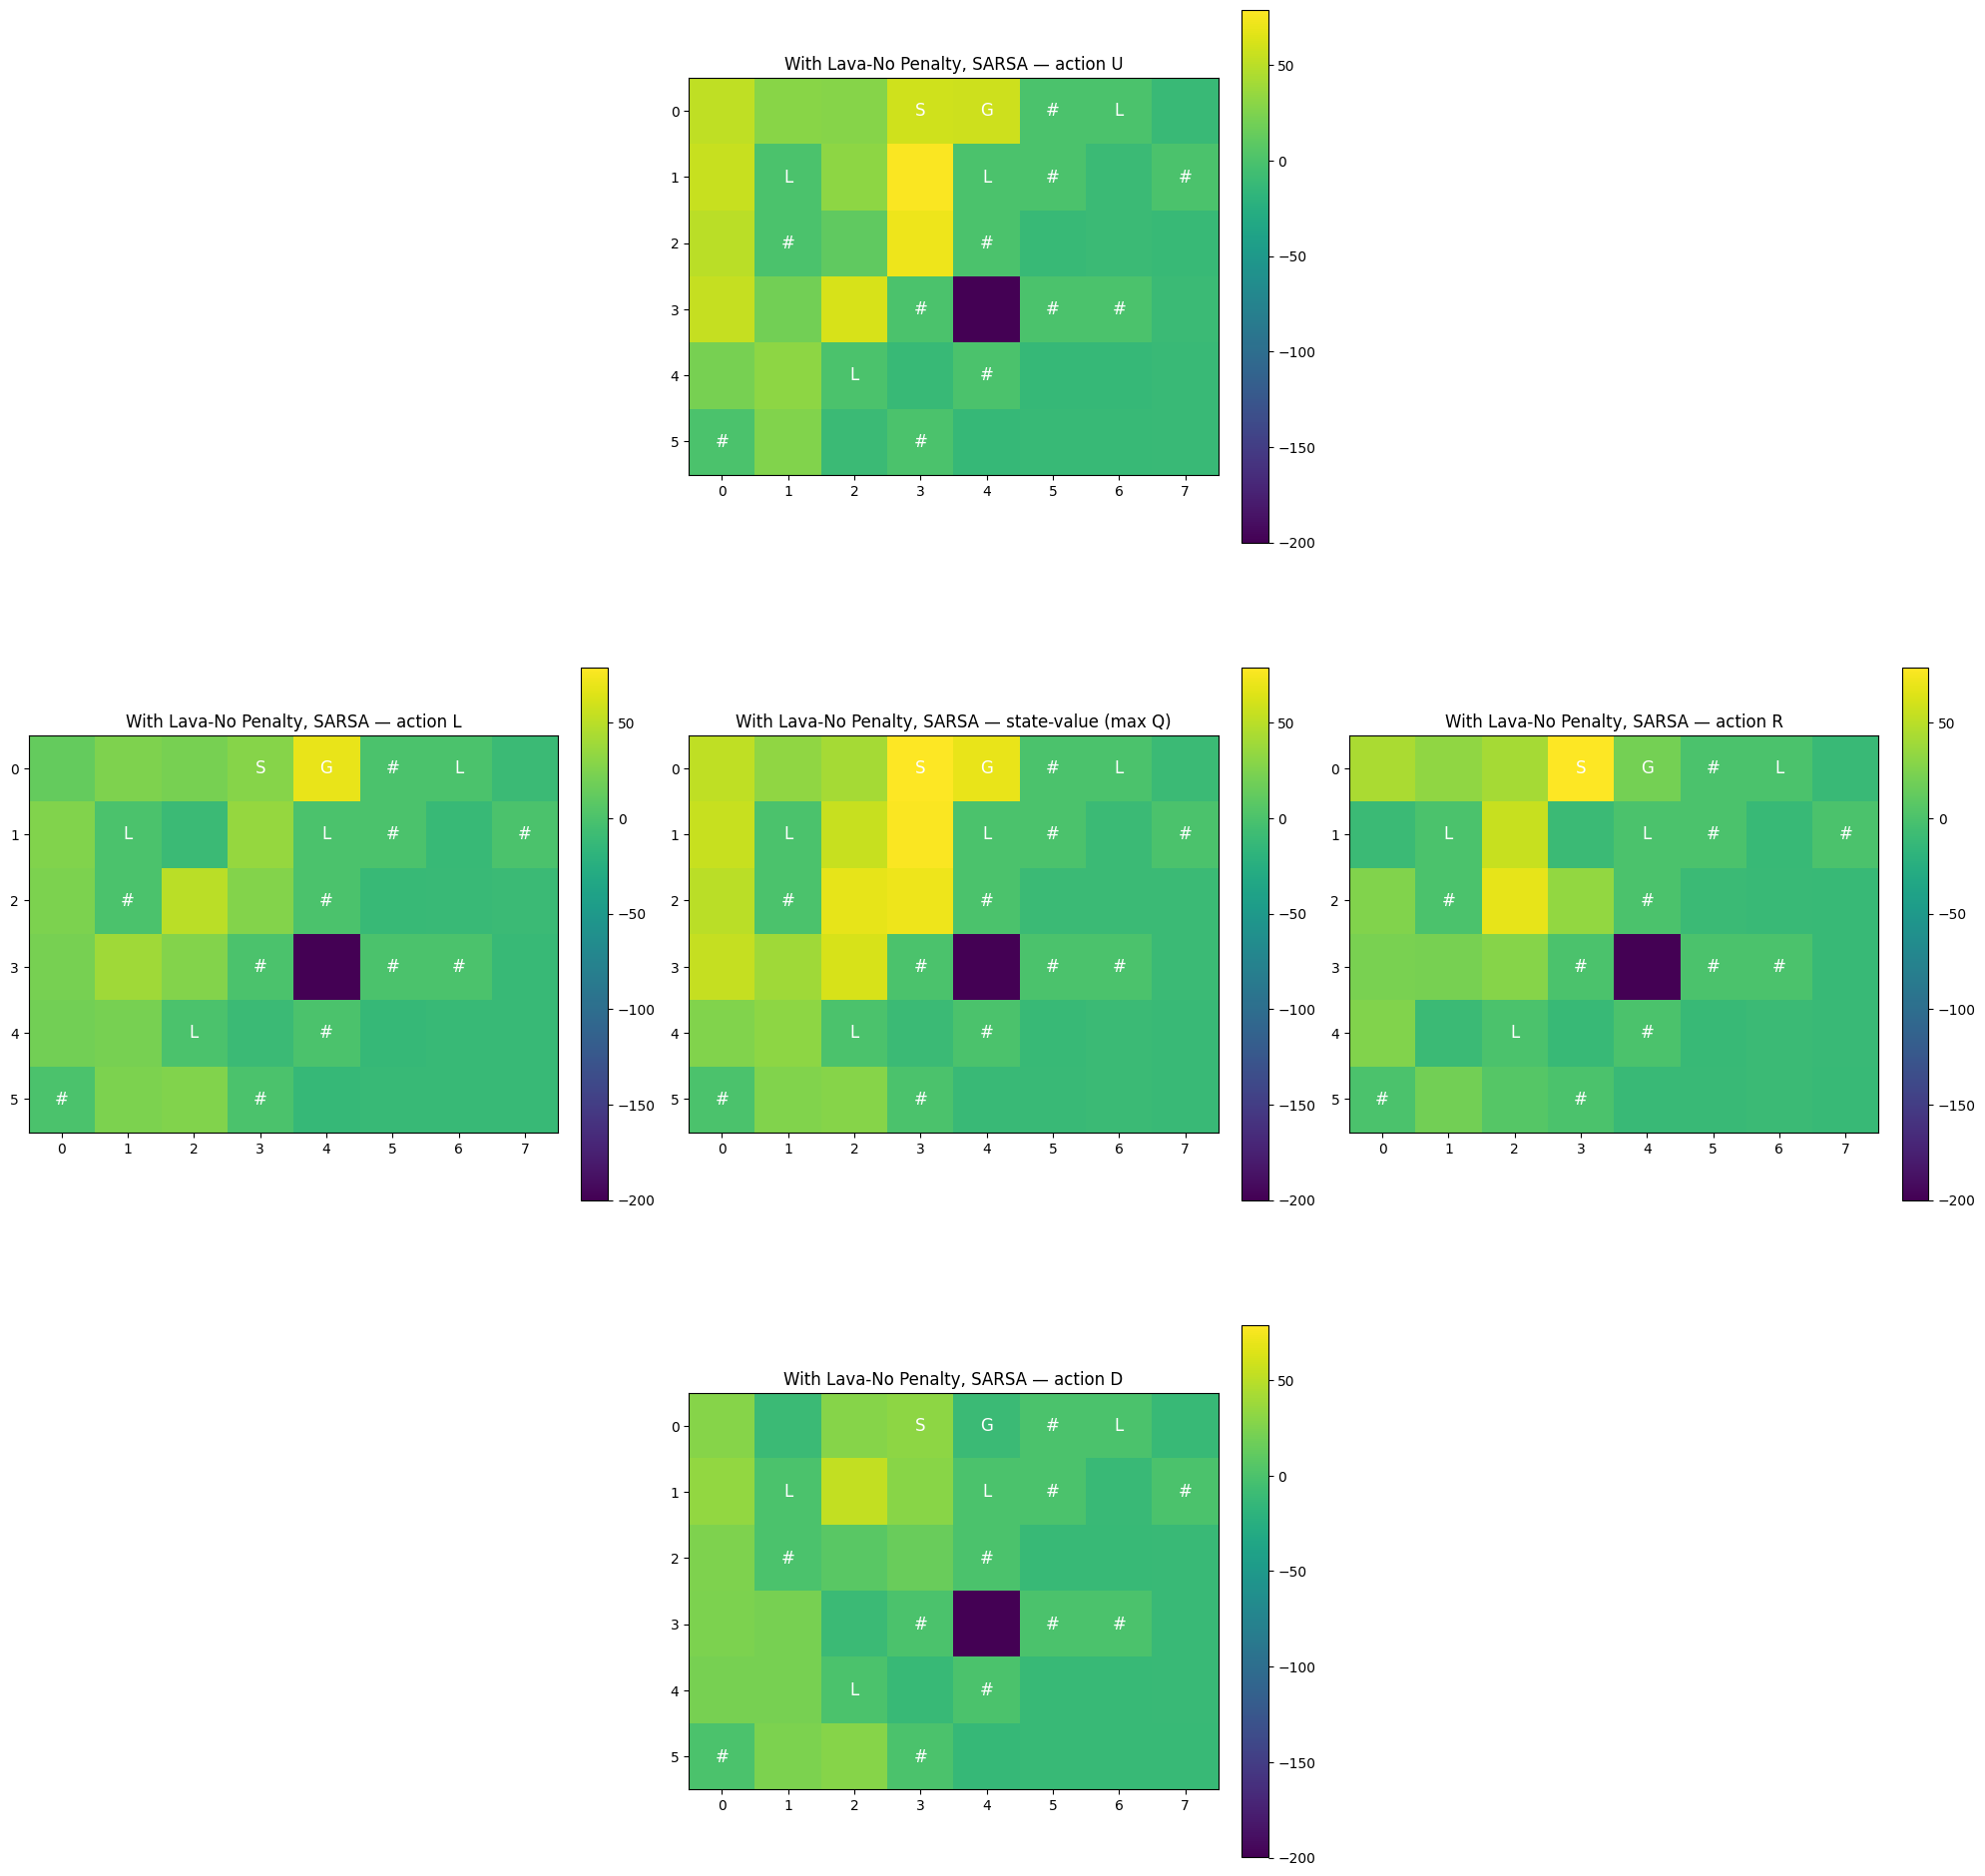

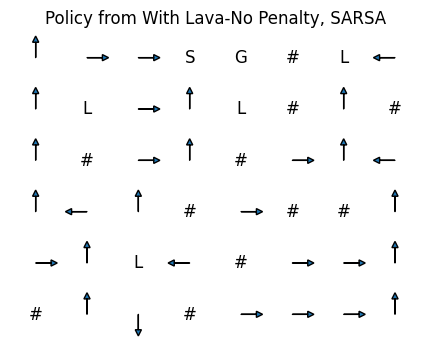

With Lava-No Penalty, Q Learning
A . . S G # L .
. L . . L # . #
. # . . # . . .
. . . # . # # .
. . L . # . . .
# . . # . . . .


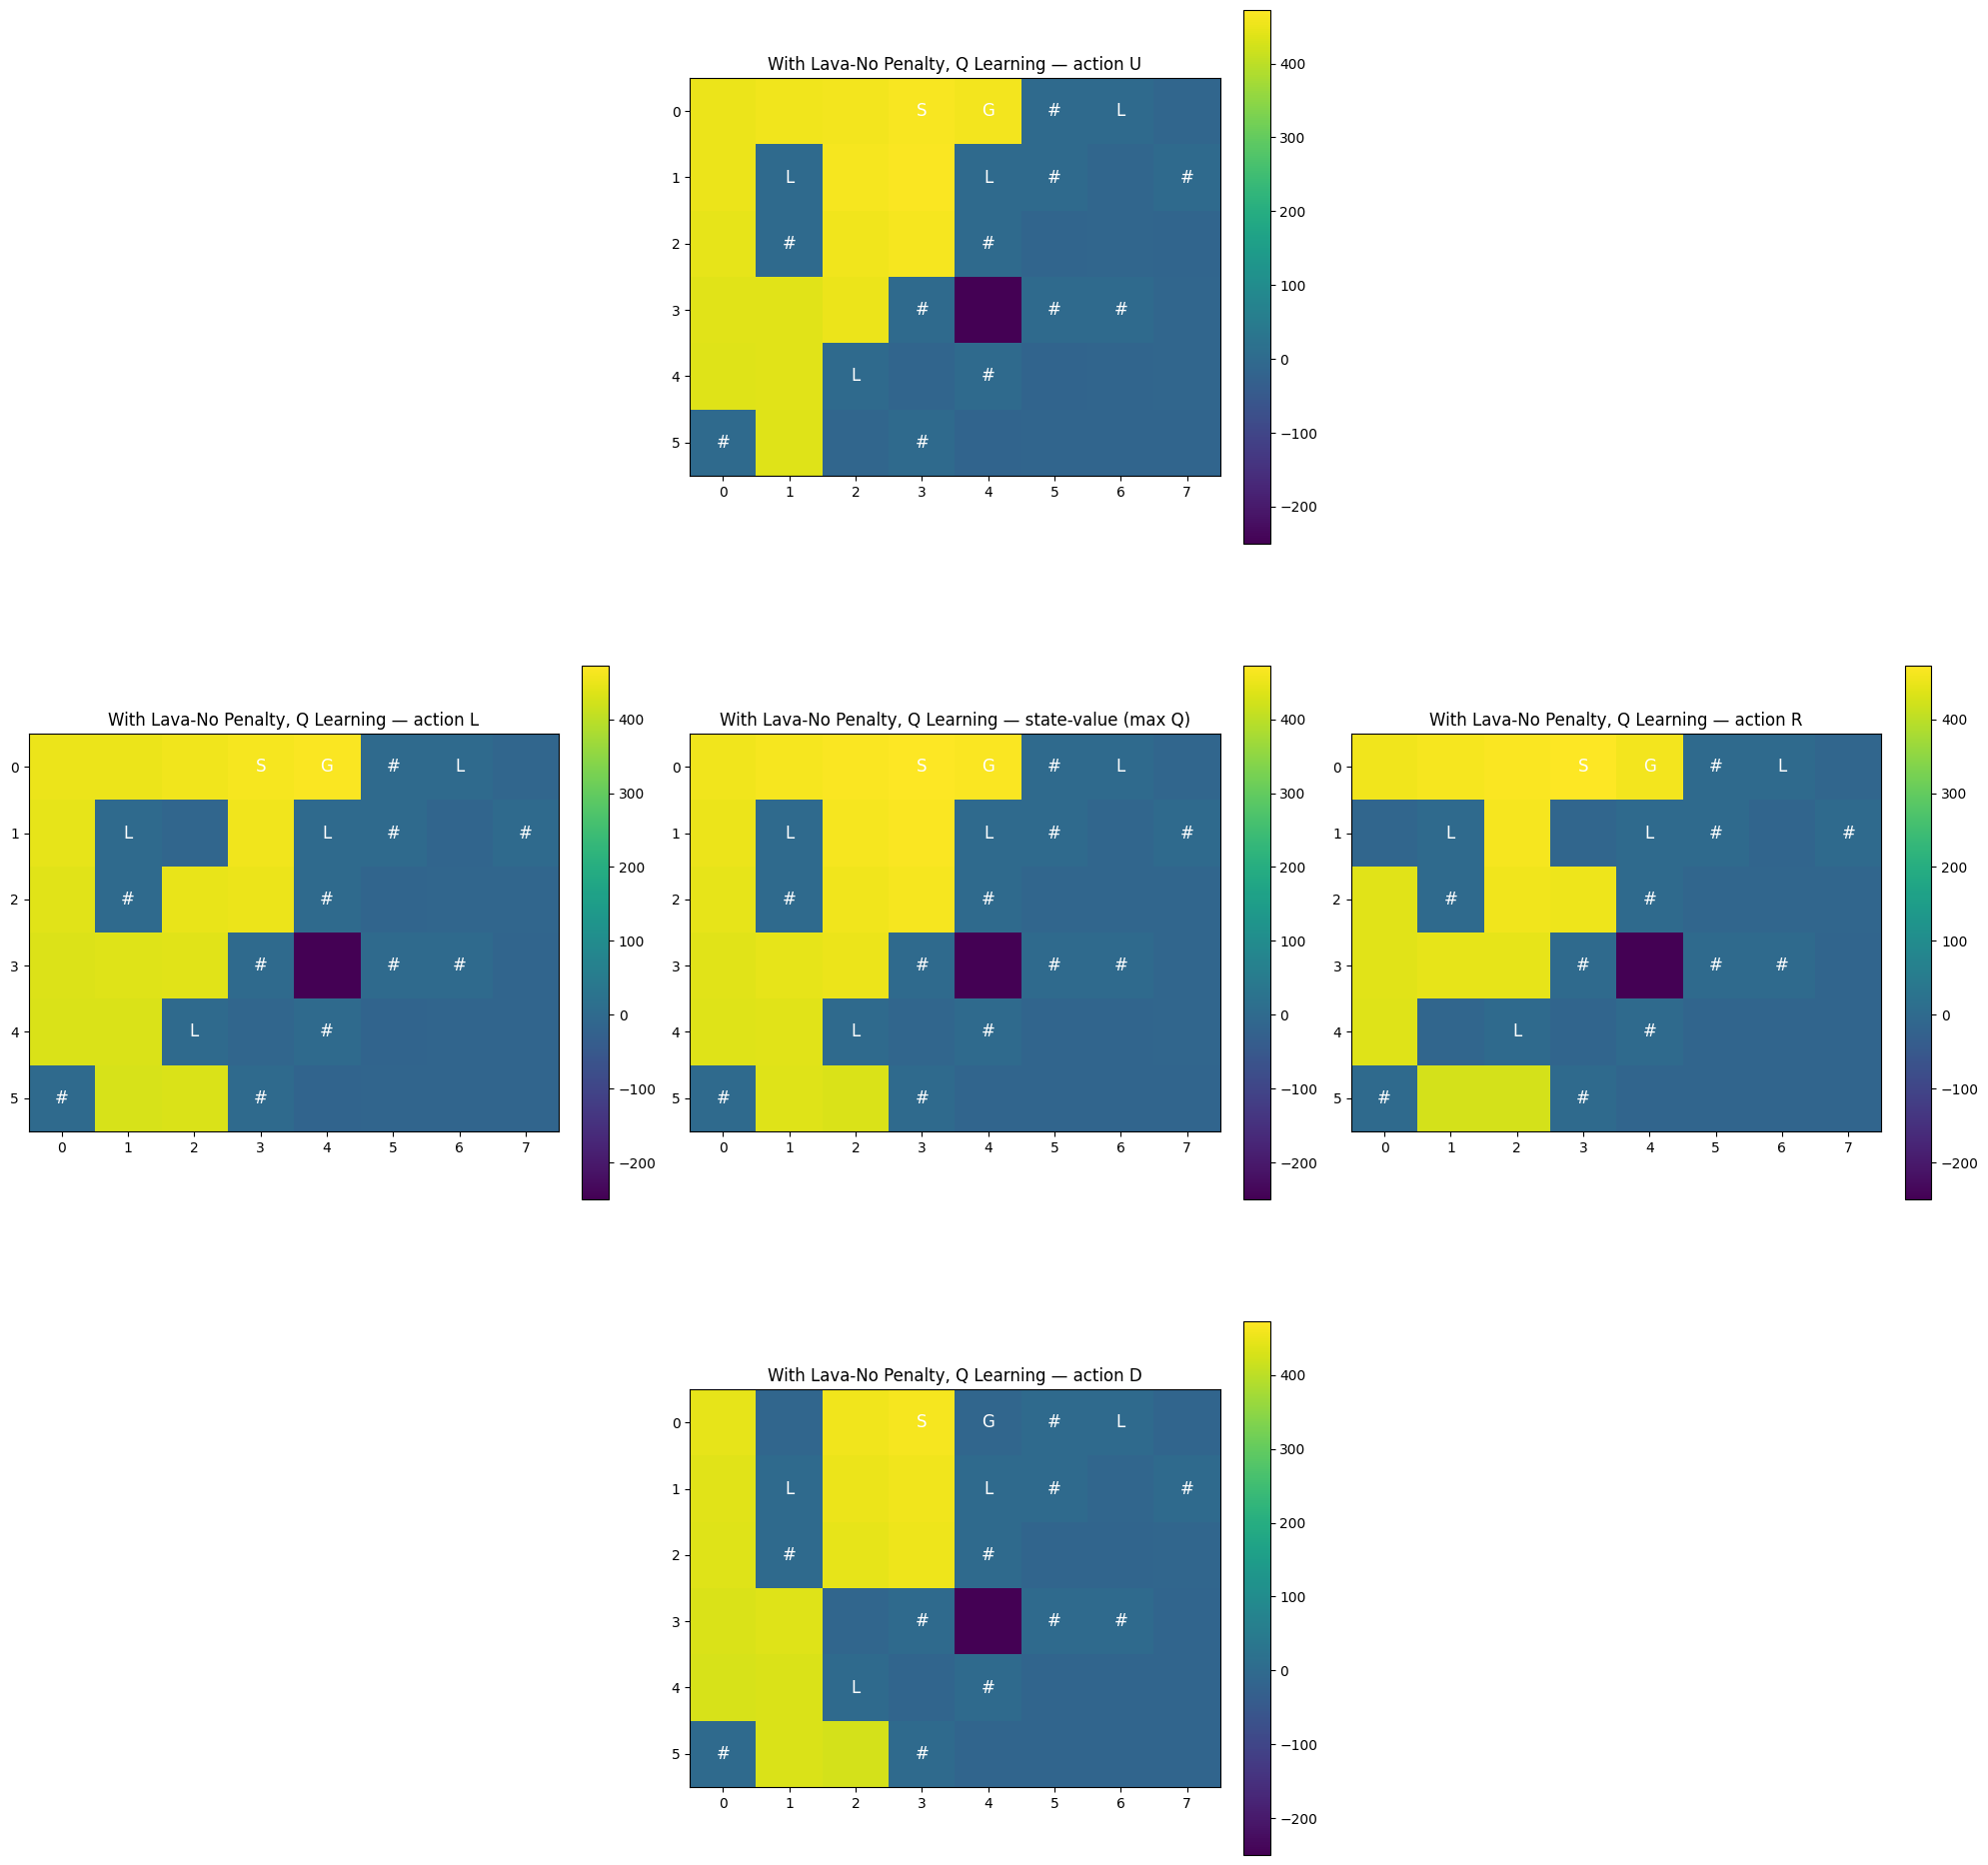

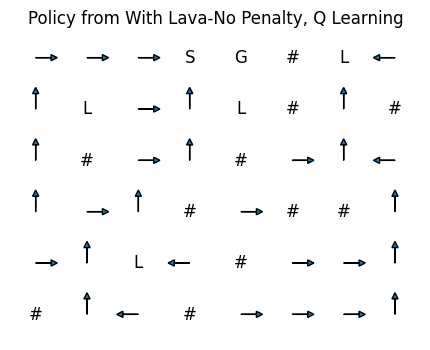

With Lava-With Penalty, SARSA
. . A S G # L .
. L . . L # . #
. # . . # . . .
. . . # . # # .
. . L . # . . .
# . . # . . . .


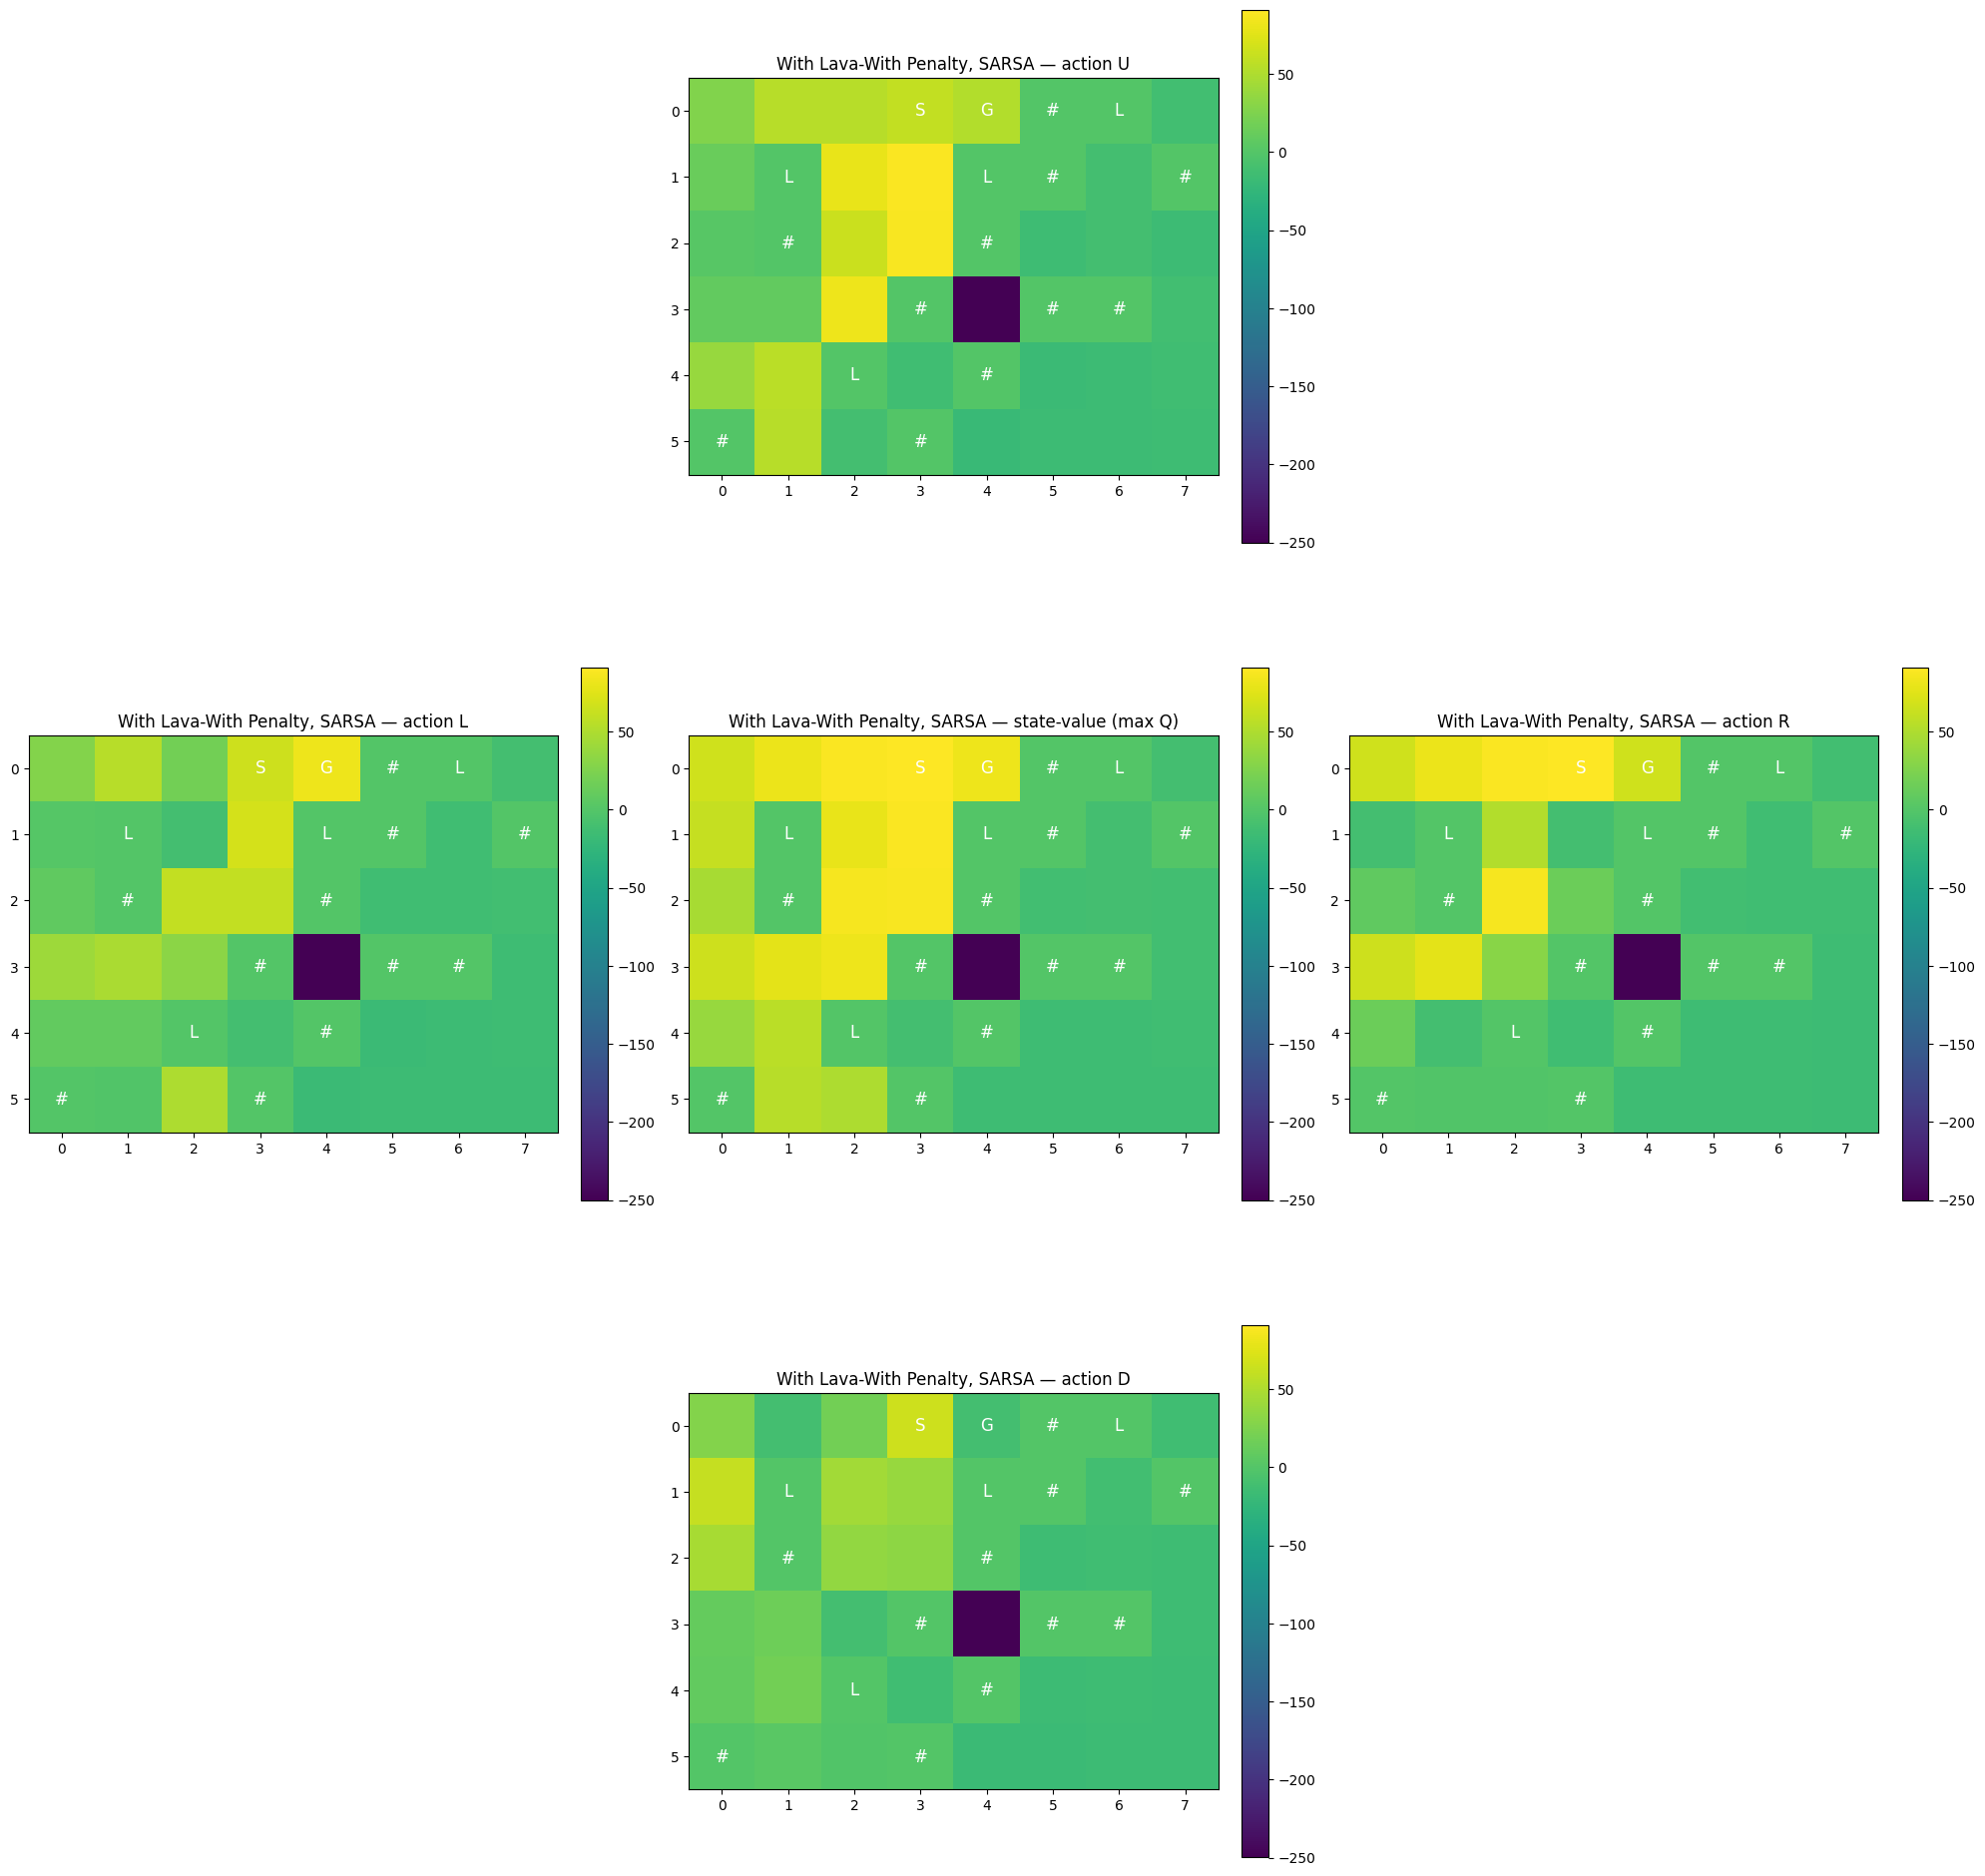

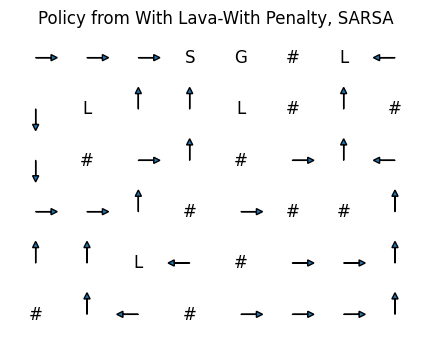

In [8]:
random_initial = True
# Demo runs - modify parameters or call run_experiment yourself
env_a, Qqa, Qsa, hqa, hsa = run_experiment(seed=10, lava_prob=0.0, per_step_penalty=0.0, episodes=100000, random_initial=random_initial)
env_b, Qqb, Qsb, hqb, hsb = run_experiment(seed=10, lava_prob=0.0, per_step_penalty=-0.5, lava_terminal=True, episodes=100000, random_initial=random_initial)
env_c, Qqc, Qsc, hqc, hsc = run_experiment(seed=13, lava_prob=0.08, per_step_penalty=0.0, lava_terminal=True, episodes=100000, random_initial=random_initial)
env_d, Qqd, Qsd, hqd, hsd = run_experiment(seed=13, lava_prob=0.08, per_step_penalty=-0.5, lava_terminal=True, episodes=100000, random_initial=random_initial)

# Demo: try to find an existing trained Q (common names used in this notebook are Qqa, Qqb, Qqc, Q_q, Q_s, etc.)
runs = [(env_a,Qqa,'No Lava-No Penalty, Q Learning'), (env_a,Qsa, 'No Lava-No Penalty, SARSA'), (env_b,Qqb, 'No Lava-With Penalty, Q Learning'),
(env_b,Qsb, 'No Lava-With Penalty, SARSA'), (env_c,Qqc, 'With Lava-No Penalty, Q Learning'), (env_c,Qsc, 'With Lava-No Penalty, SARSA'),
(env_d,Qqd, 'With Lava-No Penalty, Q Learning'), (env_d,Qsd, 'With Lava-With Penalty, SARSA')]

found = None
for run in runs:
    
    env_var = run[0]
    print(run[2])
    env_var.reset()
    env_var.render()
    Q = run[1]
    plot_q_heatmaps(Q, env_var, title_prefix=f'{run[2]}')
    plot_greedy_policy(Q, env_var, title=f'Policy from {run[2]}')


# The effect of exploration

Grid (A=Agent, G=goal, #=wall, L=lava):
. . . . . # L . . L . . L # . # . # . . # . . . . . . # . #
# . . . L . # . . . # . . # . . . . . . # . # # . # . . . .
. . # . # . # . . . . # . # . . # # . . . # . # . . . L . .
. # # . . . . . . # . . . G . . . . . . . . . . # . . . . #
. . . . . . . . . . . . . . . . L . L . . # . # L # . . # .
. . . . . L . # . . # . . L L . . . . . . L . . . . . . . .
. . . L # # . . L # . # . # . # . # . . . # . . . # . . . .
. . . . . . L . . . . . . . . . . . . . . L . . L . . . . .
. . . # . . . L # . . # . . . L . . . . . . . . . # . . . #
. . . . . . L . L . # L # # . . # # . . . . . . # . . . . .
. . . . . . . . . . . . . . L . . . # . . . # . # . . . . .
# . # # . . . . # L . . . L . . . . # . . . . . . . . . . .
# . . . . . . . . . . . . . # # . . L . . . . . # . . # L .
. . . L . L # . . . # . . . . . . . . . . . . # . # . . . .
. . . # . . . . . L . . . # . . . . . # . . . . . . . . . .
. . # . L . . . . . . # # . . . # . . . # . . L L . . . . .


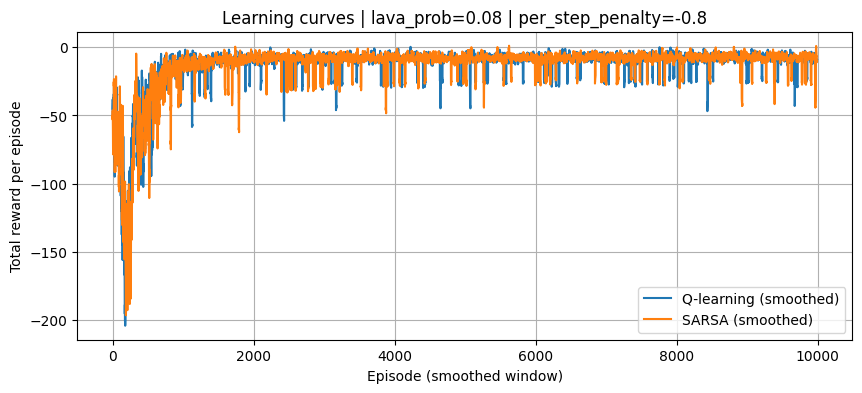

Grid (A=Agent, G=goal, #=wall, L=lava):
. . . . . # L . . L . . L # . # . # . . # . . . . . . # . #
# . . . L . # . . . # . . # . . . . . . # . # # . # . . . .
. . # . # . # . . . . # . # . . # # . . . # . # . . . L . .
. # # . . . . . . # . . . G . . . . . . . . . . # . . . . #
. . . . . . . . . . . . . . . . L . L . . # . # L # . . # .
. . . . . L . # . . # . . L L . . . . . . L . . . . . . . .
. . . L # # . . L # . # . # . # . # . . . # . . . # . . . .
. . . . . . L . . . . . . . . . . . . . . L . . L . . . . .
. . . # . . . L # . . # . . . L . . . . . . . . . # . . . #
. . . . . . L . L . # L # # . . # # . . . . . . # . . . . .
. . . . . . . . . . . . . . L . . . # . . . # . # . . . . .
# . # # . . . . # L . . . L . . . . # . . . . . . . . . . .
# . . . . . . . . . . . . . # # . . L . . . . . # . . # L .
. . . L . L # . . . # . . . . . . . . . . . . # . # . . . .
. . . # . . . . . L . . . # . . . . . # . . . . . . . . . .
. . # . L . . . . . . # # . . . # . . . # . . L L . . . . .


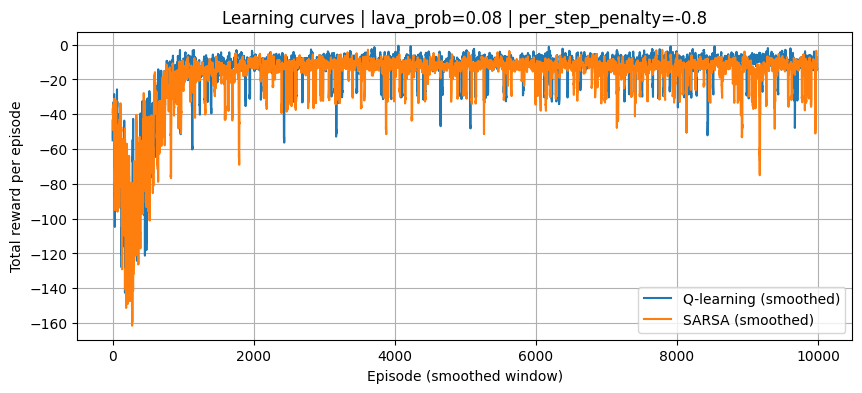

Grid (A=Agent, G=goal, #=wall, L=lava):
. . . . . # L . . L . . L # . # . # . . # . . . . . . # . #
# . . . L . # . . . # . . # . . . . . . # . # # . # . . . .
. . # . # . # . . . . # . # . . # # . . . # . # . . . L . .
. # # . . . . . . # . . . G . . . . . . . . . . # . . . . #
. . . . . . . . . . . . . . . . L . L . . # . # L # . . # .
. . . . . L . # . . # . . L L . . . . . . L . . . . . . . .
. . . L # # . . L # . # . # . # . # . . . # . . . # . . . .
. . . . . . L . . . . . . . . . . . . . . L . . L . . . . .
. . . # . . . L # . . # . . . L . . . . . . . . . # . . . #
. . . . . . L . L . # L # # . . # # . . . . . . # . . . . .
. . . . . . . . . . . . . . L . . . # . . . # . # . . . . .
# . # # . . . . # L . . . L . . . . # . . . . . . . . . . .
# . . . . . . . . . . . . . # # . . L . . . . . # . . # L .
. . . L . L # . . . # . . . . . . . . . . . . # . # . . . .
. . . # . . . . . L . . . # . . . . . # . . . . . . . . . .
. . # . L . . . . . . # # . . . # . . . # . . L L . . . . .


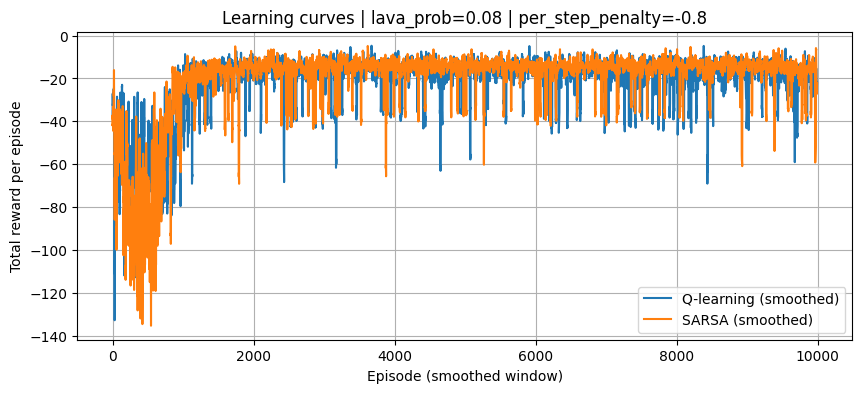

Grid (A=Agent, G=goal, #=wall, L=lava):
. . . . . # L . . L . . L # . # . # . . # . . . . . . # . #
# . . . L . # . . . # . . # . . . . . . # . # # . # . . . .
. . # . # . # . . . . # . # . . # # . . . # . # . . . L . .
. # # . . . . . . # . . . G . . . . . . . . . . # . . . . #
. . . . . . . . . . . . . . . . L . L . . # . # L # . . # .
. . . . . L . # . . # . . L L . . . . . . L . . . . . . . .
. . . L # # . . L # . # . # . # . # . . . # . . . # . . . .
. . . . . . L . . . . . . . . . . . . . . L . . L . . . . .
. . . # . . . L # . . # . . . L . . . . . . . . . # . . . #
. . . . . . L . L . # L # # . . # # . . . . . . # . . . . .
. . . . . . . . . . . . . . L . . . # . . . # . # . . . . .
# . # # . . . . # L . . . L . . . . # . . . . . . . . . . .
# . . . . . . . . . . . . . # # . . L . . . . . # . . # L .
. . . L . L # . . . # . . . . . . . . . . . . # . # . . . .
. . . # . . . . . L . . . # . . . . . # . . . . . . . . . .
. . # . L . . . . . . # # . . . # . . . # . . L L . . . . .


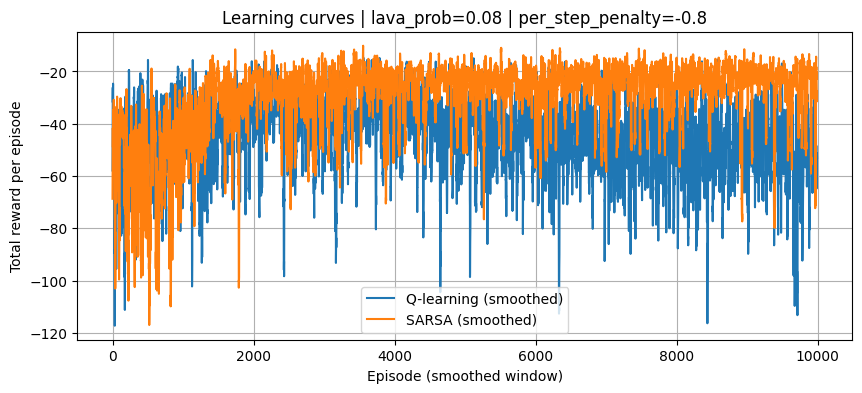

epsilon 0.01, Q Learning
. . . . . # L . . L . . L # . # . # . . # . . . . . . # . #
# . . . L . # . . . # . . # . . . . . . # . # # . # . . . .
. . # . # . # . . . . # . # . . # # . . . # . # . . . L . .
. # # . . . . . . # . . . G . . . . . . . . . . # . . . . #
. . . . . . . . . . . . . . . . L . L . . # . # L # . . # .
. . . . . L . # . . # . . L L . . . . . . L . . . . . . . .
. . . L # # . . L # . # . # . # . # . . . # . . . # . . . .
. . . . . . L . . . . . . . . . . . . . . L . . L . . . . .
. . A # . . . L # . . # . . . L . . . . . . . . . # . . . #
. . . . . . L . L . # L # # . . # # . . . . . . # . . . . .
. . . . . . . . . . . . . . L . . . # . . . # . # . . . . .
# . # # . . . . # L . . . L . . . . # . . . . . . . . . . .
# . . . . . . . . . . . . . # # . . L . . . . . # . . # L .
. . . L . L # . . . # . . . . . . . . . . . . # . # . . . .
. . . # . . . . . L . . . # . . . . . # . . . . . . . . . .
. . # . L . . . . . . # # . . . # . . . # . . L L . . . . .
. . . . # . . #

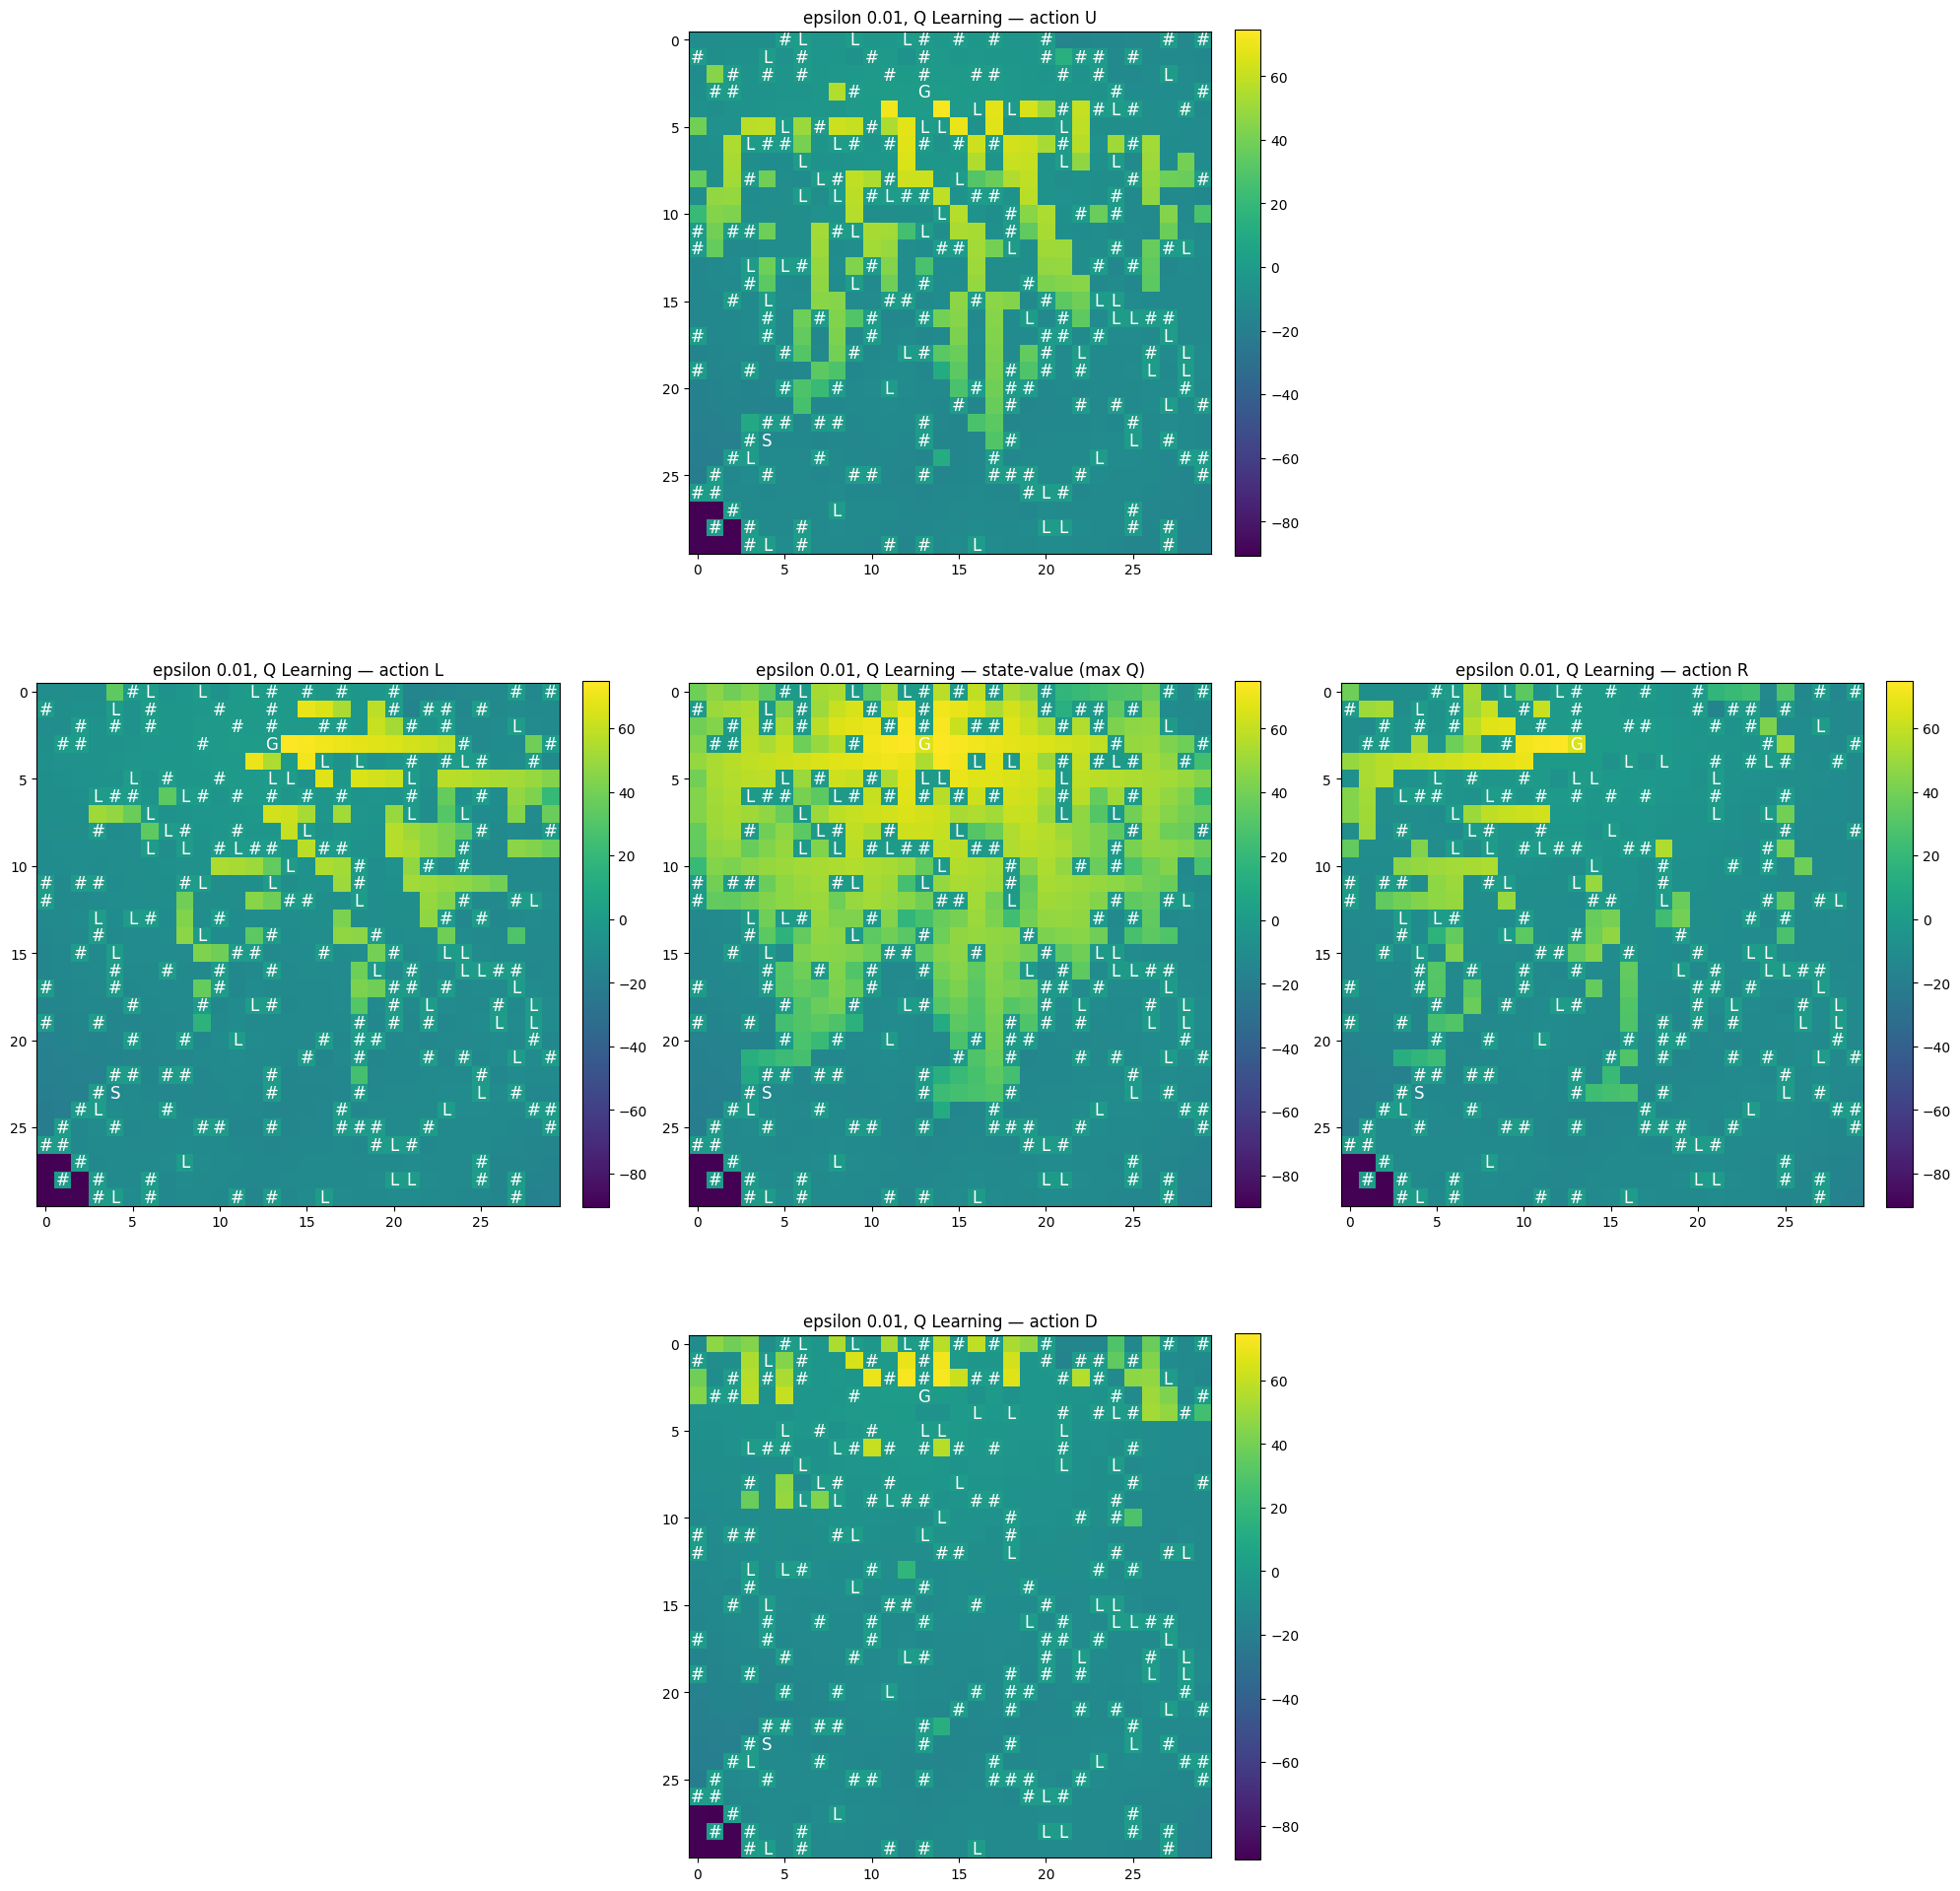

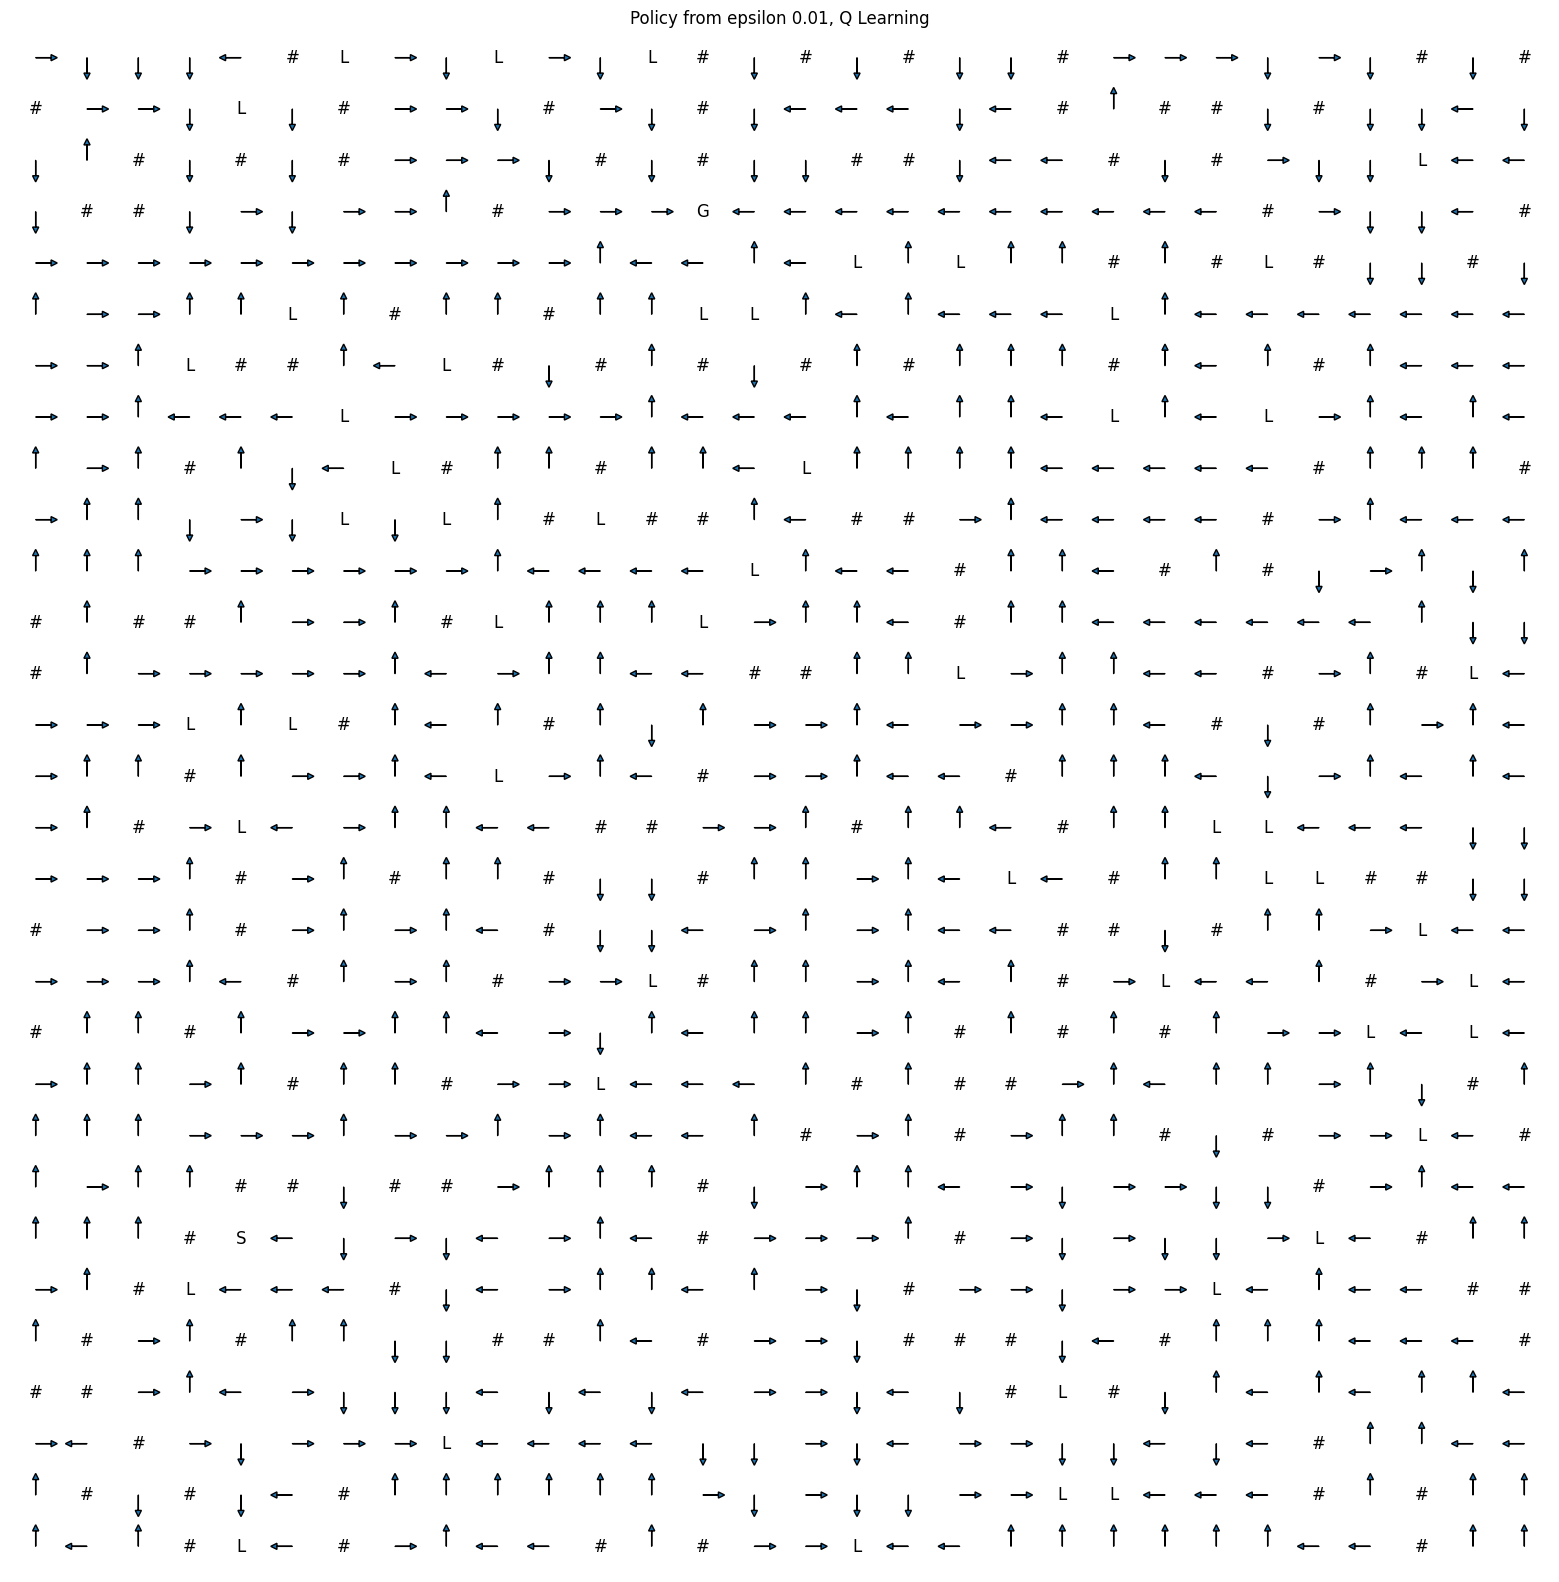

epsilon 0.01, SARSA
. . . . . # L . . L . . L # . # . # . . # . . . . . . # . #
# . . . L . # . . . # . . # . . . . . . # . # # . # . . . .
. . # . # . # . . . . # . # . . # # . . . # . # . . . L . .
. # # . . . . . . # . . . G . . . . . . . . . . # . . . . #
. . . . . . . . . . . . . . . . L . L . . # . # L # . . # .
. . . . . L . # . . # . . L L . . . . . . L . . . . . . . .
. . . L # # . . L # . # . # . # . # . . . # . . . # . . . .
. . . . . . L . . . . . . . . . . . . . . L . . L . . . . .
. . . # . . . L # . . # . . . L . . . . . . . . . # . . . #
. . . . . . L . L . # L # # . . # # . . . . . . # . . . . .
. . . . . . . . . . . . . . L . . . # . . . # . # . . . . .
# . # # . . . . # L . . . L . . . . # . . . . . . . . . . .
# . . . . . . . . . . . . . # # . . L . . . . . # . . # L .
. . . L . L # . . . # . . . . . . . . . . . . # . # . . . .
. . . # . . . . . L . . . # . . . . . # . . . . . . . . . .
. . # . L . . . . . . # # . . . # . . . # . . L L . . . . .
. . . . # . . # . . 

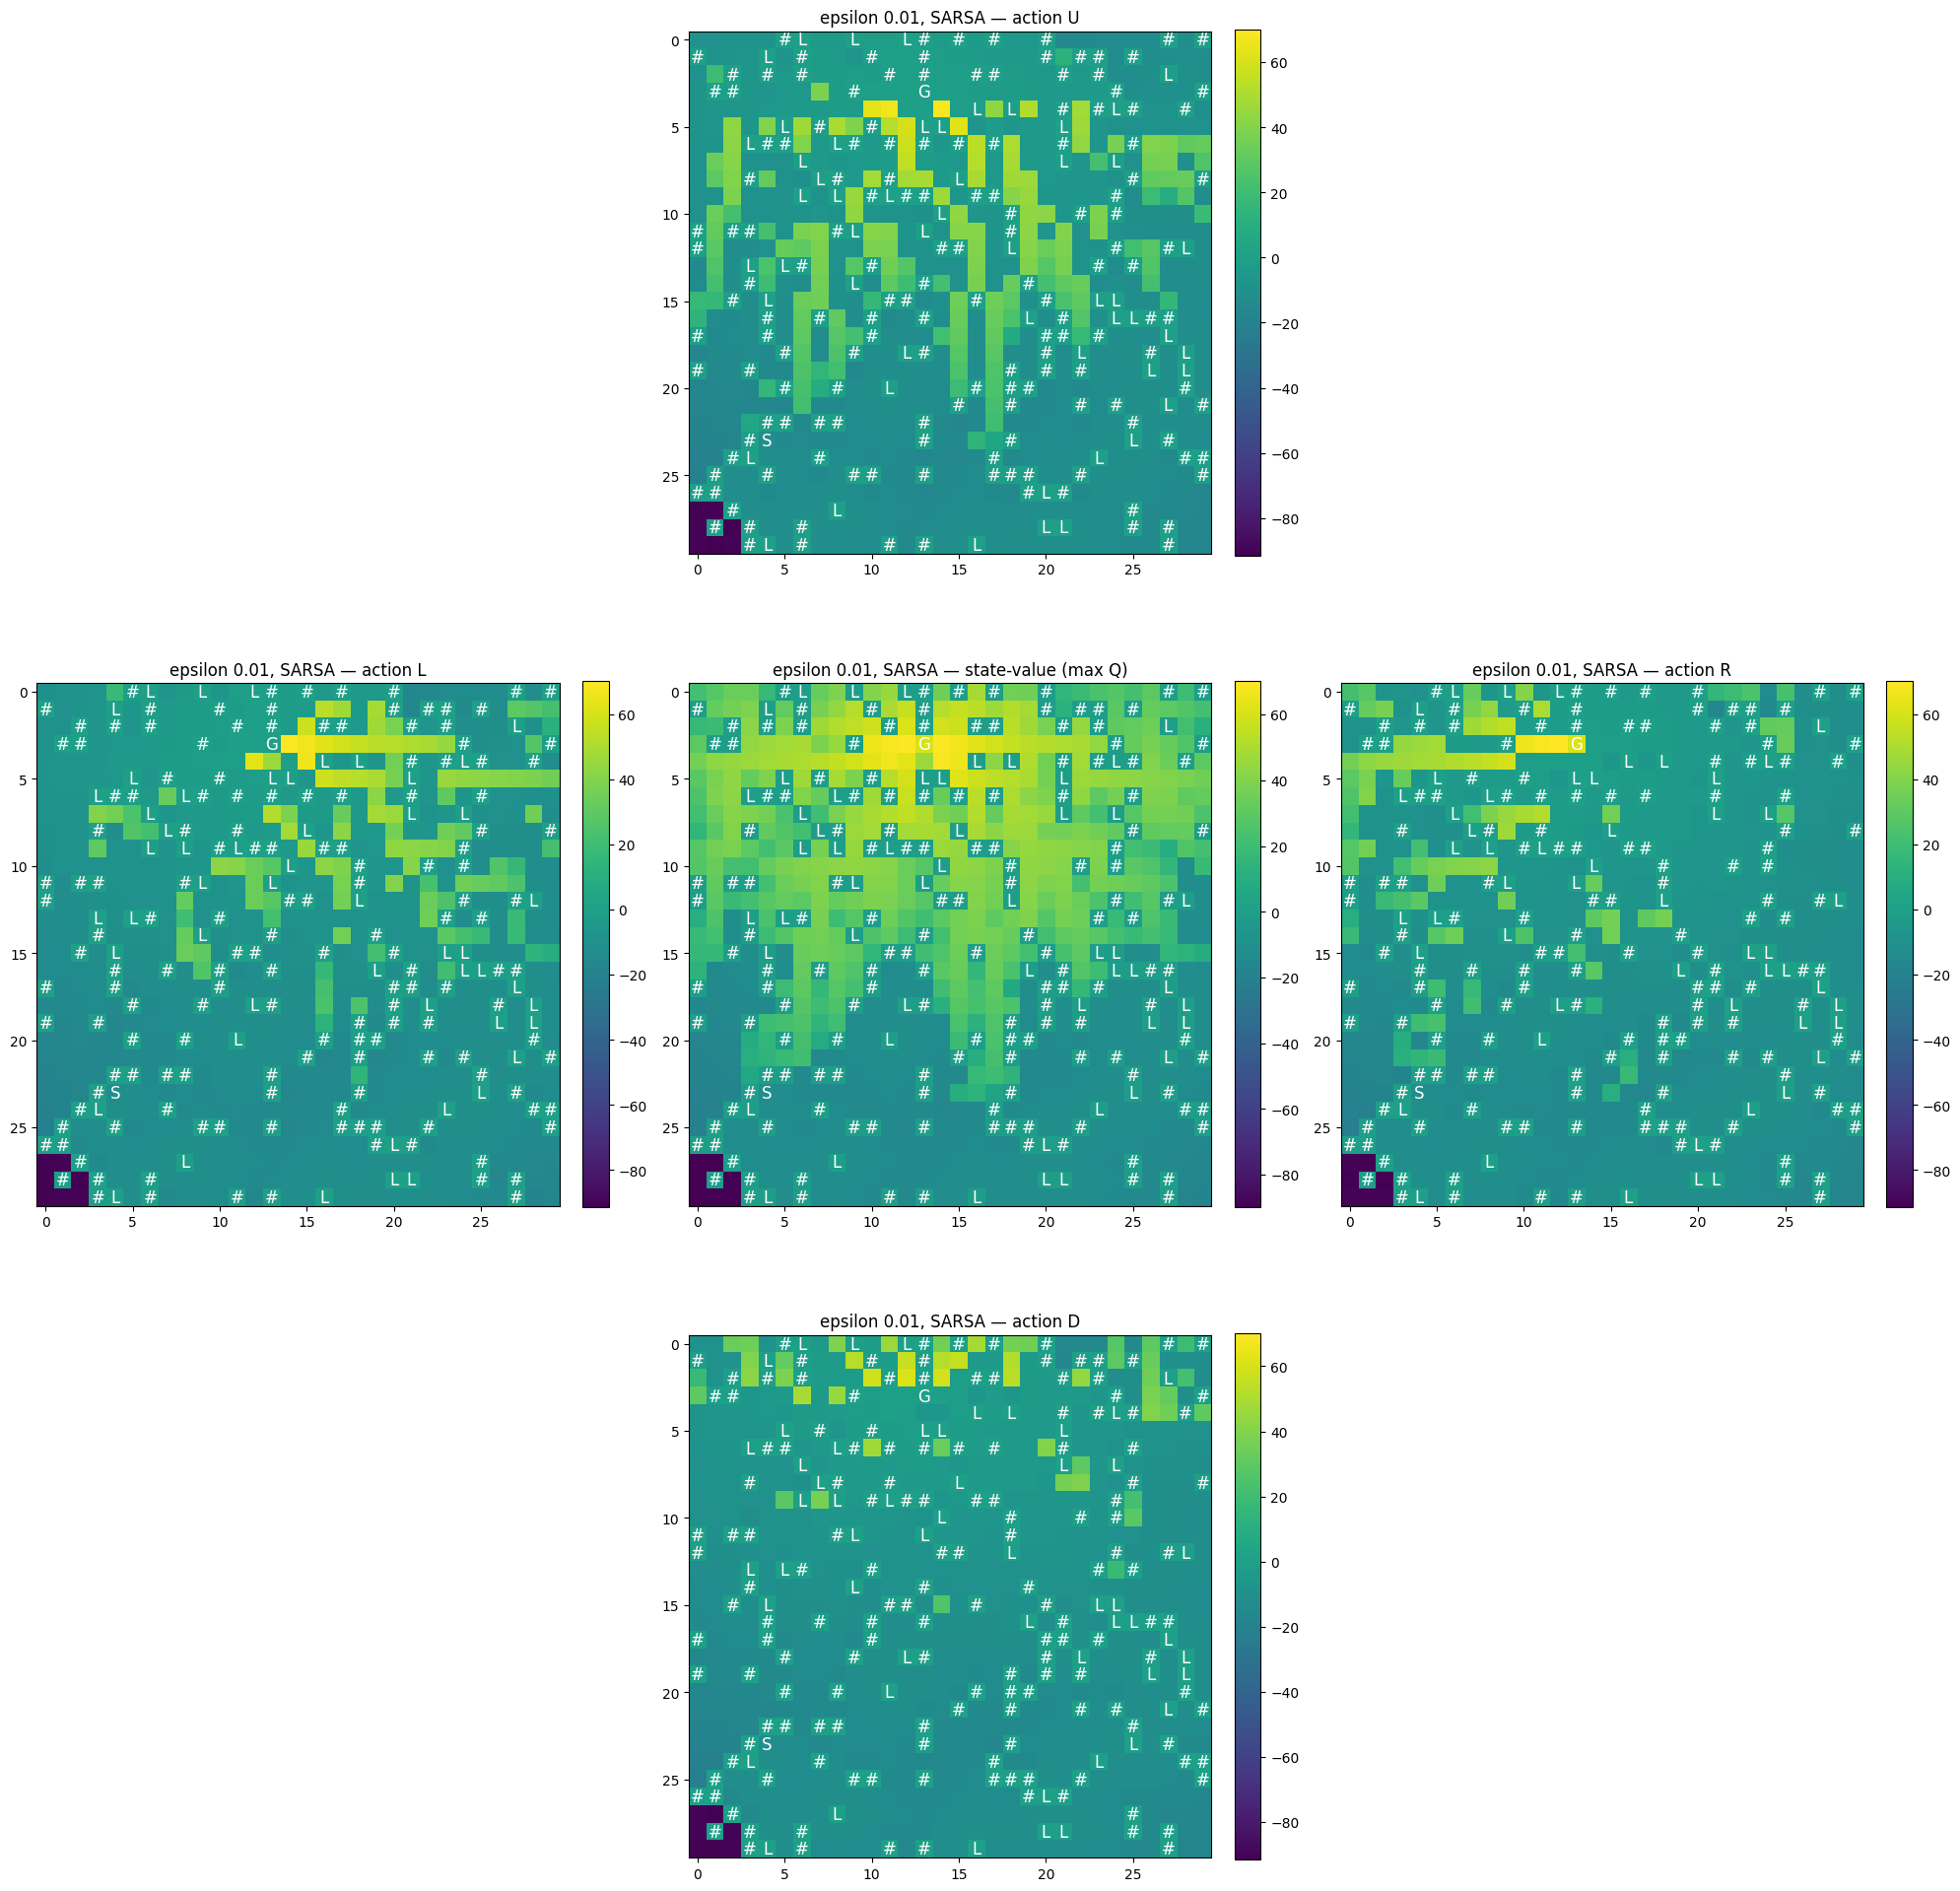

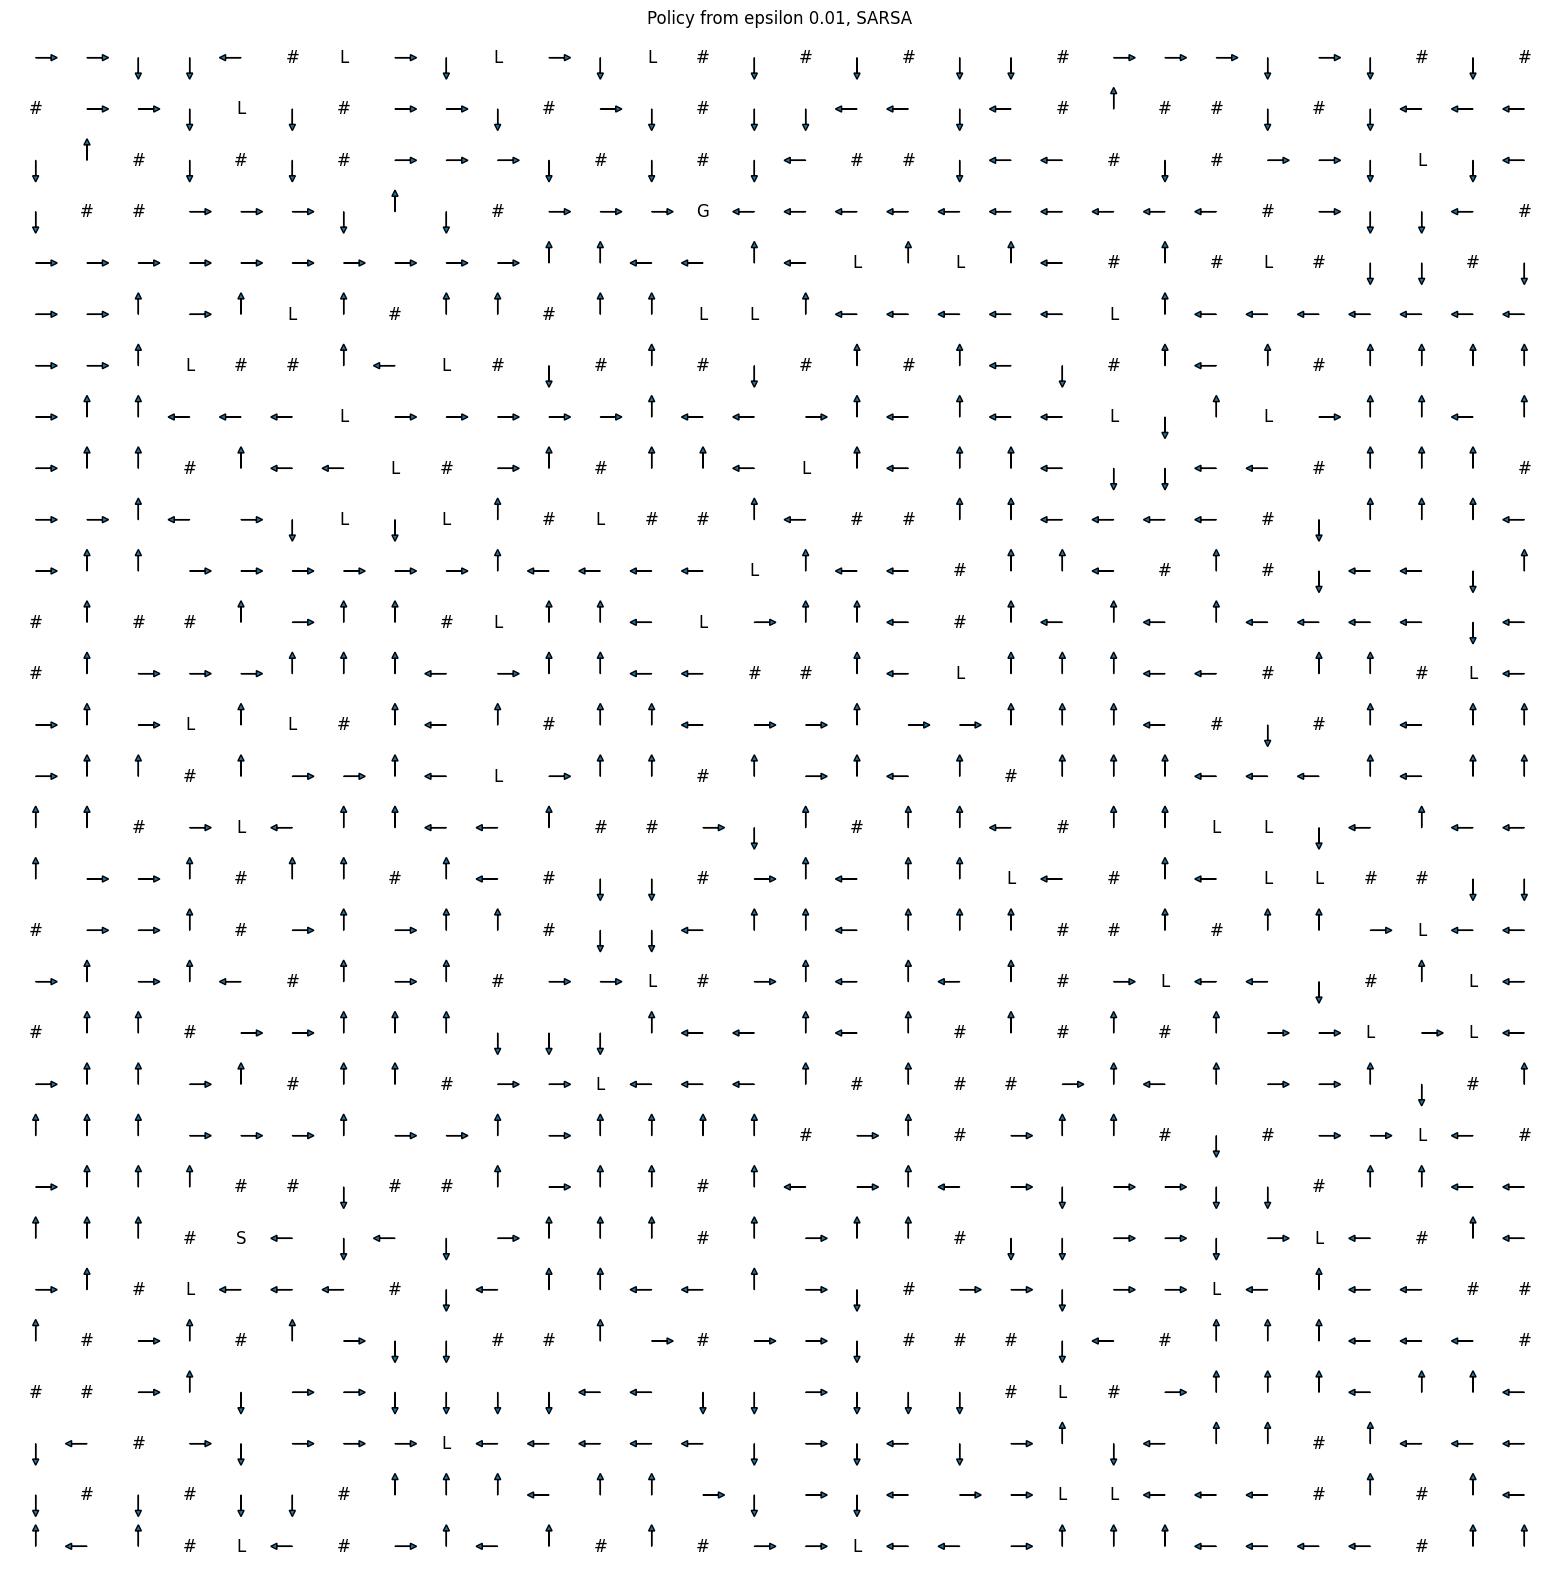

epsilon 0.1, Q Learning
. . . . . # L . . L . . L # . # . # . . # . . . . . . # . #
# . . . L . # . . . # . . # . . . . . . # . # # . # . . . .
. . # . # . # . . . . # . # . . # # . . . # . # . . . L . .
. # # . . . . . . # . . . G . . . . . . . . . . # . . . . #
. . . . . . . . . . . . . . . . L . L . . # . # L # . . # .
. . . . . L . # . . # . . L L . . . . . . L . . . . . . . .
. . . L # # . . L # . # . # . # . # . . . # . . . # . . . .
. . . . . . L . . . . . . . . . . . . . . L . . L . . . . .
. . A # . . . L # . . # . . . L . . . . . . . . . # . . . #
. . . . . . L . L . # L # # . . # # . . . . . . # . . . . .
. . . . . . . . . . . . . . L . . . # . . . # . # . . . . .
# . # # . . . . # L . . . L . . . . # . . . . . . . . . . .
# . . . . . . . . . . . . . # # . . L . . . . . # . . # L .
. . . L . L # . . . # . . . . . . . . . . . . # . # . . . .
. . . # . . . . . L . . . # . . . . . # . . . . . . . . . .
. . # . L . . . . . . # # . . . # . . . # . . L L . . . . .
. . . . # . . # 

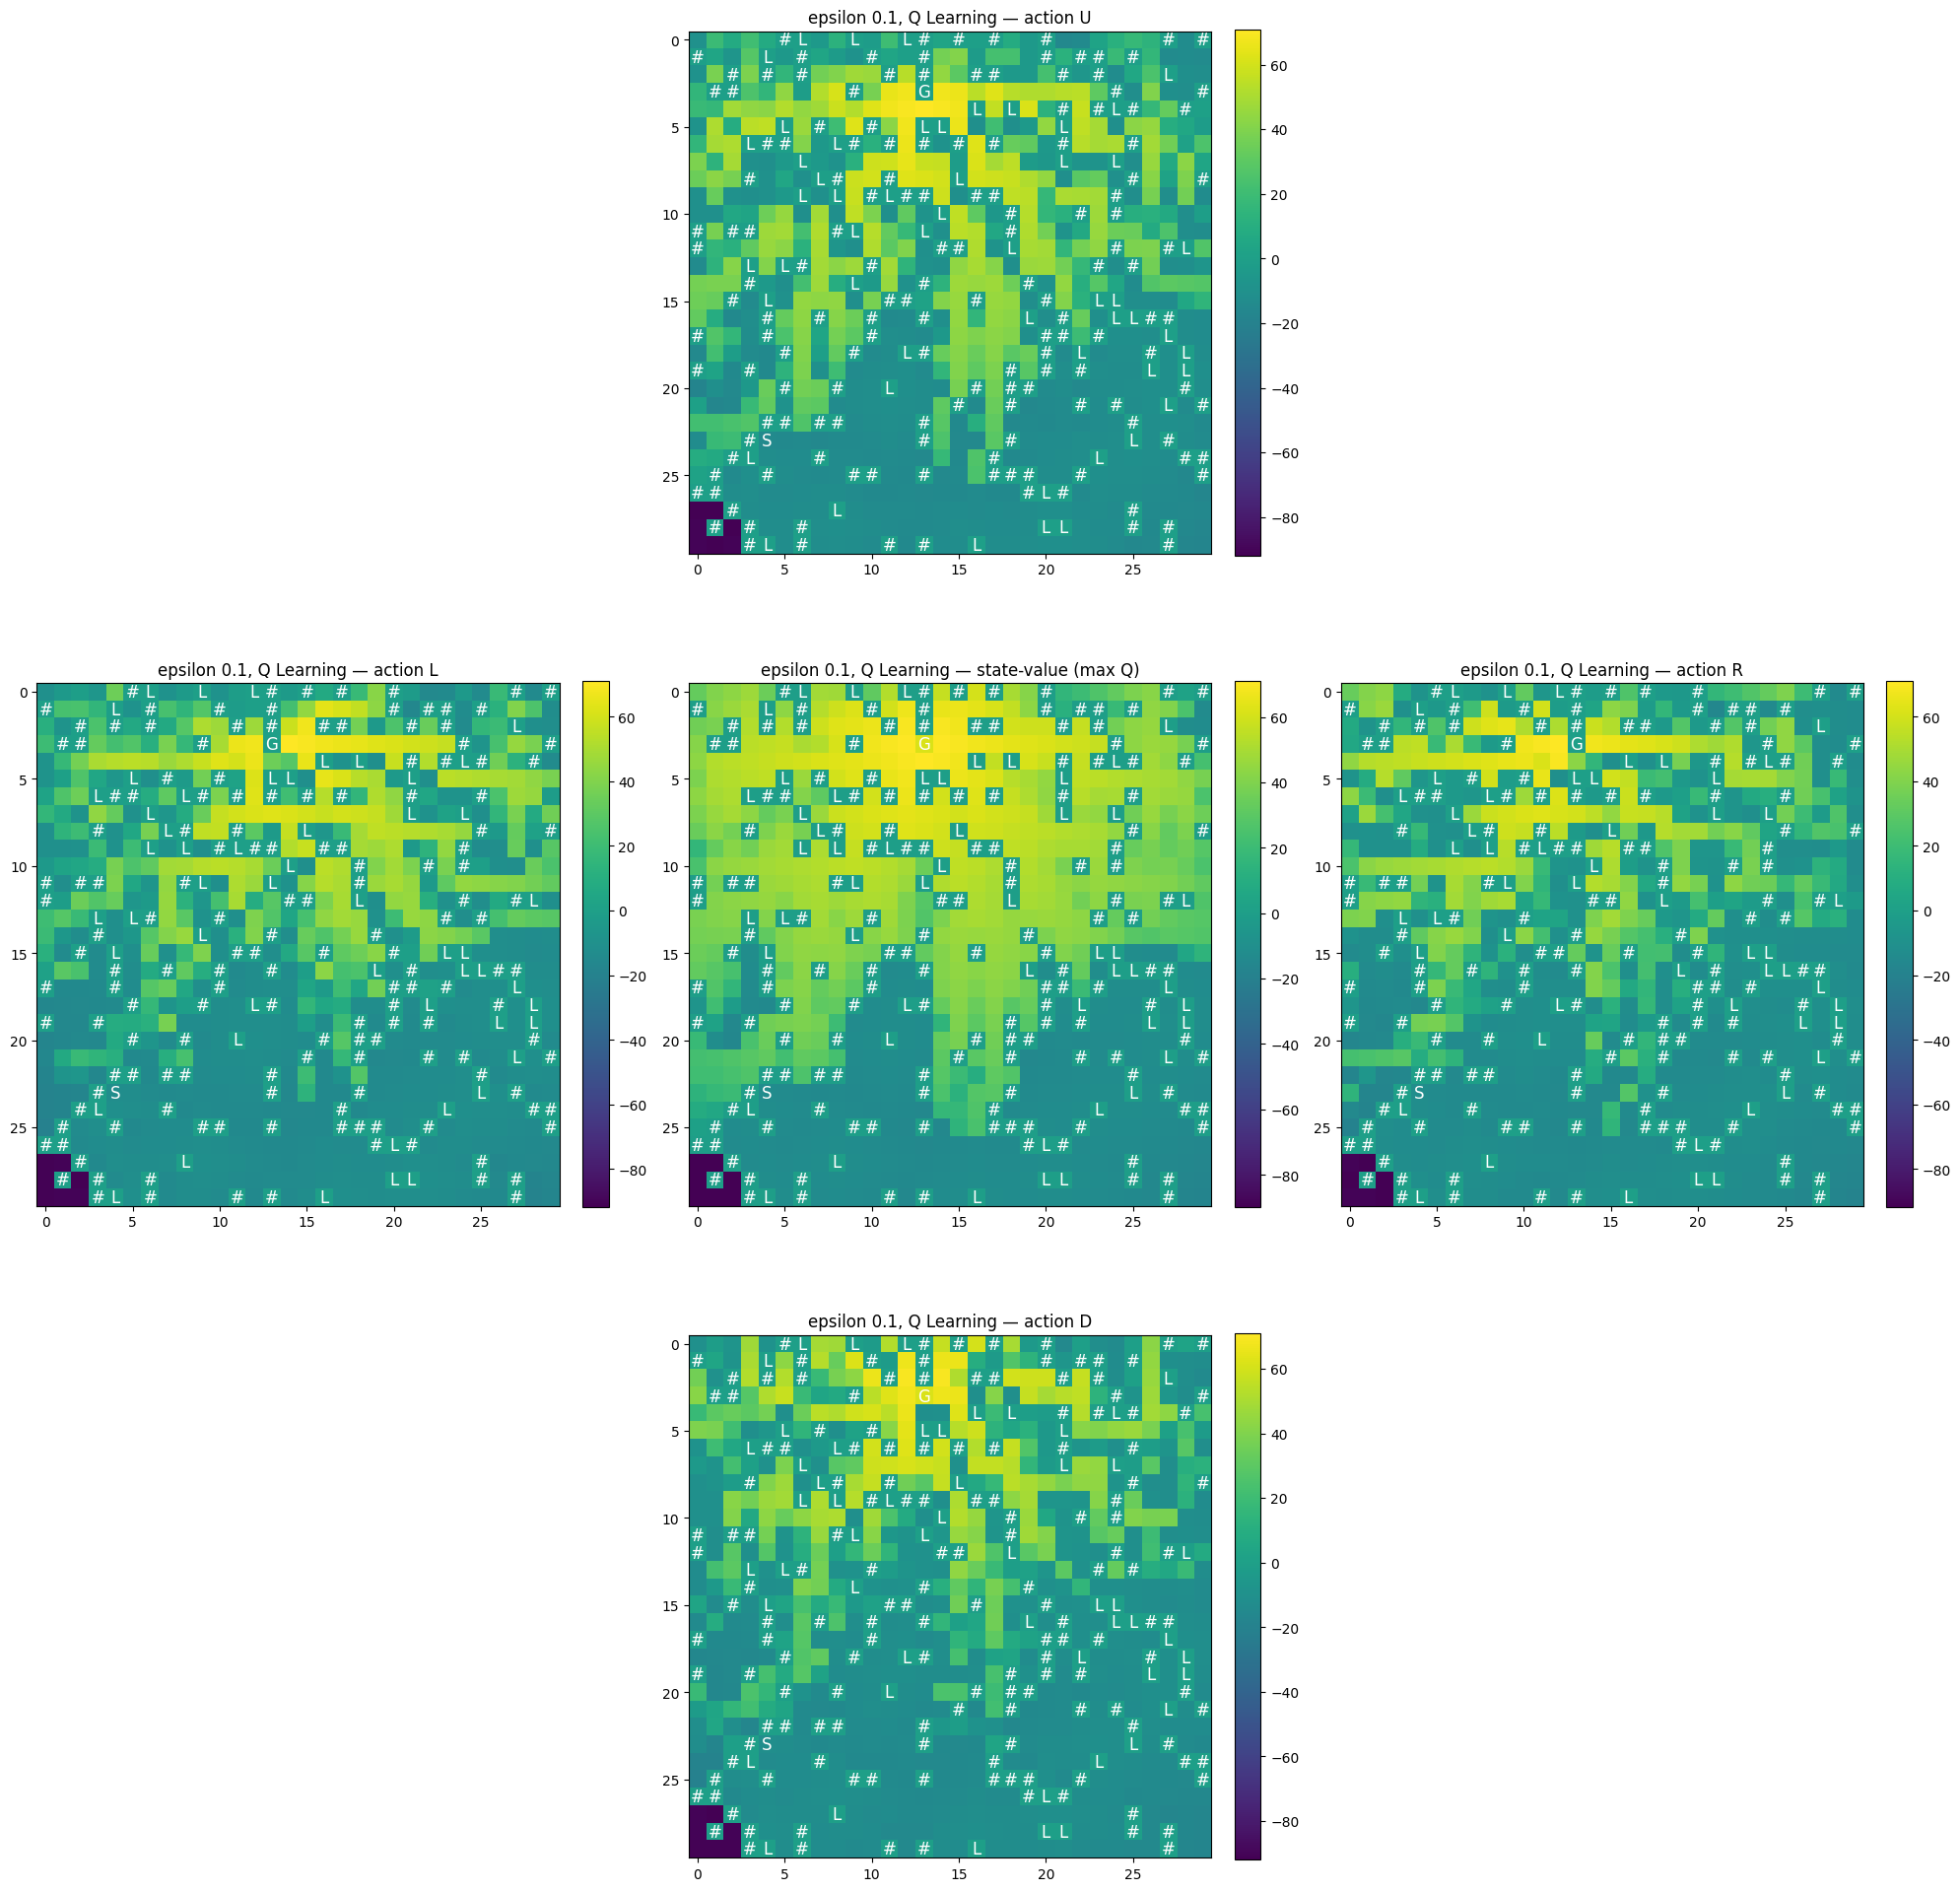

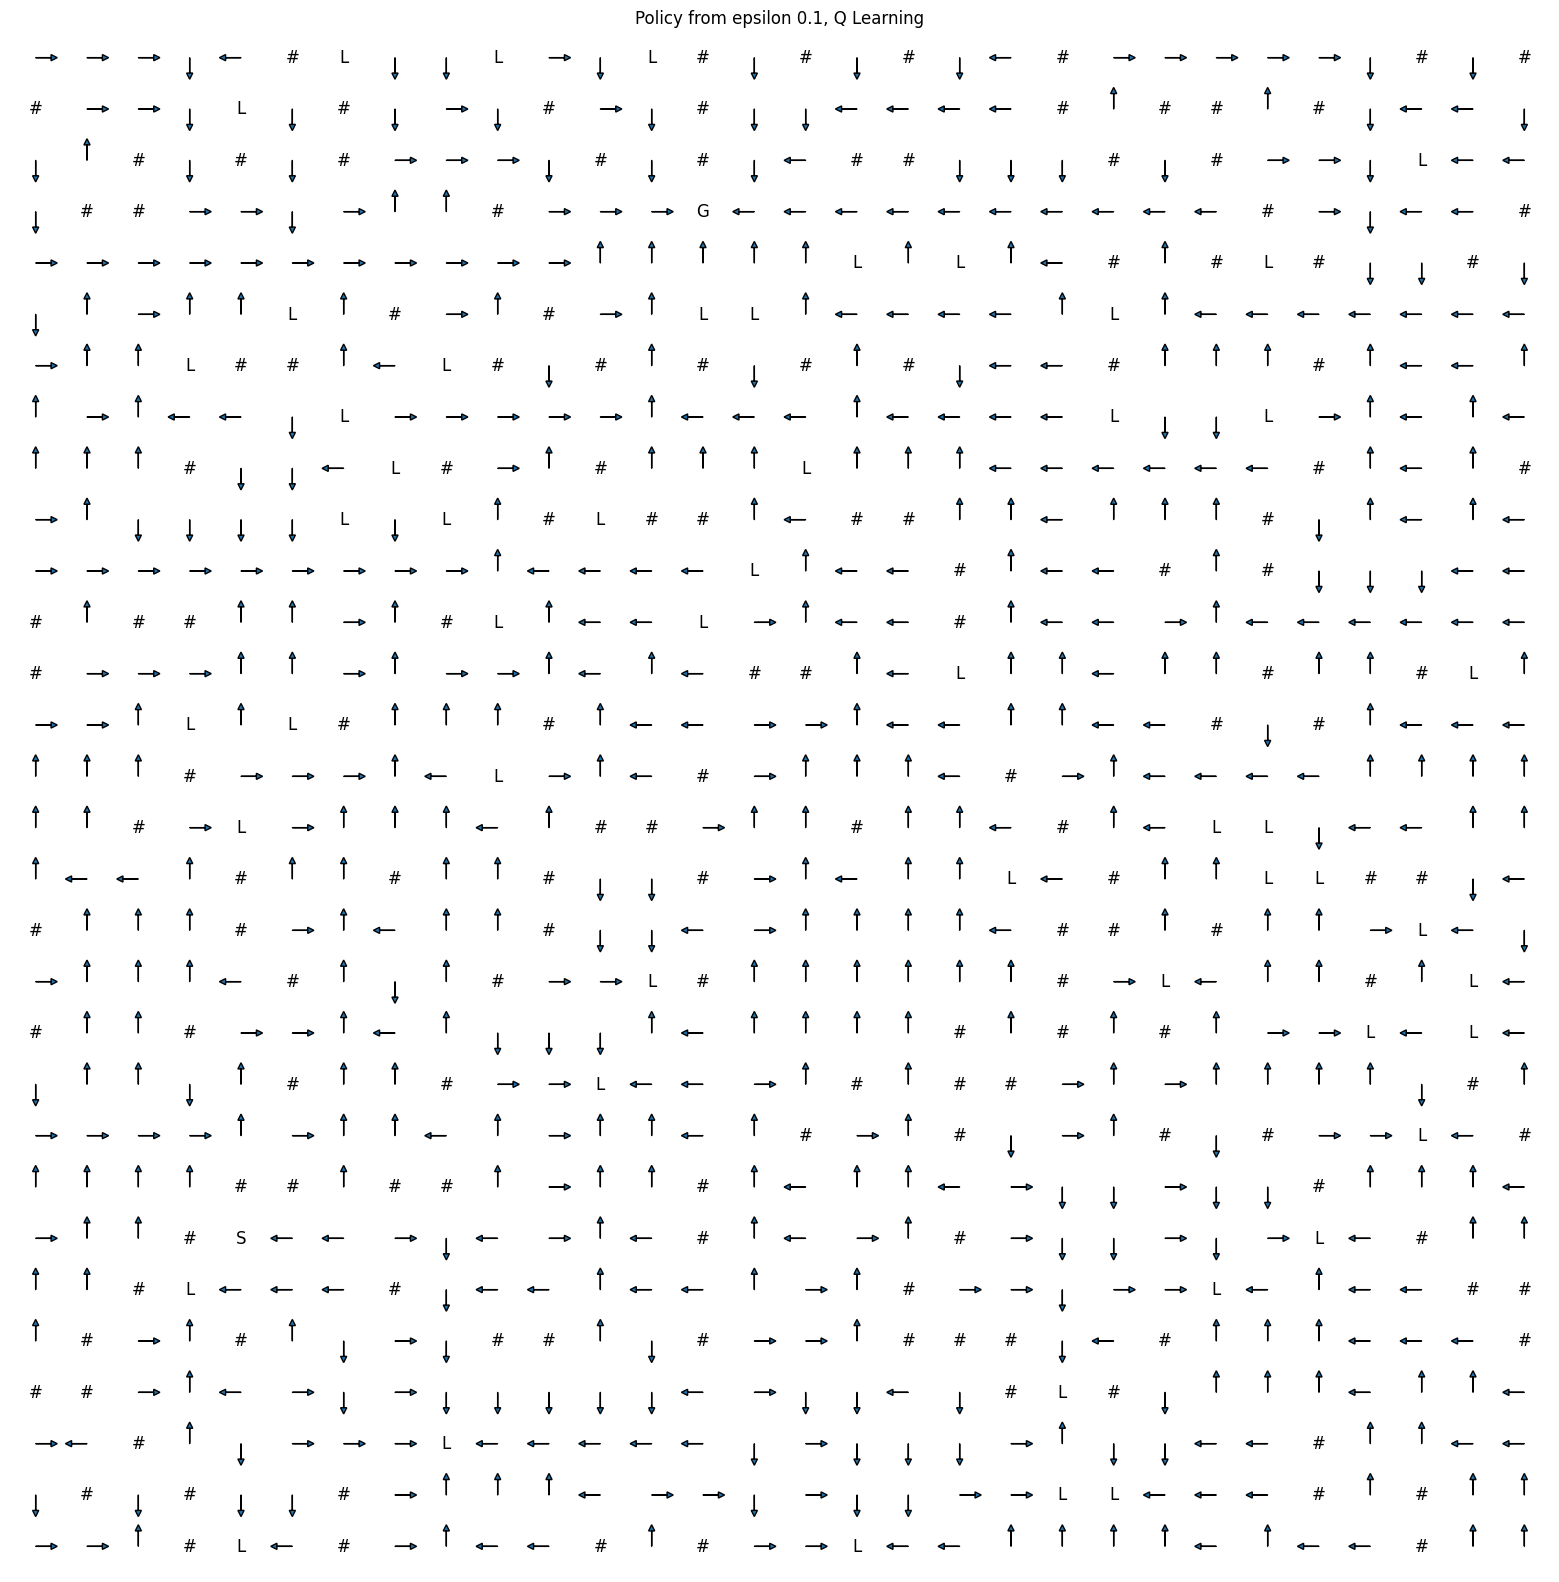

epsilon 0.1, SARSA
. . . . . # L . . L . . L # . # . # . . # . . . . . . # . #
# . . . L . # . . . # . . # . . . . . . # . # # . # . . . .
. . # . # . # . . . . # . # . . # # . . . # . # . . . L . .
. # # . . . . . . # . . . G . . . . . . . . . . # . . . . #
. . . . . . . . . . . . . . . . L . L . . # . # L # . . # .
. . . . . L . # . . # . . L L . . . . . . L . . . . . . . .
. . . L # # . . L # . # . # . # . # . . . # . . . # . . . .
. . . . . . L . . . . . . . . . . . . . . L . . L . . . . .
. . . # . . . L # . . # . . . L . . . . . . . . . # . . . #
. . . . . . L . L . # L # # . . # # . . . . . . # . . . . .
. . . . . . . . . . . . . . L . . . # . . . # . # . . . . .
# . # # . . . . # L . . . L . . . . # . . . . . . . . . . .
# . . . . . . . . . . . . . # # . . L . . . . . # . . # L .
. . . L . L # . . . # . . . . . . . . . . . . # . # . . . .
. . . # . . . . . L . . . # . . . . . # . . . . . . . . . .
. . # . L . . . . . . # # . . . # . . . # . . L L . . . . .
. . . . # . . # . . #

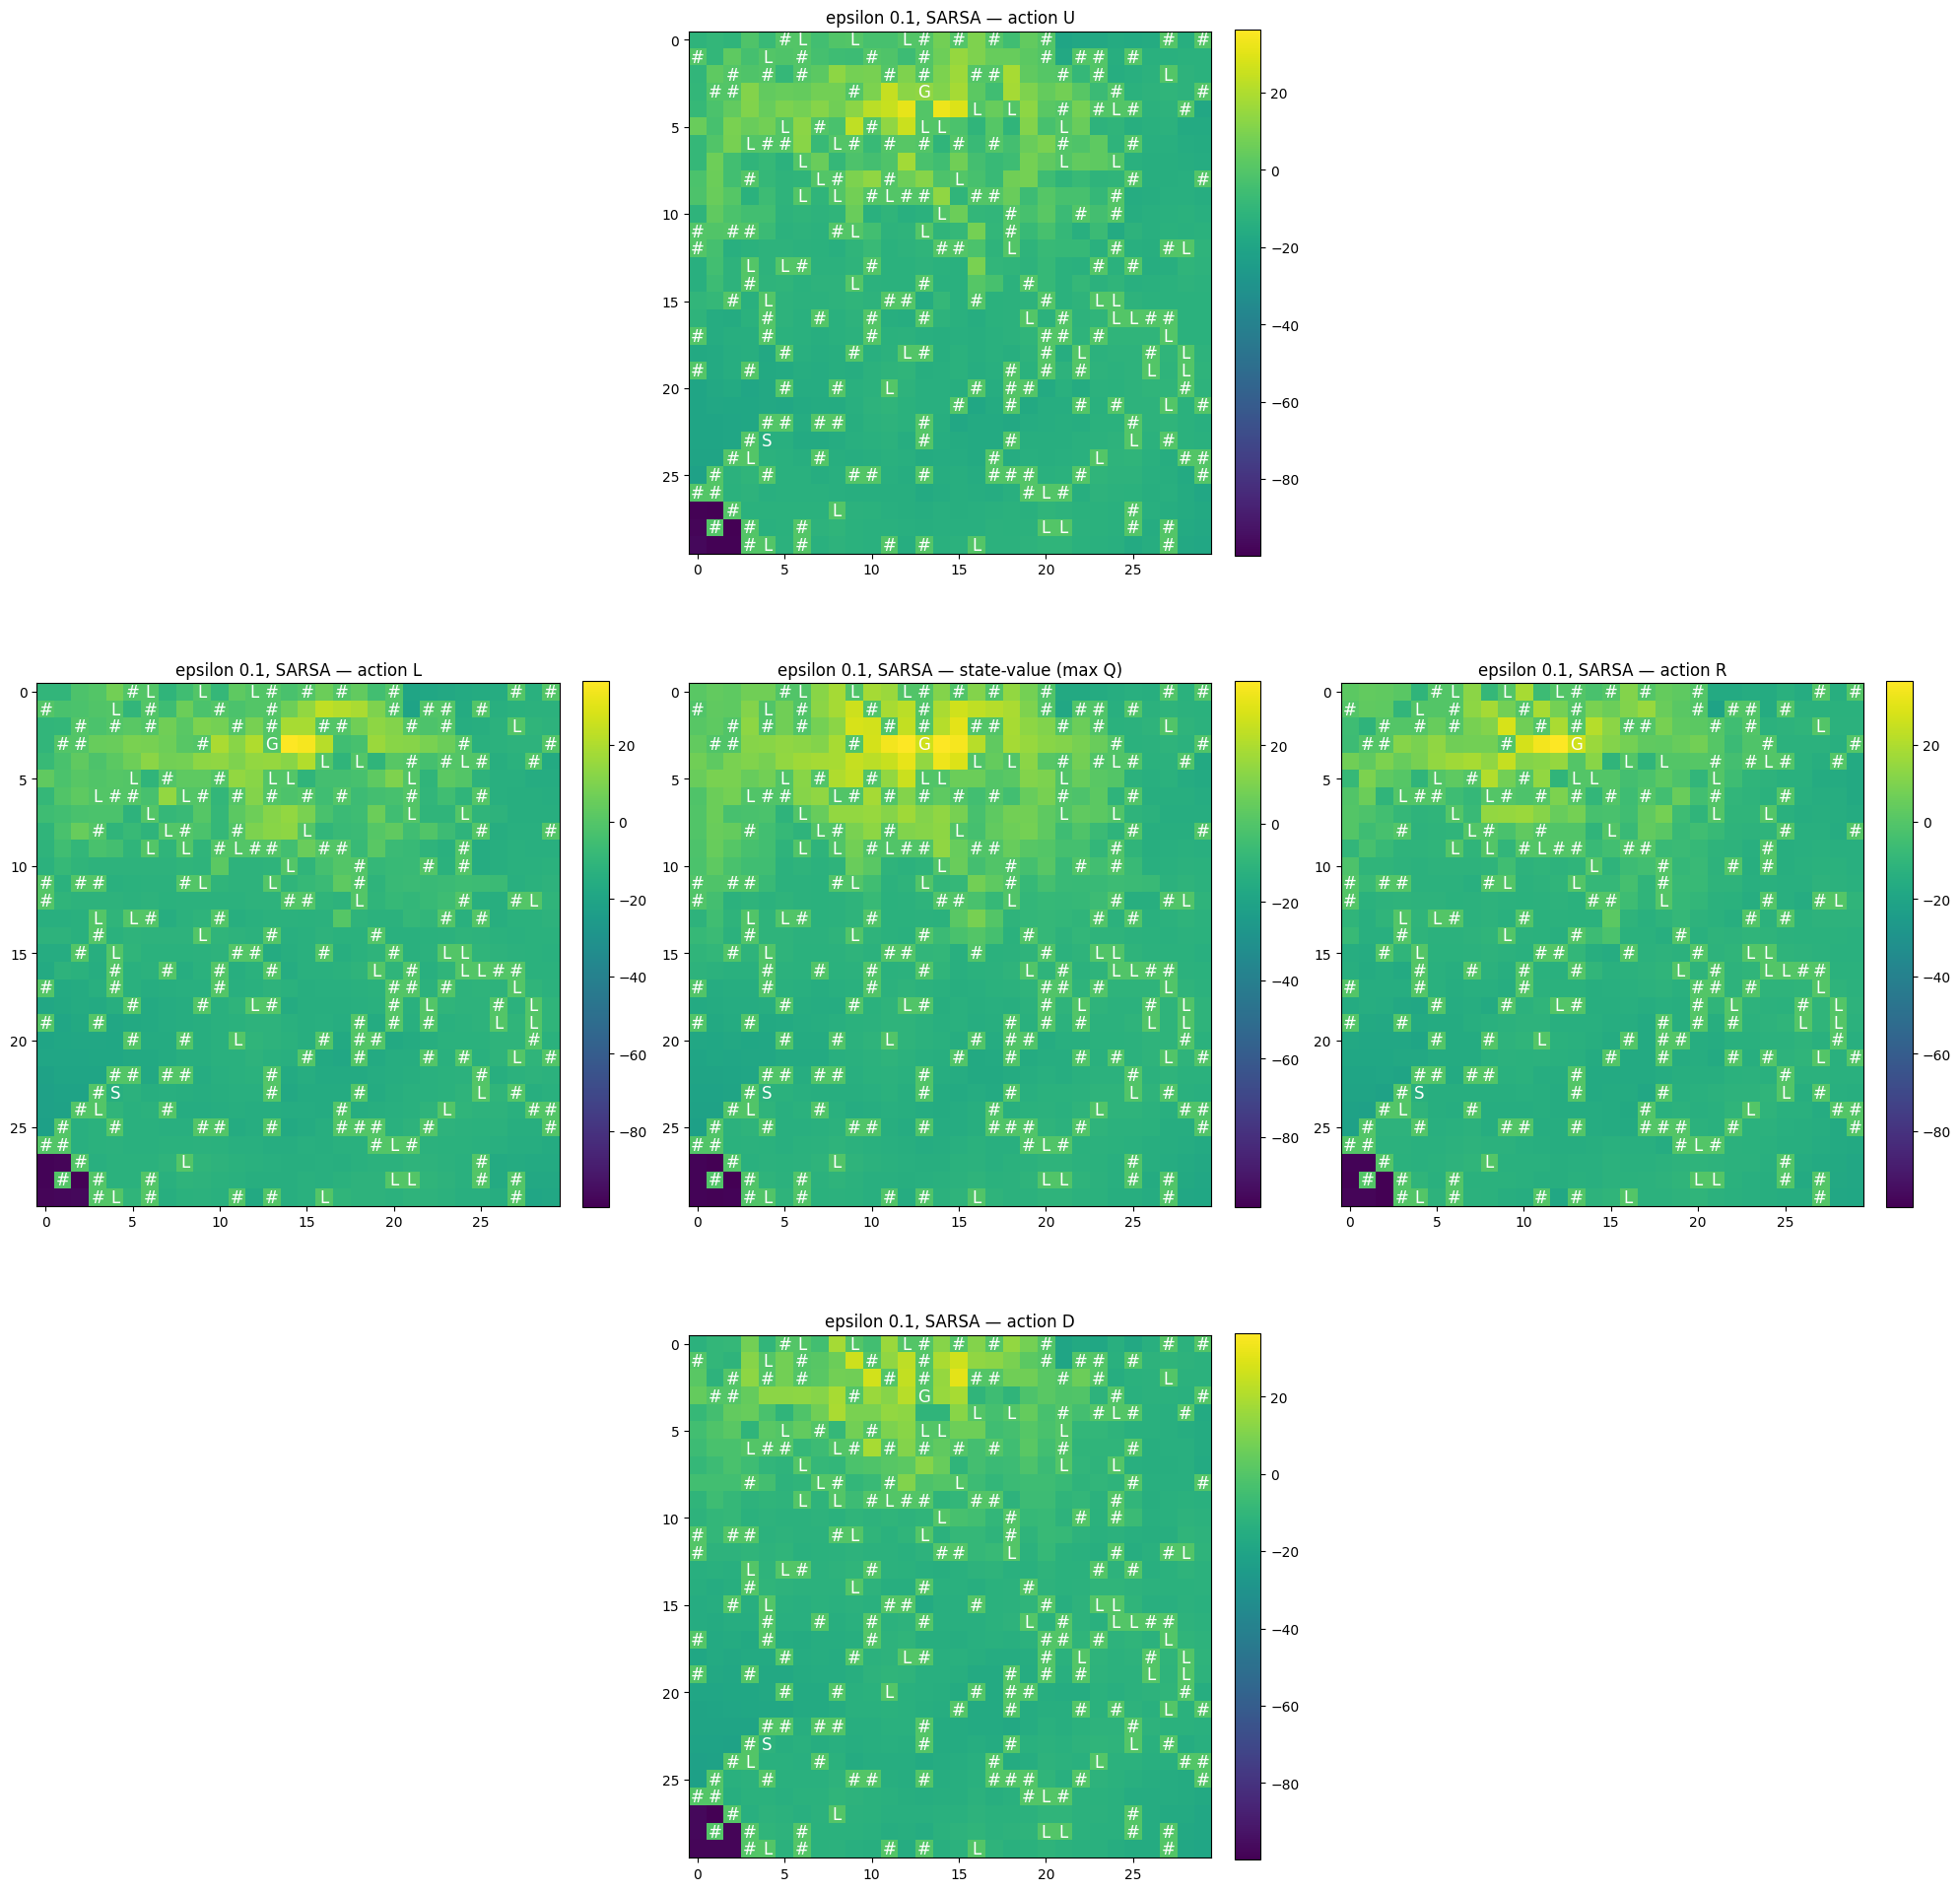

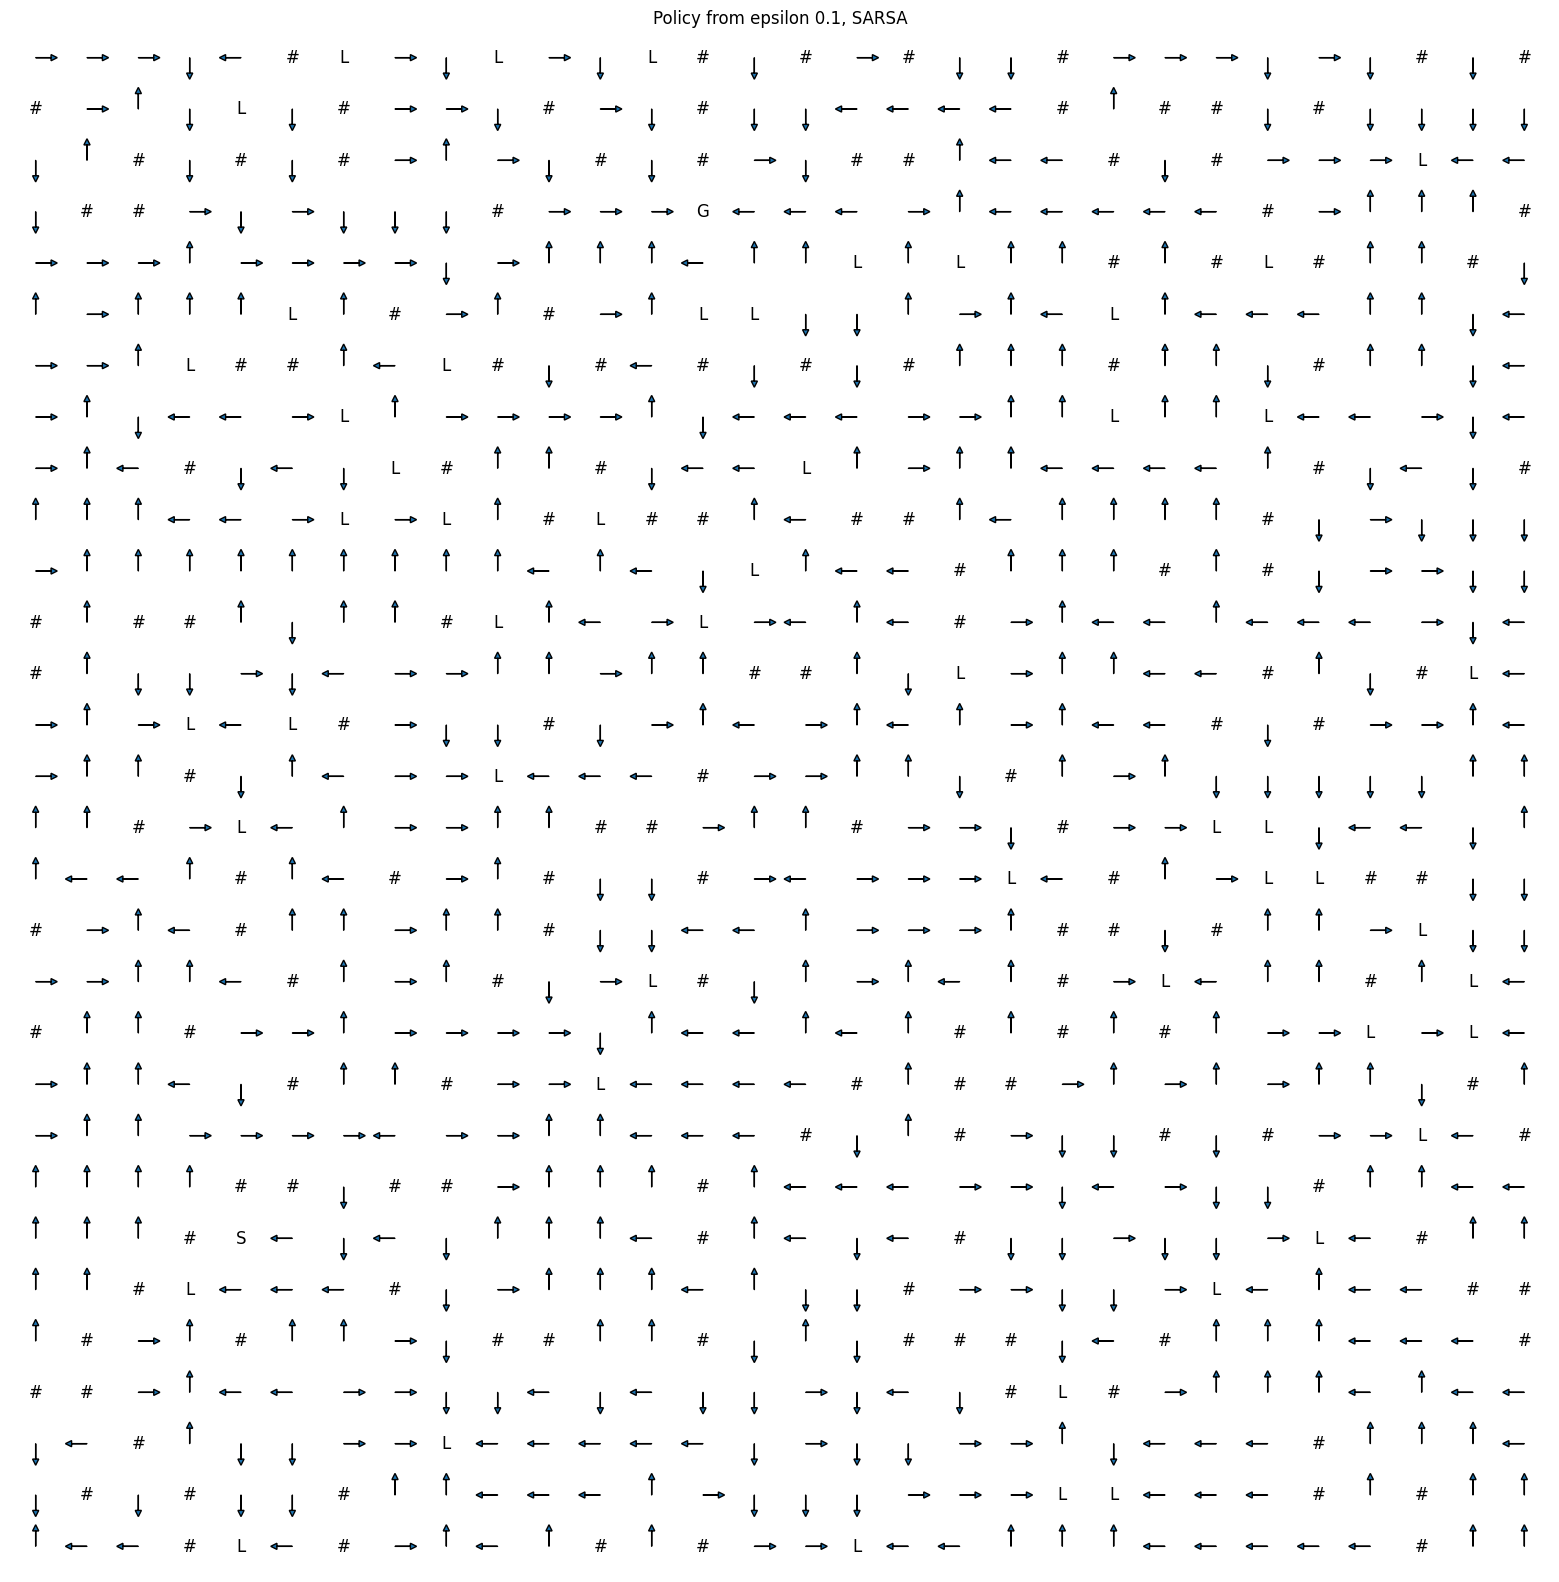

epsilon 0.3, Q Learning
. . . . . # L . . L . . L # . # . # . . # . . . . . . # . #
# . . . L . # . . . # . . # . . . . . . # . # # . # . . . .
. . # . # . # . . . . # . # . . # # . . . # . # . . . L . .
. # # . . . . . . # . . . G . . . . . . . . . . # . . . . #
. . . . . . . . . . . . . . . . L . L . . # . # L # . . # .
. . . . . L . # . . # . . L L . . . . . . L . . . . . . . .
. . . L # # . . L # . # . # . # . # . . . # . . . # . . . .
. . . . . . L . . . . . . . . . . . . . . L . . L . . . . .
. . A # . . . L # . . # . . . L . . . . . . . . . # . . . #
. . . . . . L . L . # L # # . . # # . . . . . . # . . . . .
. . . . . . . . . . . . . . L . . . # . . . # . # . . . . .
# . # # . . . . # L . . . L . . . . # . . . . . . . . . . .
# . . . . . . . . . . . . . # # . . L . . . . . # . . # L .
. . . L . L # . . . # . . . . . . . . . . . . # . # . . . .
. . . # . . . . . L . . . # . . . . . # . . . . . . . . . .
. . # . L . . . . . . # # . . . # . . . # . . L L . . . . .
. . . . # . . # 

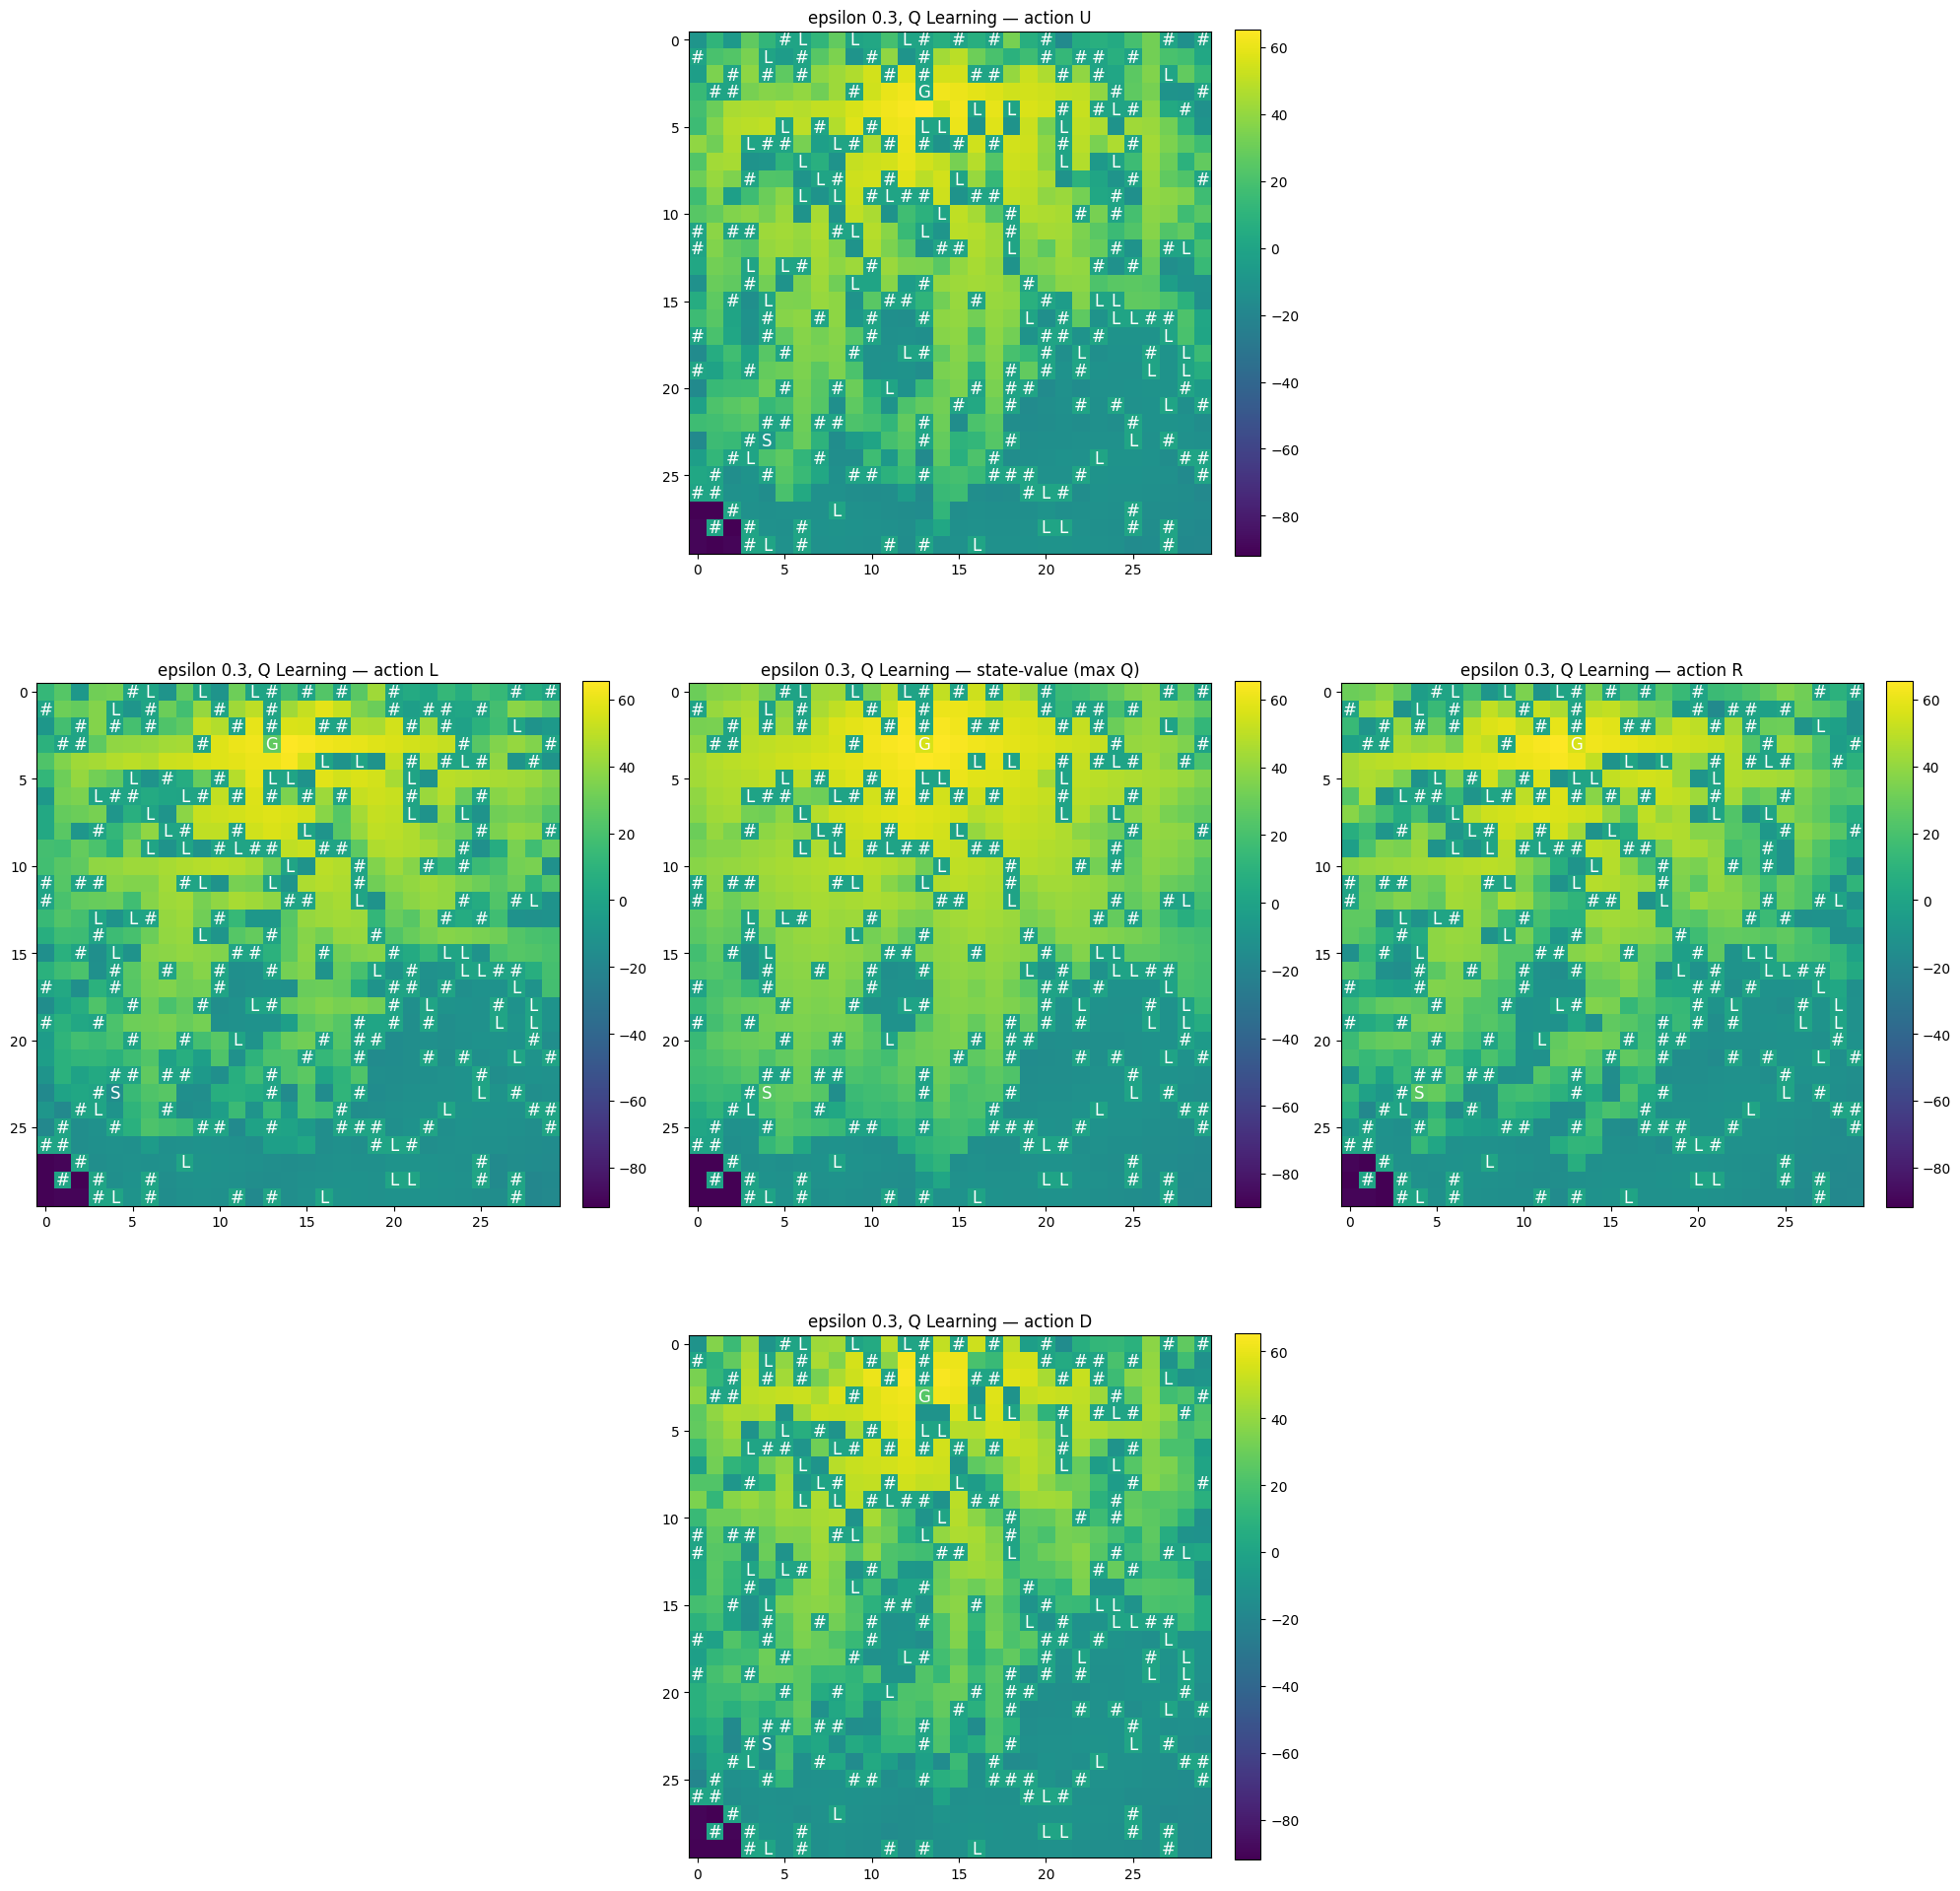

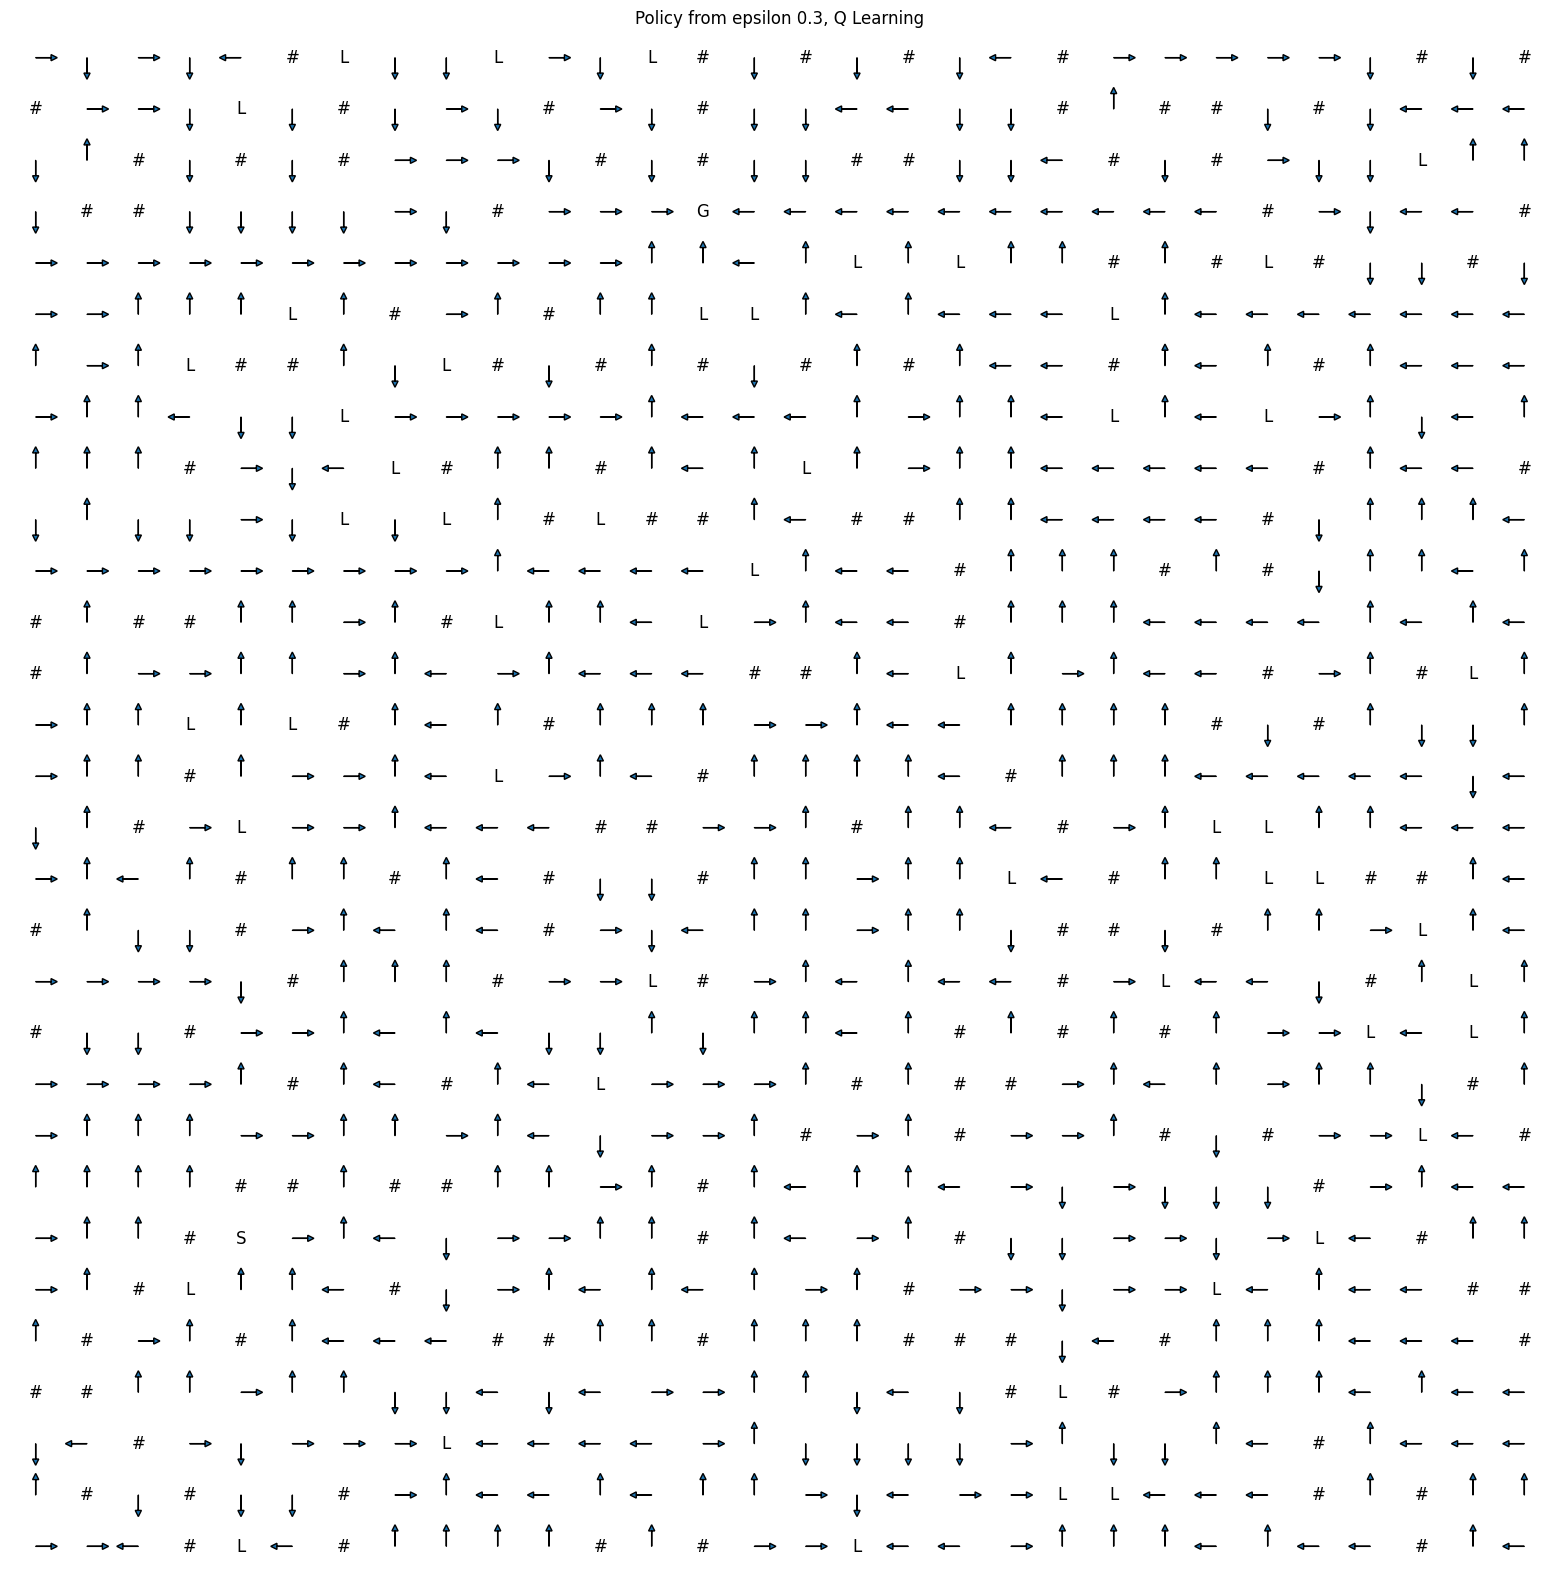

epsilon 0.3, SARSA
. . . . . # L . . L . . L # . # . # . . # . . . . . . # . #
# . . . L . # . . . # . . # . . . . . . # . # # . # . . . .
. . # . # . # . . . . # . # . . # # . . . # . # . . . L . .
. # # . . . . . . # . . . G . . . . . . . . . . # . . . . #
. . . . . . . . . . . . . . . . L . L . . # . # L # . . # .
. . . . . L . # . . # . . L L . . . . . . L . . . . . . . .
. . . L # # . . L # . # . # . # . # . . . # . . . # . . . .
. . . . . . L . . . . . . . . . . . . . . L . . L . . . . .
. . . # . . . L # . . # . . . L . . . . . . . . . # . . . #
. . . . . . L . L . # L # # . . # # . . . . . . # . . . . .
. . . . . . . . . . . . . . L . . . # . . . # . # . . . . .
# . # # . . . . # L . . . L . . . . # . . . . . . . . . . .
# . . . . . . . . . . . . . # # . . L . . . . . # . . # L .
. . . L . L # . . . # . . . . . . . . . . . . # . # . . . .
. . . # . . . . . L . . . # . . . . . # . . . . . . . . . .
. . # . L . . . . . . # # . . . # . . . # . . L L . . . . .
. . . . # . . # . . #

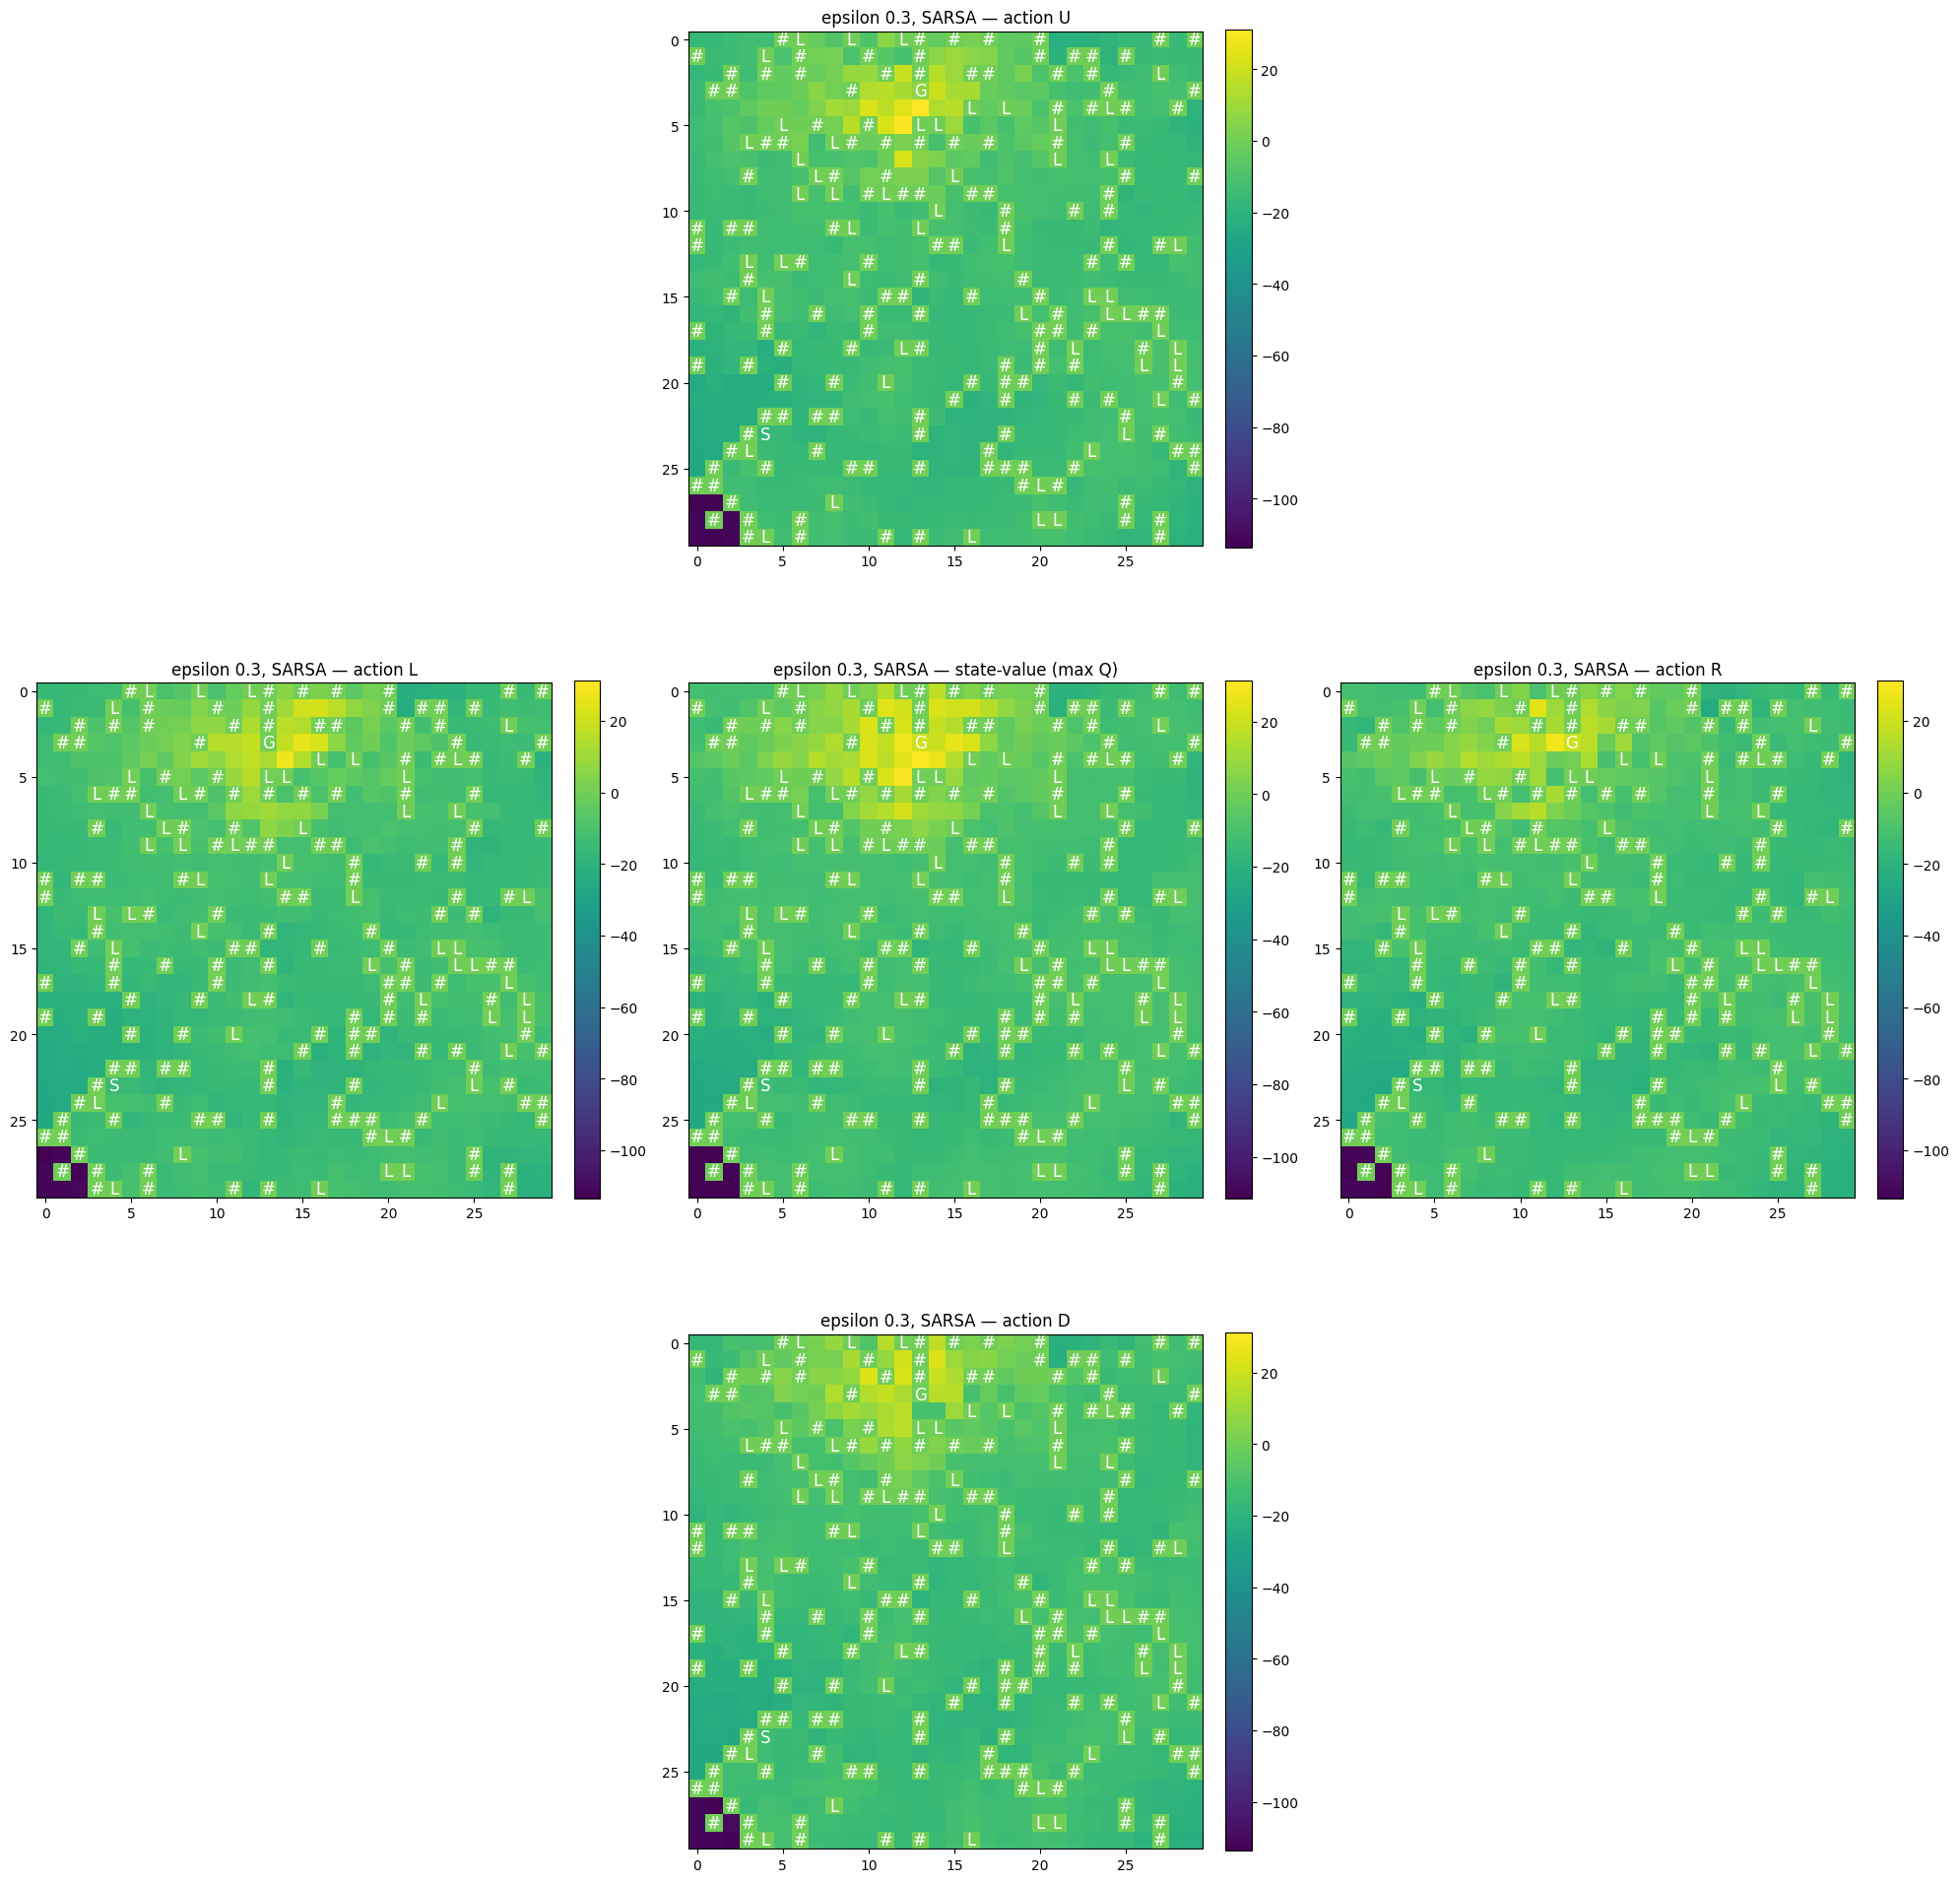

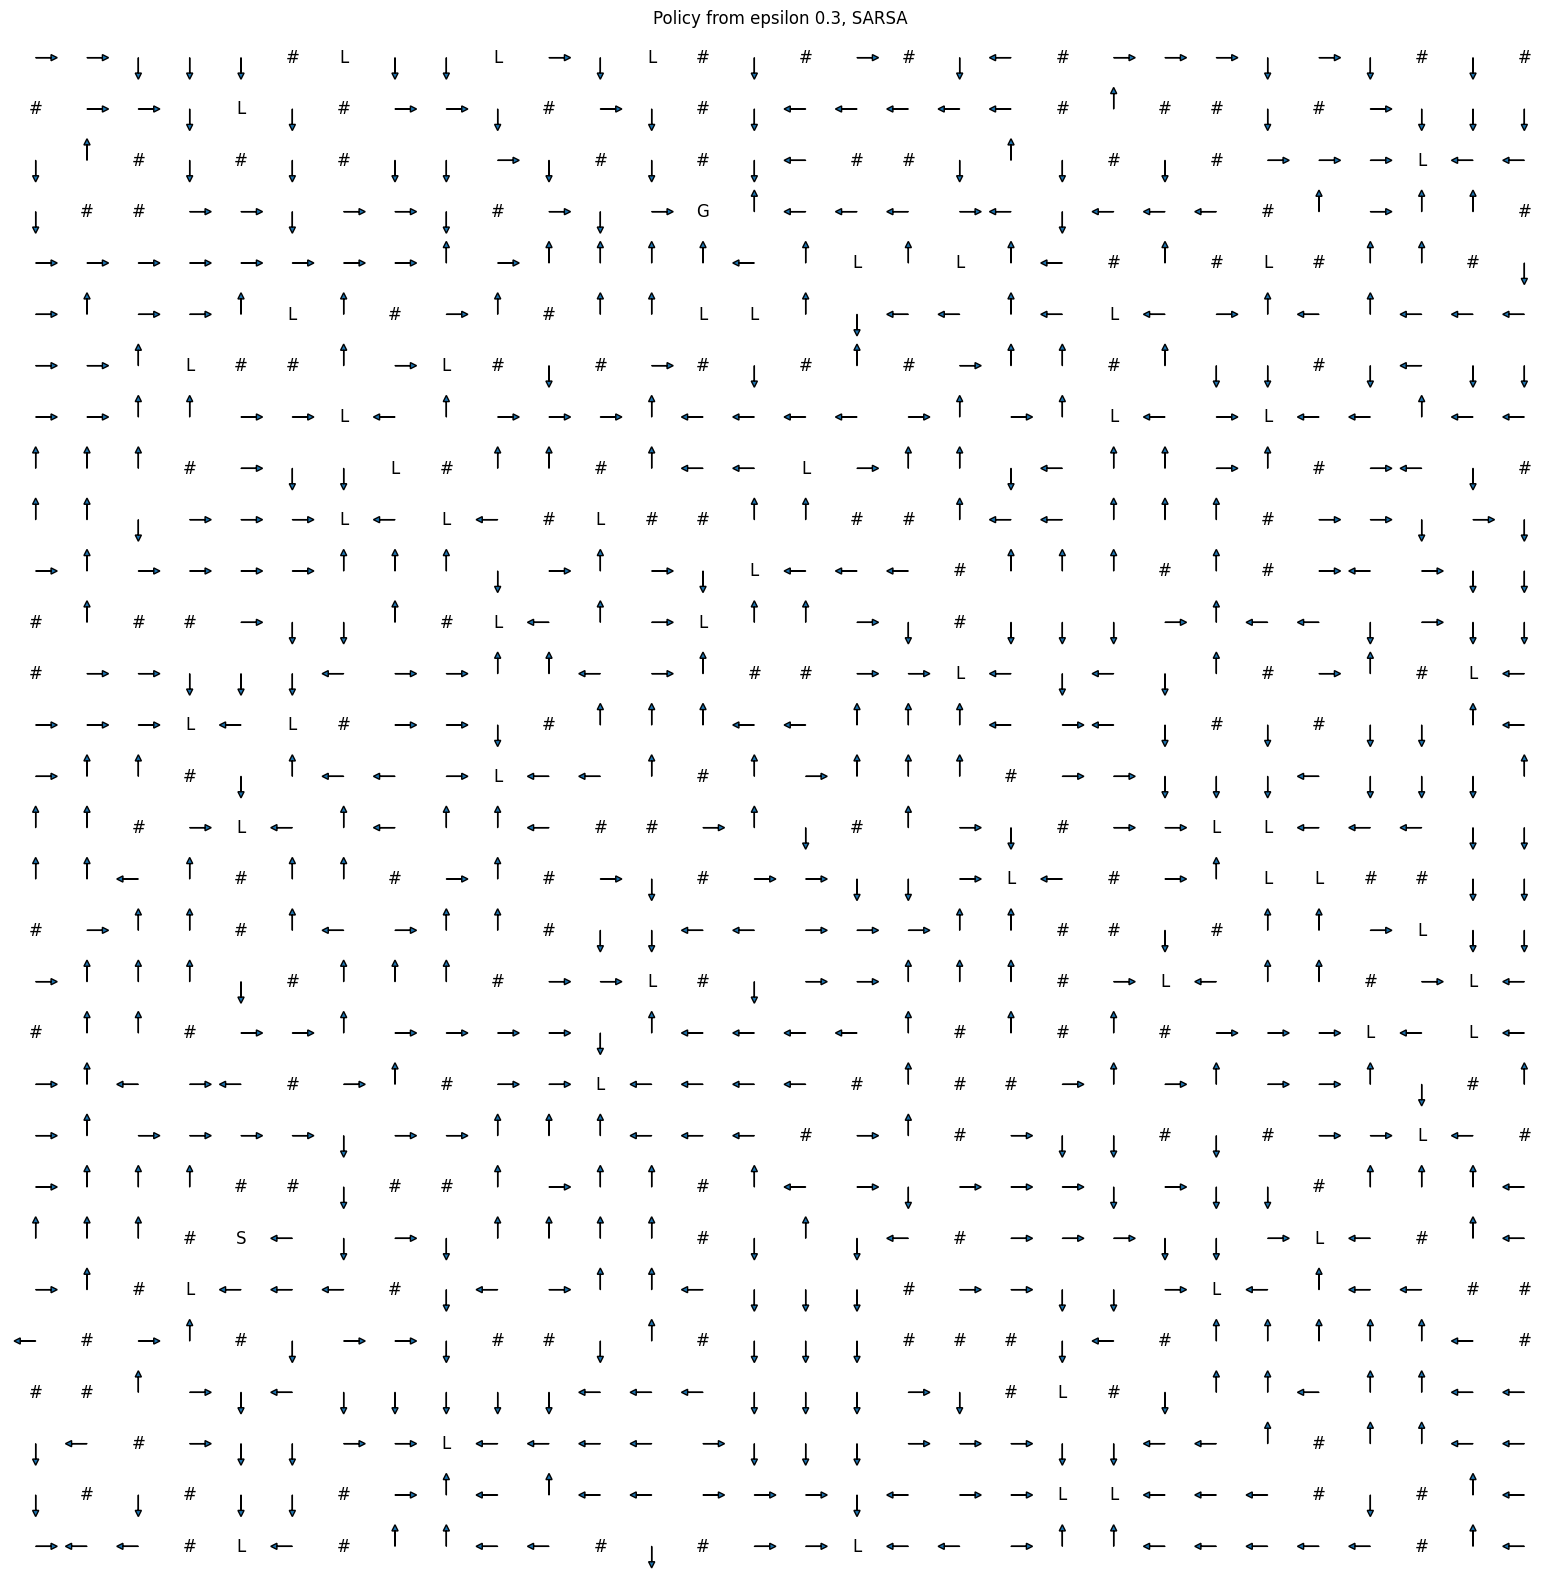

epsilon 0.7, Q Learning
. . . . . # L . . L . . L # . # . # . . # . . . . . . # . #
# . . . L . # . . . # . . # . . . . . . # . # # . # . . . .
. . # . # . # . . . . # . # . . # # . . . # . # . . . L . .
. # # . . . . . . # . . . G . . . . . . . . . . # . . . . #
. . . . . . . . . . . . . . . . L . L . . # . # L # . . # .
. . . . . L . # . . # . . L L . . . . . . L . . . . . . . .
. . . L # # . . L # . # . # . # . # . . . # . . . # . . . .
. . . . . . L . . . . . . . . . . . . . . L . . L . . . . .
. . A # . . . L # . . # . . . L . . . . . . . . . # . . . #
. . . . . . L . L . # L # # . . # # . . . . . . # . . . . .
. . . . . . . . . . . . . . L . . . # . . . # . # . . . . .
# . # # . . . . # L . . . L . . . . # . . . . . . . . . . .
# . . . . . . . . . . . . . # # . . L . . . . . # . . # L .
. . . L . L # . . . # . . . . . . . . . . . . # . # . . . .
. . . # . . . . . L . . . # . . . . . # . . . . . . . . . .
. . # . L . . . . . . # # . . . # . . . # . . L L . . . . .
. . . . # . . # 

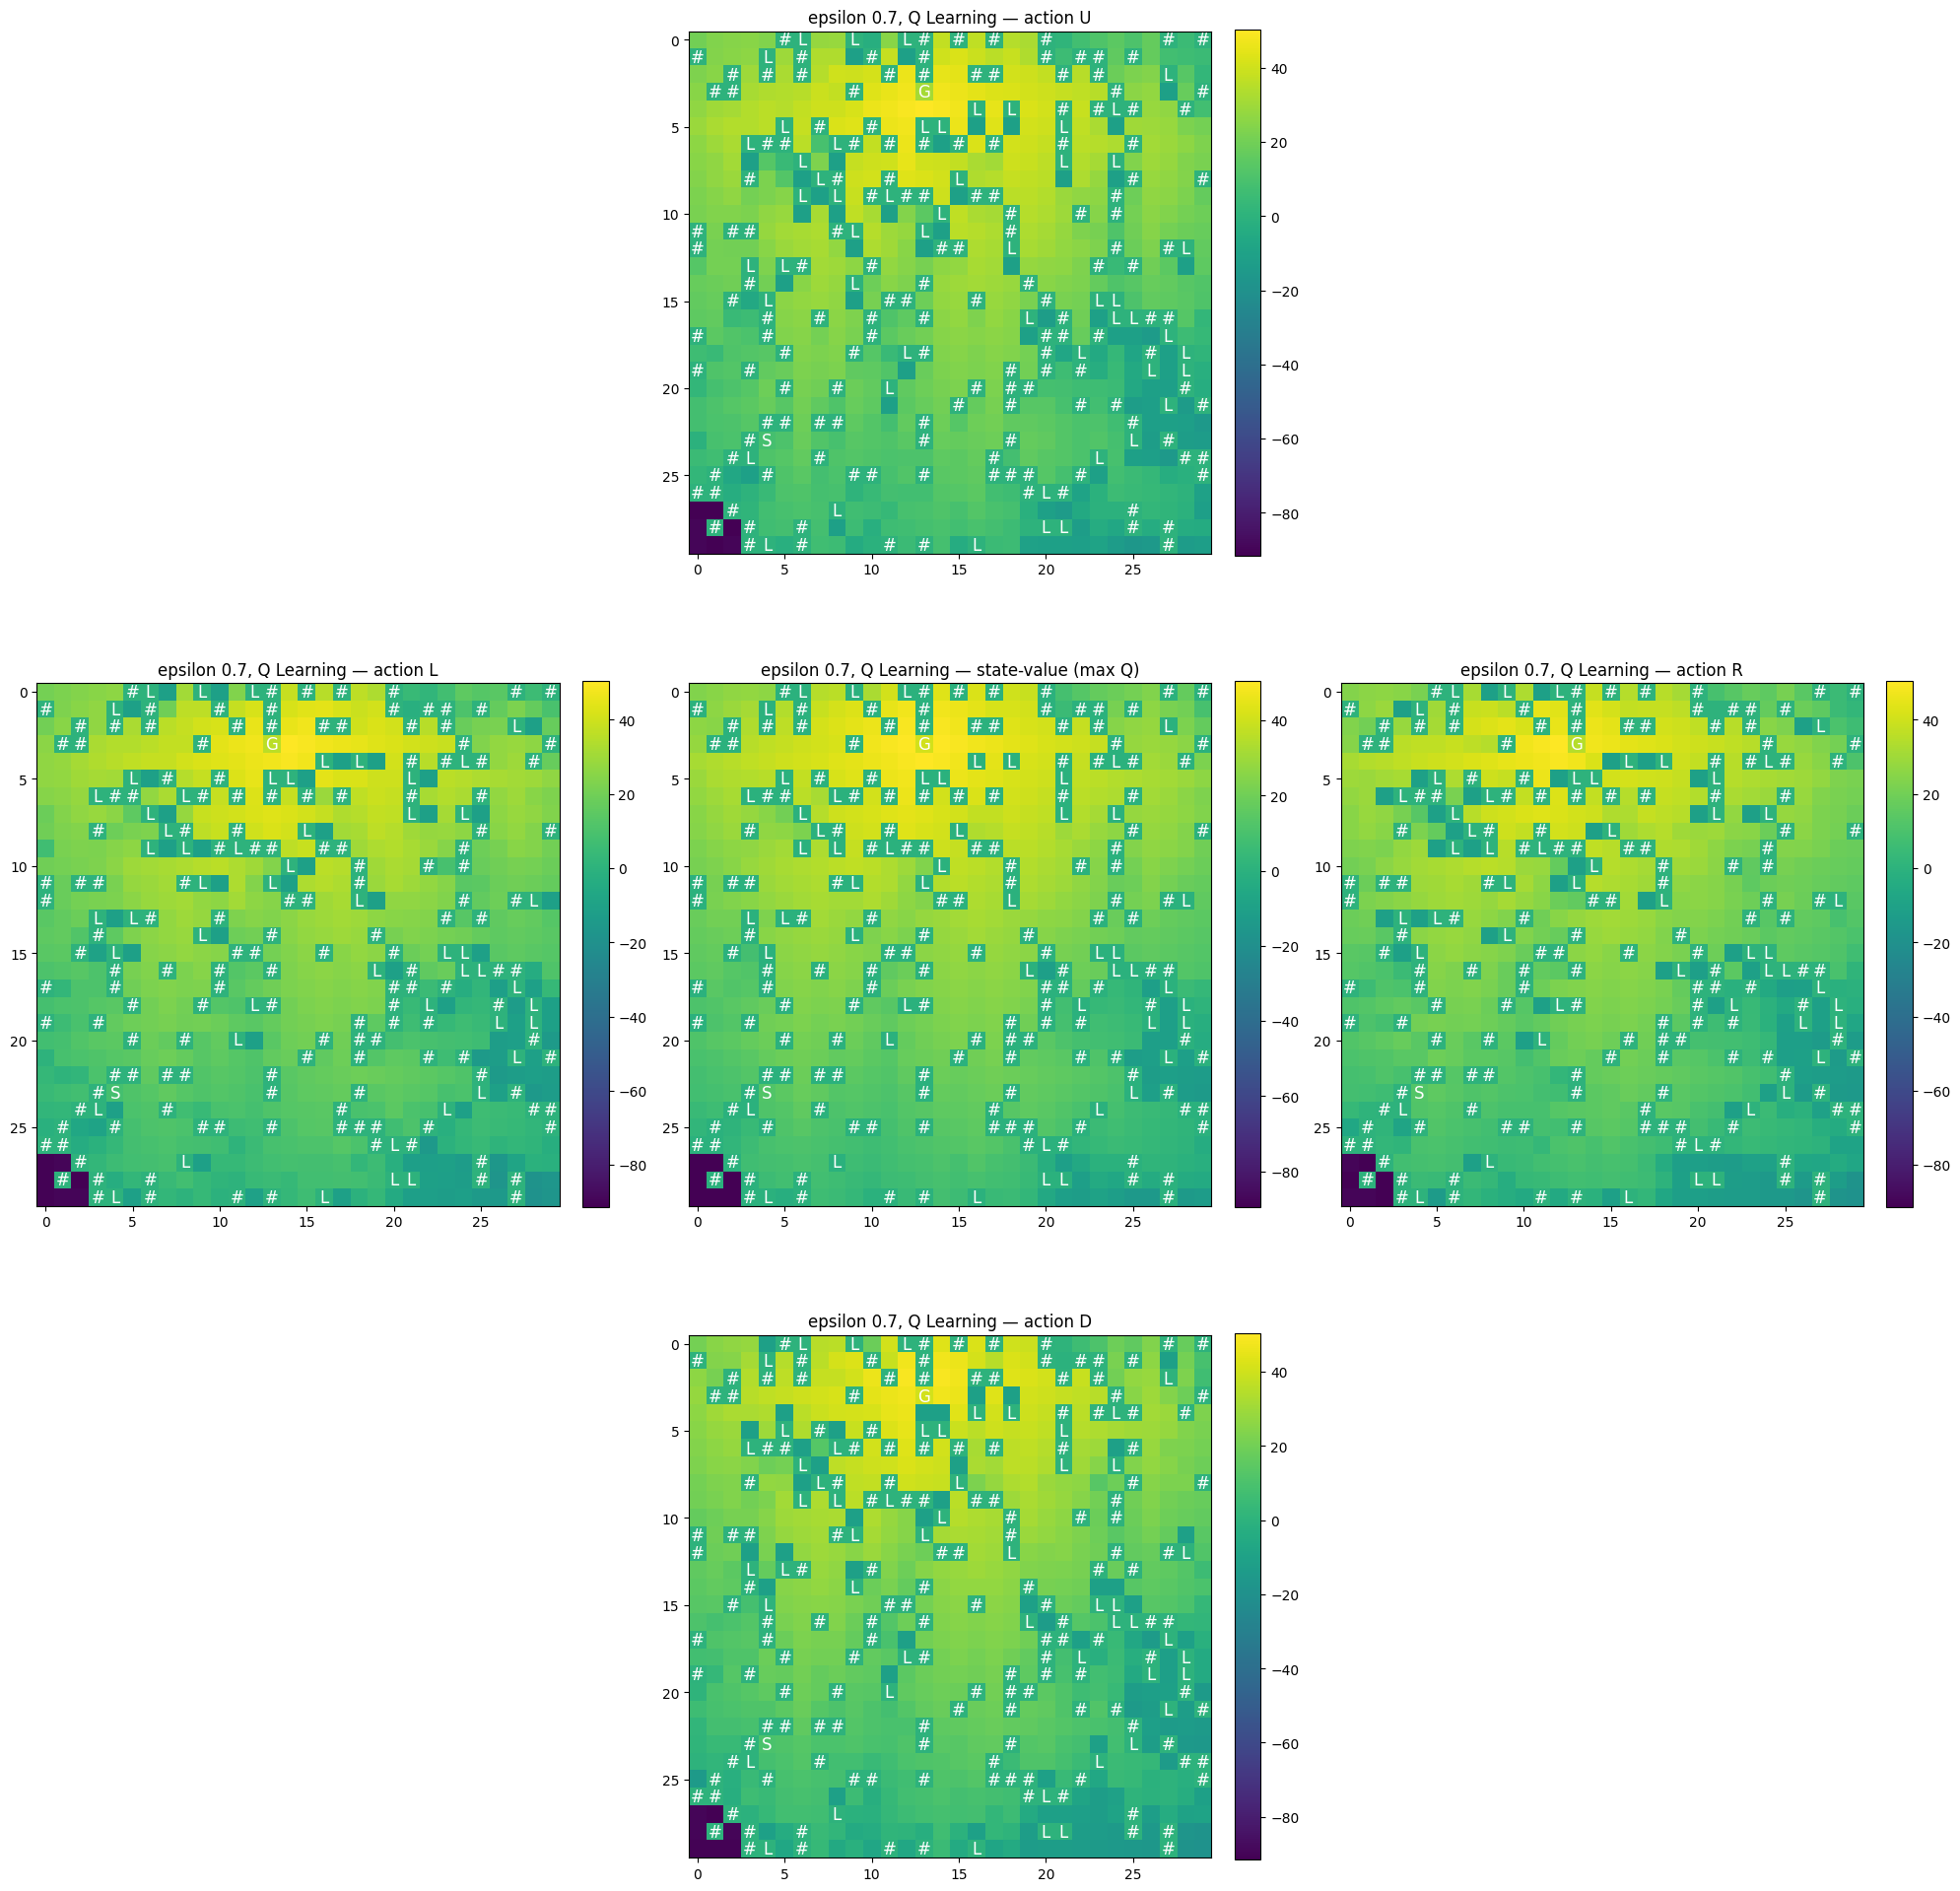

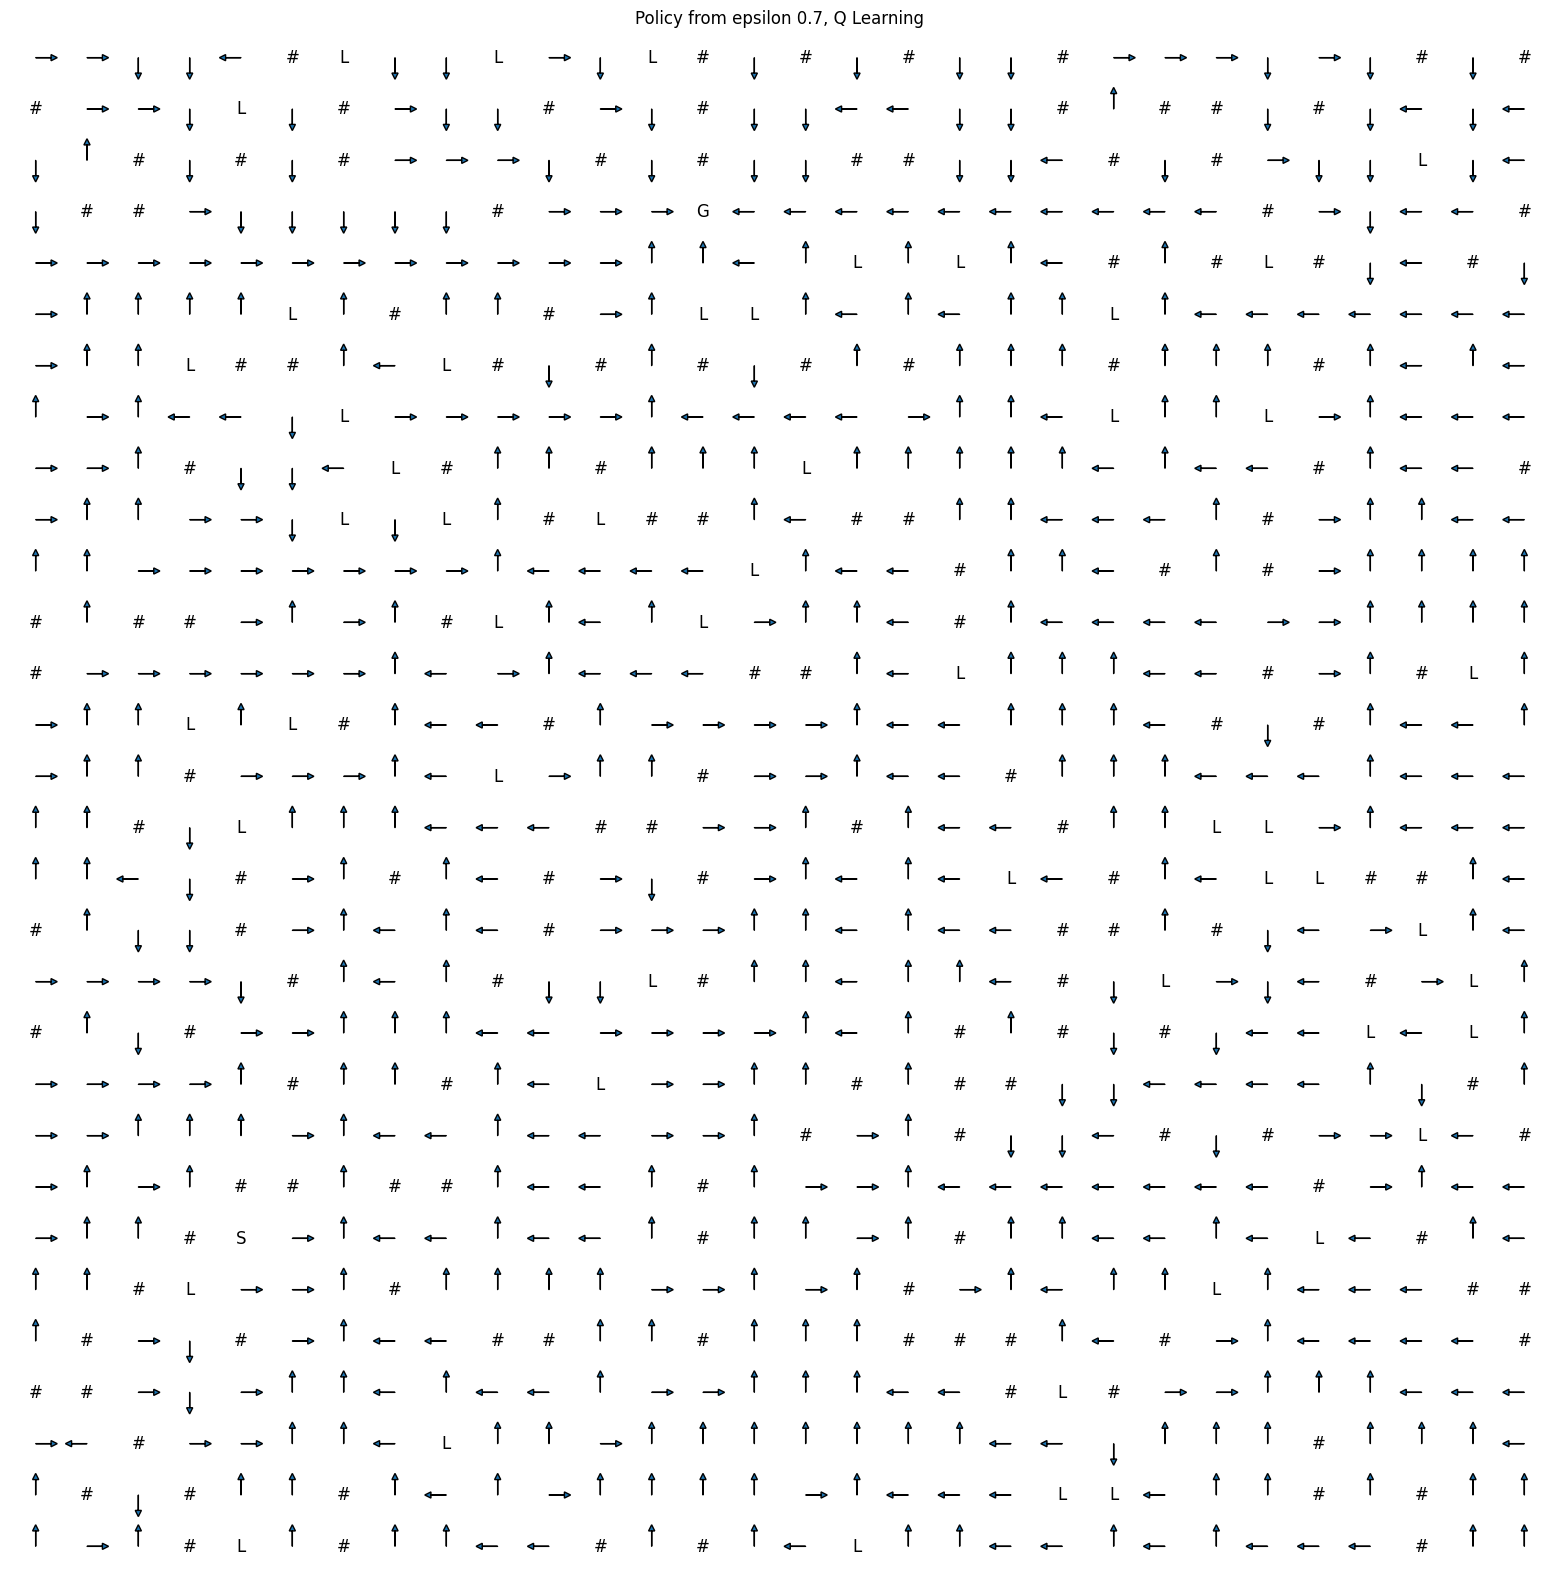

epsilon 0.7, SARSA
. . . . . # L . . L . . L # . # . # . . # . . . . . . # . #
# . . . L . # . . . # . . # . . . . . . # . # # . # . . . .
. . # . # . # . . . . # . # . . # # . . . # . # . . . L . .
. # # . . . . . . # . . . G . . . . . . . . . . # . . . . #
. . . . . . . . . . . . . . . . L . L . . # . # L # . . # .
. . . . . L . # . . # . . L L . . . . . . L . . . . . . . .
. . . L # # . . L # . # . # . # . # . . . # . . . # . . . .
. . . . . . L . . . . . . . . . . . . . . L . . L . . . . .
. . . # . . . L # . . # . . . L . . . . . . . . . # . . . #
. . . . . . L . L . # L # # . . # # . . . . . . # . . . . .
. . . . . . . . . . . . . . L . . . # . . . # . # . . . . .
# . # # . . . . # L . . . L . . . . # . . . . . . . . . . .
# . . . . . . . . . . . . . # # . . L . . . . . # . . # L .
. . . L . L # . . . # . . . . . . . . . . . . # . # . . . .
. . . # . . . . . L . . . # . . . . . # . . . . . . . . . .
. . # . L . . . . . . # # . . . # . . . # . . L L . . . . .
. . . . # . . # . . #

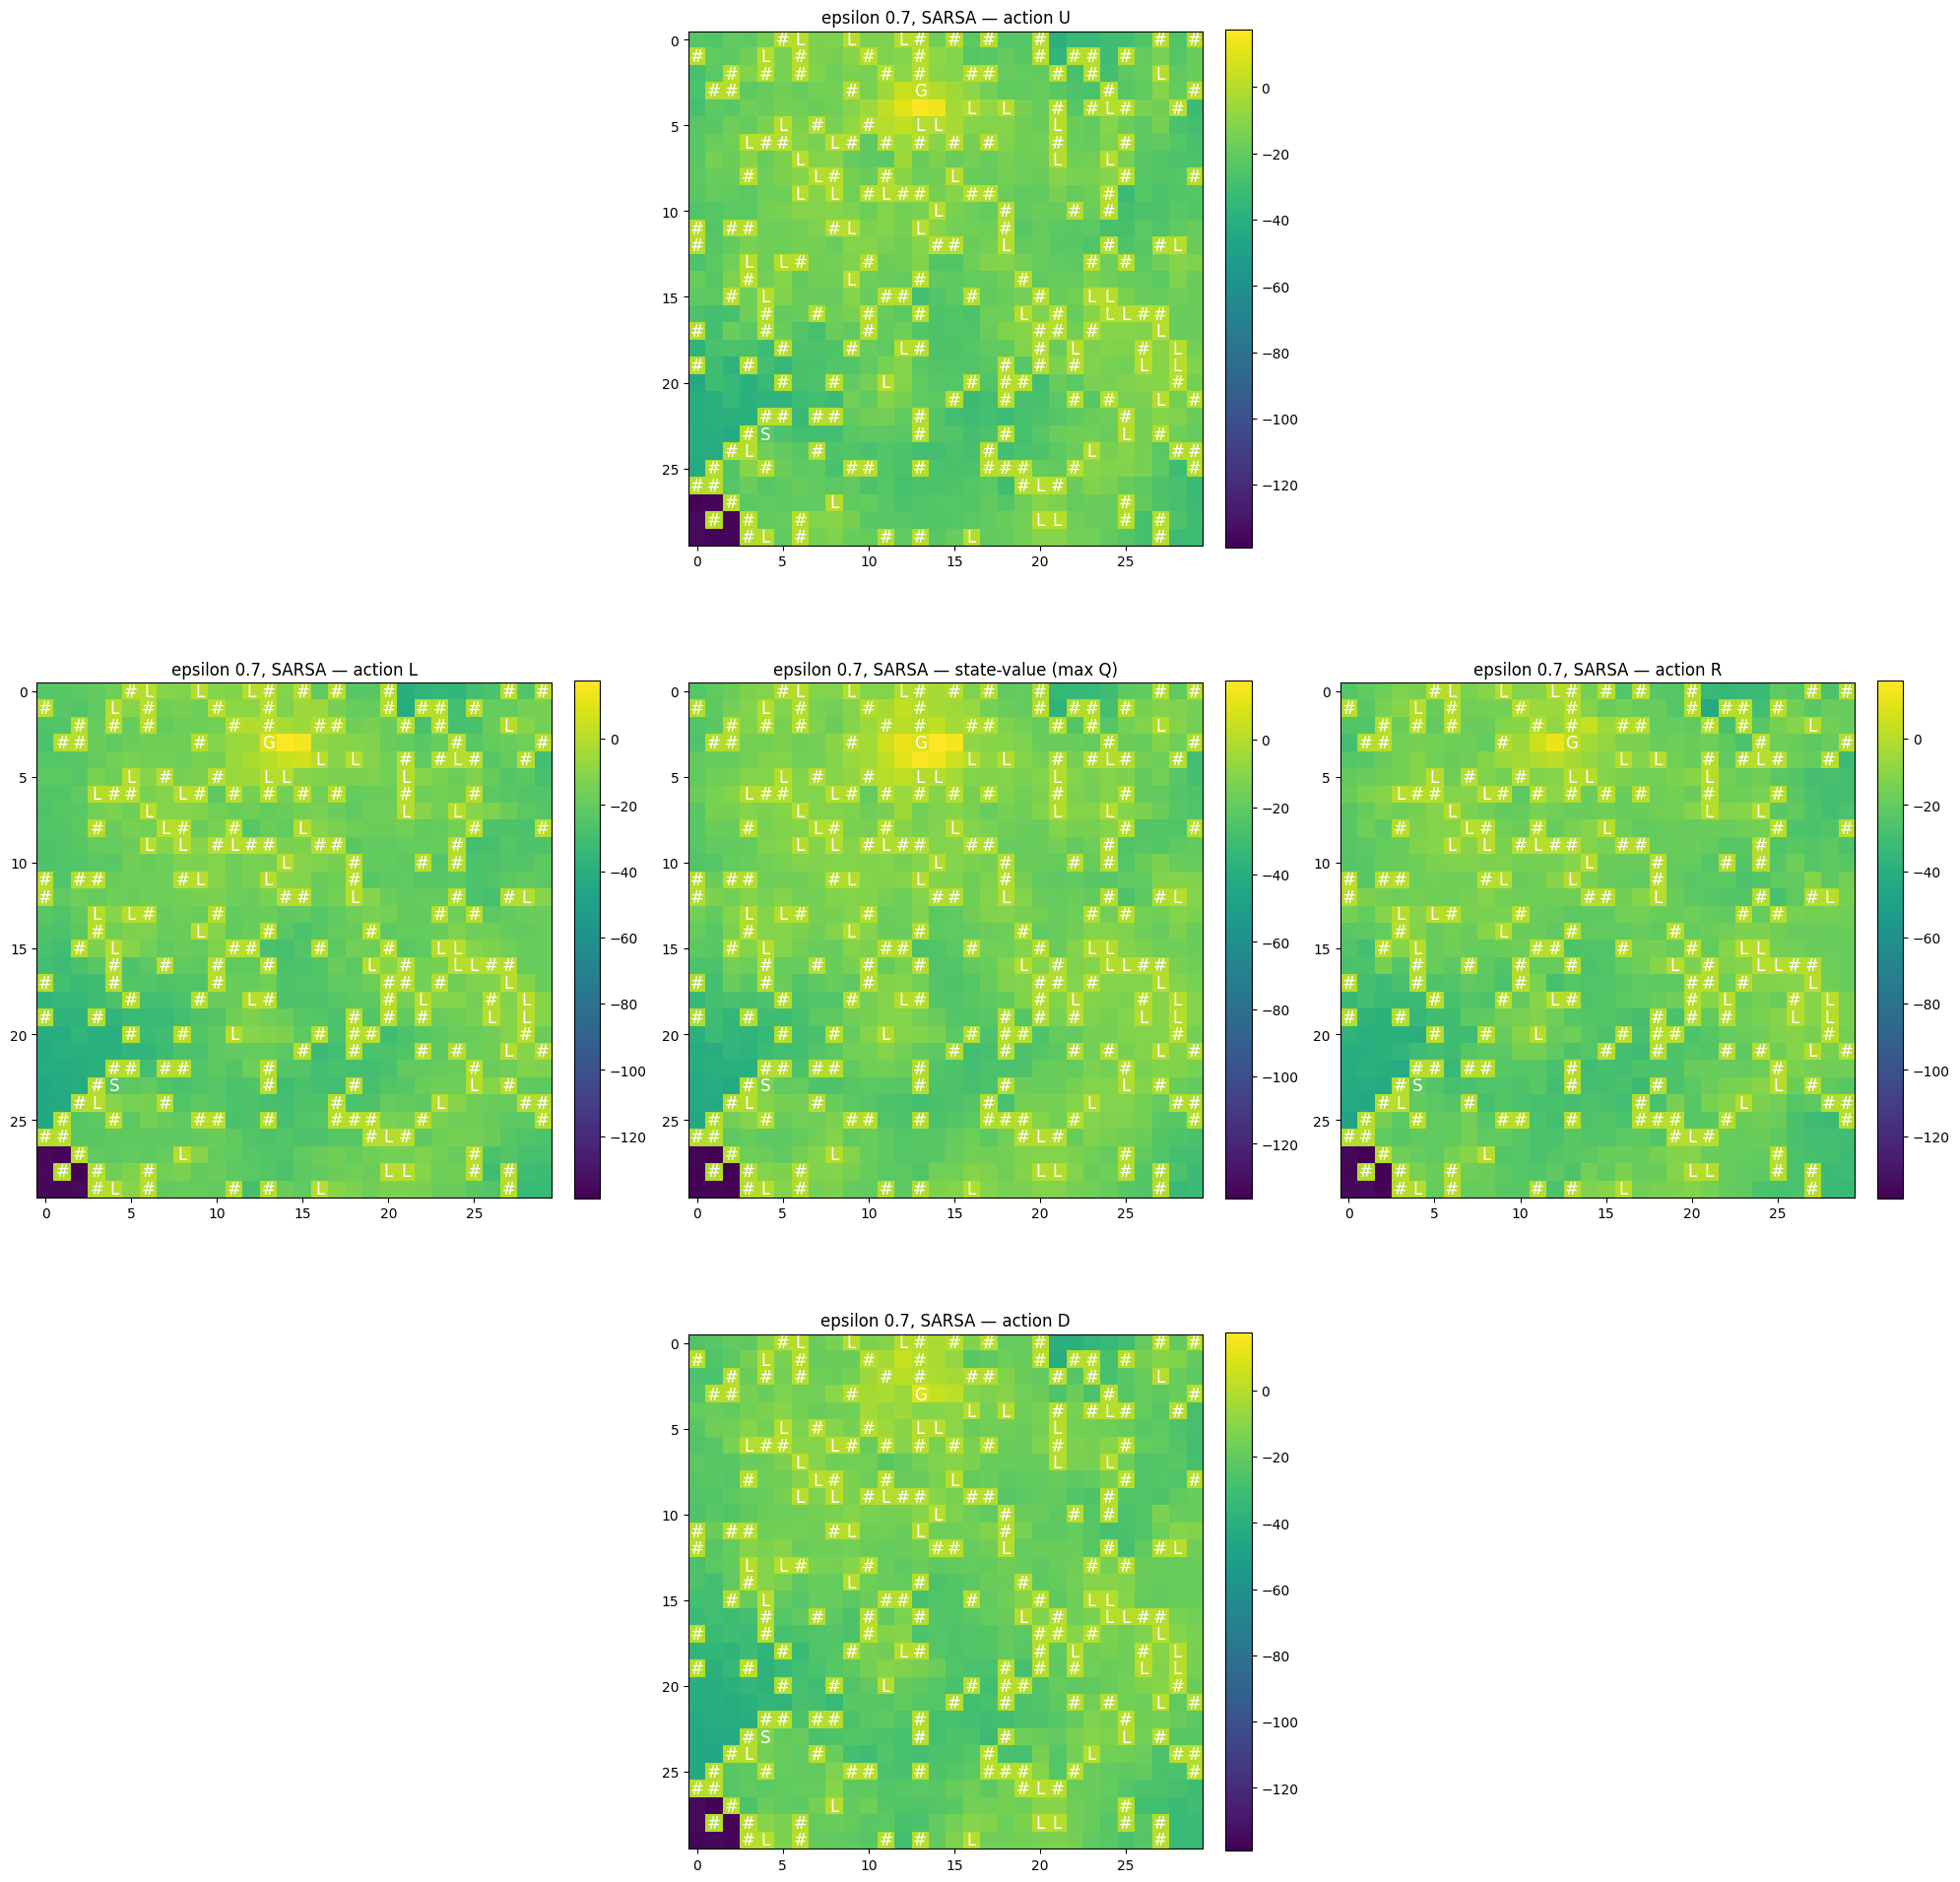

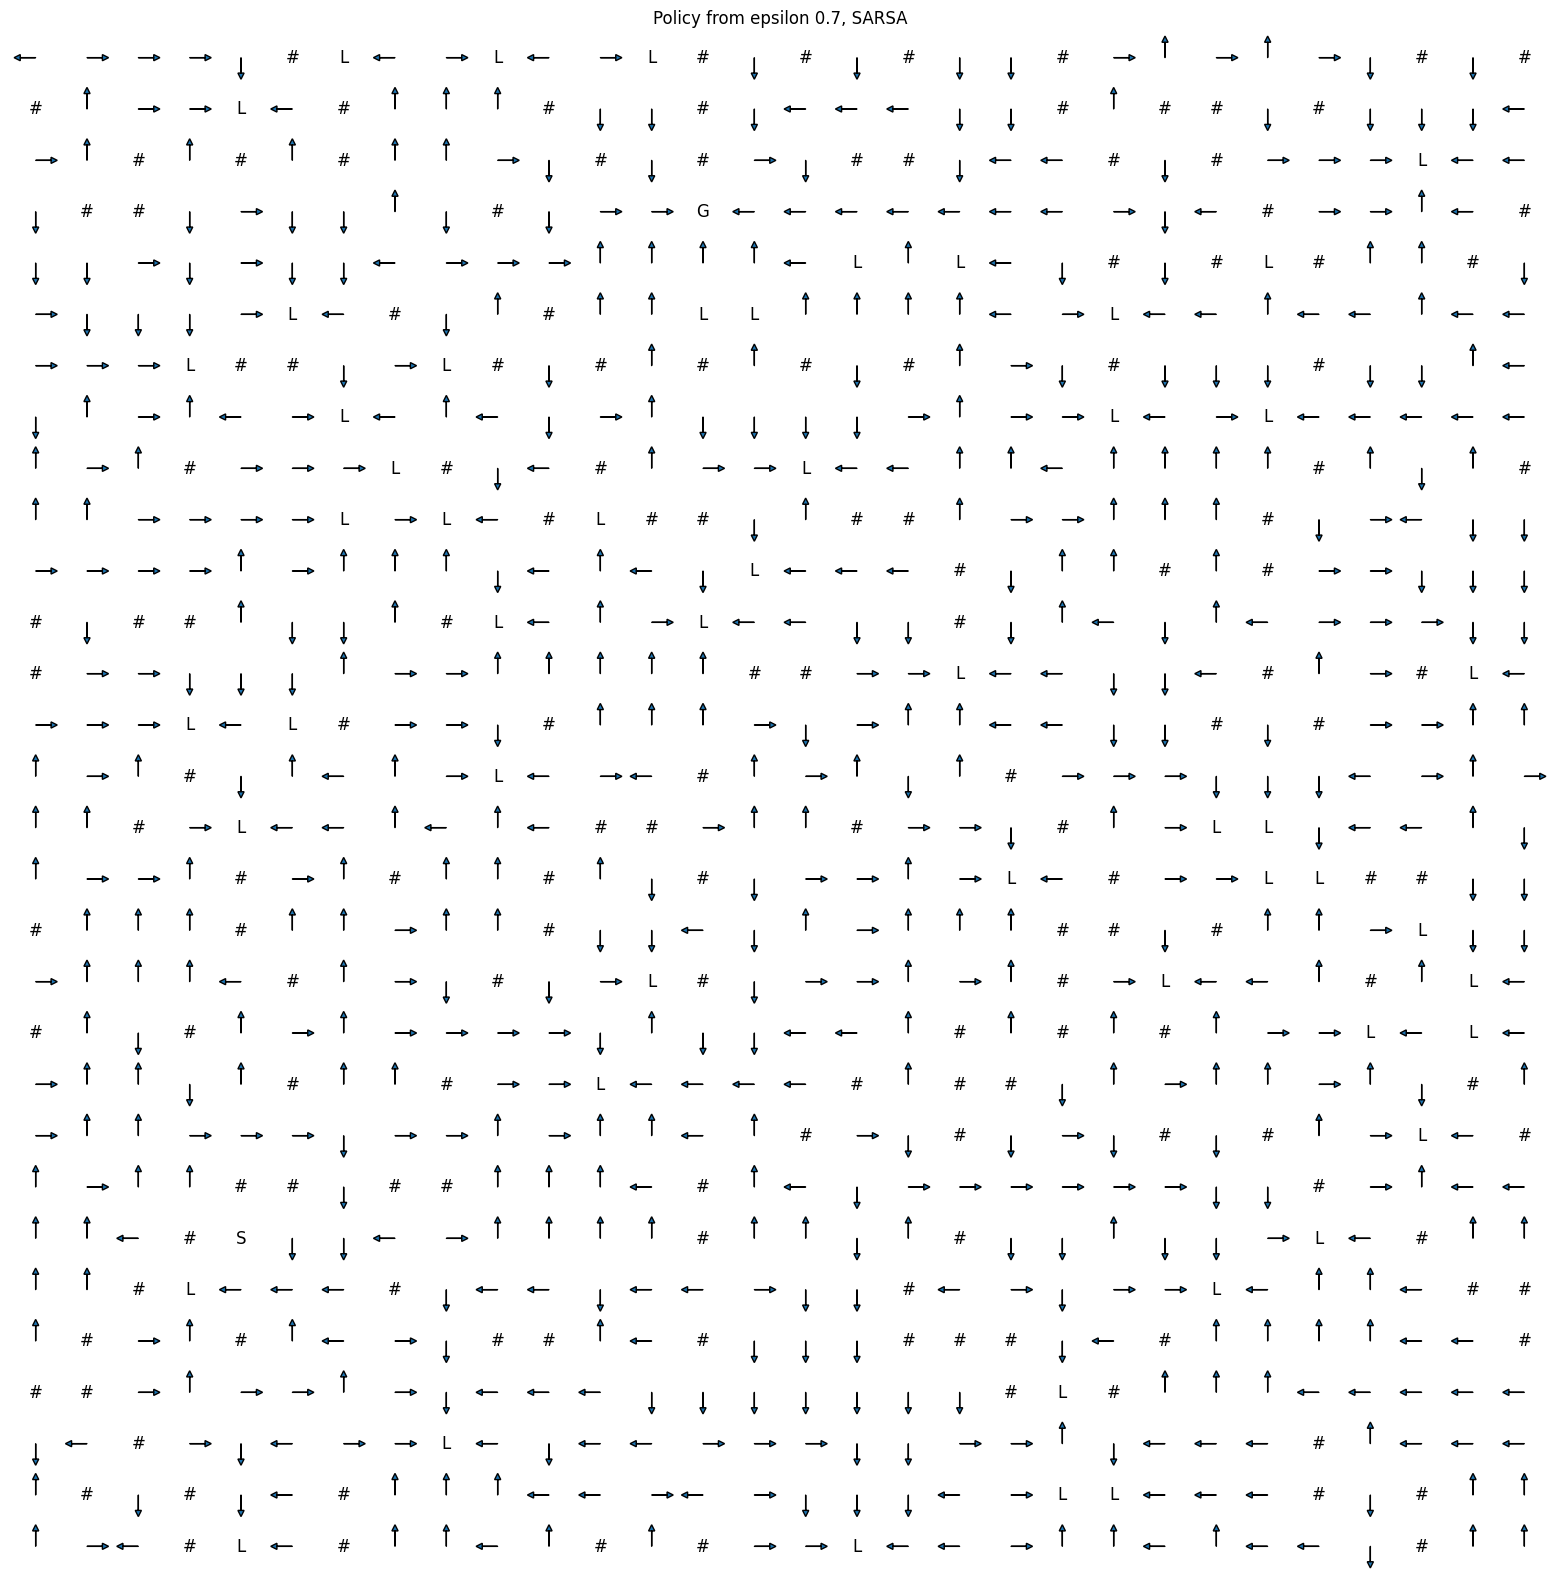

In [9]:
random_initial = True
# Demo runs - modify parameters or call run_experiment yourself
w = 30
h = 30
env_a, Qqa, Qsa, hqa, hsa = run_experiment(width=w, height=h, seed=13, lava_prob=0.08, per_step_penalty=-0.8, episodes=10000, random_initial=random_initial, epsilon=0.0)
env_b, Qqb, Qsb, hqb, hsb = run_experiment(width=w, height=h, seed=13, lava_prob=0.08, per_step_penalty=-0.8, lava_terminal=True, episodes=10000, random_initial=random_initial, epsilon=0.1)
env_c, Qqc, Qsc, hqc, hsc = run_experiment(width=w, height=h, seed=13, lava_prob=0.08, per_step_penalty=-0.8, lava_terminal=True, episodes=10000, random_initial=random_initial, epsilon=0.3)
env_d, Qqd, Qsd, hqd, hsd = run_experiment(width=w, height=h, seed=13, lava_prob=0.08, per_step_penalty=-0.8, lava_terminal=True, episodes=10000, random_initial=random_initial, epsilon=0.7)

# Demo: try to find an existing trained Q (common names used in this notebook are Qqa, Qqb, Qqc, Q_q, Q_s, etc.)
runs = [(env_a,Qqa,'epsilon 0.01, Q Learning'), (env_a,Qsa, 'epsilon 0.01, SARSA'), (env_b,Qqb, 'epsilon 0.1, Q Learning'),
(env_b,Qsb, 'epsilon 0.1, SARSA'), (env_c,Qqc, 'epsilon 0.3, Q Learning'), (env_c,Qsc, 'epsilon 0.3, SARSA'),
(env_d,Qqd, 'epsilon 0.7, Q Learning'), (env_d,Qsd, 'epsilon 0.7, SARSA')]

found = None
for run in runs:
    
    env_var = run[0]
    print(run[2])
    env_var.reset()
    env_var.render()
    Q = run[1]
    plot_q_heatmaps(Q, env_var, title_prefix=f'{run[2]}')
    plot_greedy_policy(Q, env_var, title=f'Policy from {run[2]}')
